# Stock Market Prediction: Modeling

In this series of notebooks, I will create a machine learning algorithm to predict the stock price (Adjusted Close) and make a trading recommendation for the user. 

The input features are:
- Open 
- Close
- Low
- High

For the following stocks, I will create a trained algorithm:
- *Blue chip stocks*: Blue chip stocks are shares of large, established companies with stable financial performance and low risk.
    - BMW (BMW.DE)
    <p>&nbsp;</p> 
- *Growth stocks*: growth stocks are stocks of companies with high potential for future growth. These stocks often carry higher risks, but also offer higher potential returns
    - Tesla, Inc. (TSLA)
    - Bitcoin (BTC-USD)
    <p>&nbsp;</p>
- *Dividend stocks*: dividend stocks are stocks of companies that pay regular dividends to their shareholders. These stocks often carry lower risks and offer a regular source of income. 
    - Johnson & Johnson (JNJ)
    <p>&nbsp;</p>
- *Small-cap stocks*: small-cap stocks are stocks of small companies with higher risk and higher potential for growth and return.
     - Etsy, Inc (ETSY)

The following algorithm will be used for prediction:
- LSTM (Long Short-Term Memory)

This is a popular algorithms for stock prediction. 

The goal is to create an algorithm which can predict the stock prices with a tolerance of ± 5%.
Also, I want to show how the different stock categories influence the accuracy of the algorithm. 

The final program on Github.com (https://github.com/maximkiesel1/Stock_Market_Prediction)  can be used for all stocks.

In this notebook, the focus will be to do feature engineering, splitting the data, train the models and validate the performance. 

**Disclaimer**:

The following is a suggested disclaimer for a trading machine learning algorithm. Please note that this is not a legal advice and should be reviewed and customized by a licensed attorney to fit the specific needs and requirements of the trading algorithm and business.

**Risk Disclaimer**:

Trading in the financial markets involves a high degree of risk and may not be suitable for all investors. The trading machine learning algorithm presented herein is an experimental program and is provided on an "as is" basis without any warranties, expressed or implied. The creators and owners of the algorithm do not make any representations or warranties, either express or implied, as to the accuracy, reliability, completeness, or appropriateness for any particular purpose of the information, analyses, algorithms, or models contained in this algorithm.

The creators and owners of the algorithm do not accept any liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.

Trading and investment decisions are the sole responsibility of the user. It is the responsibility of the user to perform proper due diligence before making any investment or trading decisions. Users should seek professional advice before trading in the financial markets.

Past performance of the algorithm is not indicative of future results. The user assumes full responsibility and risk of using this algorithm. By using this algorithm, the user agrees to these terms and conditions and accepts full responsibility for all trading and investment decisions made using this algorithm.

## Table Of Contents 

#### 1. [Feature Engineering](#fe)  
#### 2. [Training/Validation: LSTM](#tlstm)
#### 3. [Comparison Stock Types](#comparison)
#### 4. [Prediction: LSTM](#plstm)

In [786]:
# load libraries
import sys

from sqlalchemy import create_engine, text, inspect
import ssl

import pandas as pd
import numpy as np

import ta

from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.compat.v1 as tf

import absl.logging
import logging

import random

import warnings

In [787]:
warnings.filterwarnings("ignore", message="`Model.state_updates` will be removed")

## <a class="anchor" id="fe"> 1. Feature Engineering </a>

At first, I load the data from a database. After that, I define the new features and integrate them. Lastly, I split the data in training, validation, and test data. Also, the data will be transformed in a fitted form for the LSTM algorithm.

In [544]:
def load_data(database_filepath):
    '''
    Loading the data from a sql database and transform it to X, y data for the machine learning model.
    Transform the data in arrays
    
    INPUT 
    database_filepath - (str) path to the sql database
      
    OUTPUT
    data - (dict) transformed dfs for the stocks
    '''
    # create the engine for the sql database
    engine = create_engine(f'sqlite:///{database_filepath}')
    
    # create a connection
    conn = engine.connect()
    
    # find the table names in the db
    inspector = inspect(engine)
    table_names = inspector.get_table_names()
    
    data = {}
    for name in table_names:
        
        # transform to a executable object for pandas
        sql = text("SELECT * FROM '{}'".format(name))
        
        # create the dataframe
        df = pd.read_sql(sql, conn)

        # remove hours, minutes, and seconds from the date
        df['date'] = pd.to_datetime(df['date']).dt.date
        
        # set the date as index
        df = df.set_index('date')
        
        # positioning for the target variable on the last column position (for easy finding)
        col = df.pop('Adj Close')
        df['Adj Close'] = col
        
        data[name] = df
        
    return data

I will know explain the new features:

- *Moving Averages (SMA, EMA)*: A moving average calculates the average price of a security or other asset over a specified period of time. The Simple Moving Average (SMA) is the average price over the specified time period. Exponential Moving Average (EMA) is a type of moving average that places more emphasis on the most recent data.

- *Bollinger Bands*: Bollinger Bands are an indicator of the volatility of securities or other assets. They consist of three lines: a simple moving average line, an upper band line, and a lower band line that are two standard deviations away from the simple moving average.

- *Average True Range (ATR)*: The Average True Range is a measure of the volatility of a security or other asset. It is the average of the largest daily price movements of a security or asset over a given time period.

- *MACD*: Moving Average Convergence Divergence (MACD) is an indicator of the trend and momentum changes of a security or other asset. It is calculated by subtracting the 26-period EMA from the 12-period EMA.

- *RSI*: The Relative Strength Index (RSI) is an indicator of the strength of a trend and potential trend reversal. It is calculated by computing the ratio of average gains and losses over a given period of time.

- *Stochastic Oscillator*: The Stochastic Oscillator is a momentum indicator that helps identify overbought and oversold conditions. It compares the closing price of a security or other asset to the high-low range over a specified time period.

- *Stochastic signal*: The Stochastic signal is a signal or trigger line calculated from the moving average of the Stochastic oscillator. It is used to generate buy and sell signals when it crosses above or below the oscillator.

Later on, I will test the model performance with the original 6 features and the performance with the new 11 features. 

In [547]:
def feat_eng(data):
    '''
    Create new features (11) for the X dfs and clean potential Nan values.
    Adjusted the amount of y values.
    
    INPUT 
    Xs - (dict) Feature dfs of the stocks
    ys - (dict) Target variables of the stocks
      
    OUTPUT
    data - (dict) stock dfs with the new features
    '''
    
    # create empty dict for the new dfs with the new features
    data_ =  {}
    
    for name in data:
        
        # define the dfs from the dict
        df = data[name]

        # Moving Averages (SMA, EMA)
        df['SMA'] = ta.trend.sma_indicator(df['Adj Close'], window=20)
        df['EMA'] = ta.trend.ema_indicator(df['Adj Close'], window=20)

        # Bollinger Bands
        bb = ta.volatility.BollingerBands(close=df['Adj Close'], window=20, window_dev=2)
        df['BB_High'] = bb.bollinger_hband()
        df['BB_Low'] = bb.bollinger_lband()

        # Average True Range (ATR)
        atr = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close= df['Adj Close'], window=14)
        df['ATR'] = atr.average_true_range()

        # MACD
        macd = ta.trend.MACD(df['Adj Close'], window_slow=26, window_fast=12, window_sign=9)
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Diff'] = macd.macd_diff()

        # RSI
        df['RSI'] = ta.momentum.RSIIndicator(df['Adj Close'], window=14).rsi()

        # Stochastic Oscillator
        stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Adj Close'], window=14, smooth_window=3)
        df['Stoch_Oscillator'] = stoch.stoch()
        df['Stoch_Signal'] = stoch.stoch_signal()
        
        # delete all row with no values (because of the new features)
        # find the max rows with nan values
        max_nan_row = max(df.isna().sum())
        df = df.drop(df.index[:max_nan_row])
        
        # put the target variable on the place of the last column to find it later
        col = df.pop('Adj Close')
        df['Adj Close'] = col
        
        # add the df in the dict
        data[name] = df

    return data

The next function splits the data, transform it, that it can be used be the LSTM algorithm and do a Z-Score normalization. 

In [558]:
def data_split(df, window_size):
    '''
    Splitting of the datasets in the dictionaries in train, validation, and test (60%, 20%, 20%).
    Transform the date that it can used in the lstm algorithm.
    Z-Score normalization of the data
    
    INPUT 
    df - (dataframe) Stock dataframe
    windows_size - (int) Number of how far back the program should look at the previous data
      
    OUTPUT
    Xs_train - (dict) Splits training data of the input features
    Xs_val - (dict) Split validation data of the input features
    Xs_test - (dict) Split test data of the input features
    test_mean - Mean of the adjusted close in the X test data
    test_std - Standard deviation of the adjusted close in the X test data
    ys_train - (dict) Split training data of the output feature
    ys_val - (dict) Split validation data of the output feature
    ys_test - (dict) Split test data of the output feature
    test_y_mean - mean of the adjusted close in the y test data
    test_std - Standard deviation of the adjusted close in the y test data
    '''
    
    array = np.array(df)
    
    X, y = [], []
    
    for i in range(len(array)-window_size):
        X.append(array[i:i+window_size])
        y.append(array[i+window_size])
        
    X = np.array(X)
    y = np.array(y)
    
    # Split the data into training, validation, and testing sets
    n_samples = len(X)
    train_size = int(0.6 * n_samples)
    val_size = int(0.2 * n_samples)
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]
    
    # Standardize the features in X_train, X_val, and X_test
    for i in range(X_train.shape[-1]):
        train_mean = np.mean(X_train[:, :, i])
        train_std = np.std(X_train[:, :, i])
        val_mean = np.mean(X_val[:, :, i])
        val_std = np.std(X_val[:, :, i])
        test_mean = np.mean(X_test[:, :, i])
        test_std = np.std(X_test[:, :, i])
        
        X_train[:, :, i] = (X_train[:, :, i] - train_mean) / train_std
        X_val[:, :, i] = (X_val[:, :, i] - val_mean) / val_std
        X_test[:, :, i] = (X_test[:, :, i] - test_mean) / test_std
        
        train_y_mean = np.mean(y_train[:,i])
        train_y_std = np.std(y_train[:,i])
        val_y_mean = np.mean(y_val[:,i])
        val_y_std = np.std(y_val[:,i])
        test_y_mean = np.mean(y_test[:,i])
        test_y_std = np.std(y_test[:,i])
        
        y_train[:,i] = (y_train[:,i] - train_y_mean) / train_y_std
        y_val[:, i] = (y_val[:,i] - val_y_mean) / val_y_std
        y_test[:, i] = (y_test[:,i] - test_y_mean) / test_y_std
    
    # the last column (adjusted close) of the X/y test mean and std arrays will be returned (for back transformation)
    return X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std


## <a class="anchor" id="tlstm"> 2. Training/Validation: LSTM </a>

Now I will define a very popular algorithm for time series. It´s the Long Short-Term Memory (LSTM). A Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) architecture that is designed to model sequential data by retaining and selectively forgetting previous information. It achieves this by using a memory cell, an input gate, an output gate, and a forget gate to regulate the flow of information through the cell. 

At first, I define the algorithm for one stock ('BMW.DE') and see if it can perform the 5% tolerance with 6 existing features.

In [559]:
# load the data with 6 features
data = load_data('/Users/maximkiesel/PycharmProjects/Stock_Market_Prediction/data/cleaned_data.db')

In [560]:
def train_model(data, loops):
    '''
    Create new features (11) for the X dfs and clean potential Nan values.
    Adjusted the amount of y values.
    
    INPUT 
    data - (dict) Stock dfs with the new features
    loop - (int) Numbers of loops with randomized model parameter
      
    OUTPUT
    best_model - (dict) Stocks with following items:
    - 'model': Trained model
    - 'mse': Mean Squared Error for the best model
    - 'paramter': List of the parameter of the best model
    '''
    
    # define empty dict
    best_model = {}
    
    # define selection of parameters
    params = {
    'window_size': [4, 8, 12, 20],
    'lstm_units': [16, 32, 64, 128],
    'dense_units': [16, 32, 64, 128],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
    }
    
    # iterate through the stock names
    for name in data:
        
        # info printing
        print('Trained Stock: {}'.format(name))
        
        best_model[name] = {}
        
        # select the arrays
        df = data[name]
        
        # iterate through 
        for i in range(1,loops+1):
            
            # info printing
            print('Parameter run: {}'.format(i))
        
            random_params = {key: random.choice(values) for key, values in params.items()}
    
            # info printing
            print('Parameters: {}'.format(random_params))
    
            X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std = data_split(df, random_params['window_size'])

            # define the model for the stock JNJ
            model = Sequential()
            model.add(InputLayer((random_params['window_size'], X_train.shape[-1]))) # the first parameter is always the window size, the second the number of features
            model.add(LSTM(random_params['lstm_units']))
            model.add(Dense(random_params['dense_units'], 'relu'))
            model.add(Dense(X_train.shape[-1], 'linear')) # output of 17 features
            model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=random_params['learning_rate']), metrics=[RootMeanSquaredError()])
    
            # create a model checkpoint for the best model
            cp = ModelCheckpoint('model', save_best_only=True, verbose=0)
            
            # fitting the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=[cp], verbose=0)
    
            # load the best model
            model = load_model('model')
            
            # get the best mse from the best model
            best_mse = history.history['val_loss'][np.argmin(history.history['val_loss'])]
            
            # if this is the first window size, set the accuracy to the current percent difference
            if i == 1:
                
                best_model[name]['model'] = model
                best_model[name]['mse'] = best_mse
                best_model[name]['paramter'] = random_params
            
            # otherwise, compare the current accuracy to the previous best accuracy and update if necessary
            else:
                
                if best_model[name]['mse'] > best_mse:
                    
                    best_model[name]['model'] = model
                    best_model[name]['mse'] = best_mse
                    best_model[name]['paramter'] = random_params
                
                else:
                    
                    continue
                    
        break # break the loop to just train a model for the stock 'BMW.DE'
        
    return best_model

In [561]:
# train the model with 6 features
best_model = train_model(data, 10)

Trained Stock: BMW.DE
Parameter run: 1
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 32, 'learning_rate': 0.1}


2023-05-05 22:05:08.734474: W tensorflow/c/c_api.cc:300] Operation '{name:'training_428/Adam/dense_459/kernel/m/Assign' id:260648 op device:{requested: '', assigned: ''} def:{{{node training_428/Adam/dense_459/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_428/Adam/dense_459/kernel/m, training_428/Adam/dense_459/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-05-05 22:05:15.548073: W tensorflow/c/c_api.cc:300] Ope

Parameter run: 2
Parameters: {'window_size': 20, 'lstm_units': 64, 'dense_units': 32, 'learning_rate': 0.001}


2023-05-05 22:06:55.390226: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_230/lstm_cell_442/recurrent_kernel/Assign' id:261240 op device:{requested: '', assigned: ''} def:{{{node lstm_230/lstm_cell_442/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_230/lstm_cell_442/recurrent_kernel, lstm_230/lstm_cell_442/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:07:02.368757: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_438/mul' id:261453 op device:{requested: '', assigned: ''} def:{{{node loss_438/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_438/mul/x, loss_438/dense_461_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will h

Parameter run: 3
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 64, 'learning_rate': 0.0001}


2023-05-05 22:09:00.983316: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_231/lstm_cell_444/recurrent_kernel/Assign' id:262453 op device:{requested: '', assigned: ''} def:{{{node lstm_231/lstm_cell_444/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_231/lstm_cell_444/recurrent_kernel, lstm_231/lstm_cell_444/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:09:07.922649: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_440/mul' id:262666 op device:{requested: '', assigned: ''} def:{{{node loss_440/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_440/mul/x, loss_440/dense_463_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will h

Parameter run: 4
Parameters: {'window_size': 8, 'lstm_units': 32, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-05 22:10:58.872421: W tensorflow/c/c_api.cc:300] Operation '{name:'training_434/Adam/decay/Assign' id:264226 op device:{requested: '', assigned: ''} def:{{{node training_434/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_434/Adam/decay, training_434/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:11:05.801655: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_442/mul' id:263871 op device:{requested: '', assigned: ''} def:{{{node loss_442/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_442/mul/x, loss_442/dense_465_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. 

Parameter run: 5
Parameters: {'window_size': 12, 'lstm_units': 64, 'dense_units': 64, 'learning_rate': 0.01}


2023-05-05 22:12:45.035905: W tensorflow/c/c_api.cc:300] Operation '{name:'training_436/Adam/dense_467/bias/m/Assign' id:265477 op device:{requested: '', assigned: ''} def:{{{node training_436/Adam/dense_467/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_436/Adam/dense_467/bias/m, training_436/Adam/dense_467/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:12:52.049795: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_444/mul' id:265076 op device:{requested: '', assigned: ''} def:{{{node loss_444/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_444/mul/x, loss_444/dense_467_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 6
Parameters: {'window_size': 4, 'lstm_units': 64, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-05 22:14:25.477799: W tensorflow/c/c_api.cc:300] Operation '{name:'training_438/Adam/dense_468/kernel/v/Assign' id:266716 op device:{requested: '', assigned: ''} def:{{{node training_438/Adam/dense_468/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_438/Adam/dense_468/kernel/v, training_438/Adam/dense_468/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:14:30.213939: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_446/mul' id:266289 op device:{requested: '', assigned: ''} def:{{{node loss_446/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_446/mul/x, loss_446/dense_469_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 7
Parameters: {'window_size': 20, 'lstm_units': 64, 'dense_units': 128, 'learning_rate': 0.0001}


2023-05-05 22:15:54.219639: W tensorflow/c/c_api.cc:300] Operation '{name:'total_449/Assign' id:267464 op device:{requested: '', assigned: ''} def:{{{node total_449/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_449, total_449/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:15:58.954934: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_448/mul' id:267502 op device:{requested: '', assigned: ''} def:{{{node loss_448/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_448/mul/x, loss_448/dense_471_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Parameter run: 8
Parameters: {'window_size': 8, 'lstm_units': 64, 'dense_units': 32, 'learning_rate': 0.0001}


2023-05-05 22:17:33.956681: W tensorflow/c/c_api.cc:300] Operation '{name:'training_442/Adam/dense_473/kernel/m/Assign' id:269111 op device:{requested: '', assigned: ''} def:{{{node training_442/Adam/dense_473/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_442/Adam/dense_473/kernel/m, training_442/Adam/dense_473/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:17:38.887665: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_450/mul' id:268715 op device:{requested: '', assigned: ''} def:{{{node loss_450/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_450/mul/x, loss_450/dense_473_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 9
Parameters: {'window_size': 12, 'lstm_units': 128, 'dense_units': 32, 'learning_rate': 0.1}


2023-05-05 22:18:55.076077: W tensorflow/c/c_api.cc:300] Operation '{name:'training_444/Adam/dense_474/bias/v/Assign' id:270360 op device:{requested: '', assigned: ''} def:{{{node training_444/Adam/dense_474/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_444/Adam/dense_474/bias/v, training_444/Adam/dense_474/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:18:59.981665: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_452/mul' id:269928 op device:{requested: '', assigned: ''} def:{{{node loss_452/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_452/mul/x, loss_452/dense_475_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 10
Parameters: {'window_size': 20, 'lstm_units': 64, 'dense_units': 64, 'learning_rate': 0.0001}


2023-05-05 22:20:37.319732: W tensorflow/c/c_api.cc:300] Operation '{name:'training_446/Adam/iter/Assign' id:271481 op device:{requested: '', assigned: ''} def:{{{node training_446/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_446/Adam/iter, training_446/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:20:42.093766: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_454/mul' id:271141 op device:{requested: '', assigned: ''} def:{{{node loss_454/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_454/mul/x, loss_454/dense_477_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't

In [562]:
# show the best model components 
best_model

{'BMW.DE': {'model': <keras.engine.sequential.Sequential at 0x3511025c0>,
  'mse': 0.1506504099058911,
  'paramter': {'window_size': 8,
   'lstm_units': 32,
   'dense_units': 128,
   'learning_rate': 0.001}}}

In this step, I will visualize the data to how it fits.

In [576]:
def model_validation(data, best_model):
    
    for name in best_model:
        
        X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std  = data_split(data[name], best_model[name]['paramter']['window_size'])
        
        # make prediction
        test_predictions = best_model[name]['model'].predict(np.array(X_test))
        
        # select the Adjusted Close for prediction (last column)
        test_predictions_ = test_predictions[:,-1].tolist()
        
        # back transformation for X data  from the normalization 
        transfom_X = ((np.array(test_predictions_)*test_std) + test_mean).tolist()

        # select the Adjusted Close for test data (last column)
        y_test_ = y_test[:,-1].tolist()
        
        # back transformation for y data  from the normalization 
        transfom_y = ((np.array(y_test_)*test_y_std) + test_y_mean).tolist()

        # create a dataframe with predicted values and real values
        test_results = pd.DataFrame(data={'Test Predictions':transfom_X, 'Actuals': transfom_y})
        
        # calculate the difference between prediction and ground truth
        test_results['diff'] = test_results['Test Predictions']-test_results['Actuals']
        
        # calculate the percentage difference between prediction and ground truth
        test_results['diff%'] = (test_results['diff'] / test_results['Actuals'])*100
        
        # plotting
        print('######################')
        print(name)
        print('######################')
        
        # show the statistical informations
        print(test_results.describe())

        # plot test and ground truth data
        plt.figure(figsize=(25, 15))
        plt.plot(test_results['Test Predictions'], label='Test Predictions')
        plt.plot(test_results['Actuals'], label='Actuals')
        plt.title('Comparison Adjusted Close: Predicted And Real Values in Test Data Set')
        plt.ylabel('Adjusted Close')
        plt.xlabel('Timeline')
        plt.legend()
        plt.grid()
        plt.show()
        
        # plot for percentage deviation between predicted and real values in test data 
        plt.figure(figsize=(25, 15))
        plt.plot(test_results.index, test_results['diff%'], color='steelblue', label='Percentage Deviation')
        plt.axhline(y=5, color='r', linestyle=':', label='Upper Tolerance')
        plt.axhline(y=-5, color='r', linestyle=':', label='Lower Tolerance')
        plt.grid()
        plt.legend()
        plt.ylabel('Percentage Deviation[%]')
        plt.xlabel('Timeline')
        plt.title('Percentage Deviation For Adjusted Close Between Predicted And Real Values in Test Data Set')
        plt.show()
        print('The mean for the percentage deviation in the test data is {}.'.format(abs(np.mean(abs(test_results['diff%'])))))
        print('-----------------------------------------')
        
    return None
        
        

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-05 22:22:07.175208: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_465_1/BiasAdd' id:264591 op device:{requested: '', assigned: ''} def:{{{node dense_465_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_465_1/MatMul, dense_465_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


######################
BMW.DE
######################
       Test Predictions     Actuals        diff       diff%
count        248.000000  248.000000  248.000000  248.000000
mean          84.225243   84.207137    0.018106    0.161497
std            8.926694    9.851573    1.693369    2.069065
min           70.858204   69.129997   -5.390077   -5.249394
25%           77.035310   76.412504   -1.205600   -1.304901
50%           81.346594   81.674999   -0.064819   -0.083312
75%           91.807980   92.349998    1.064411    1.349908
max          102.158919  104.099998    4.830272    6.308308


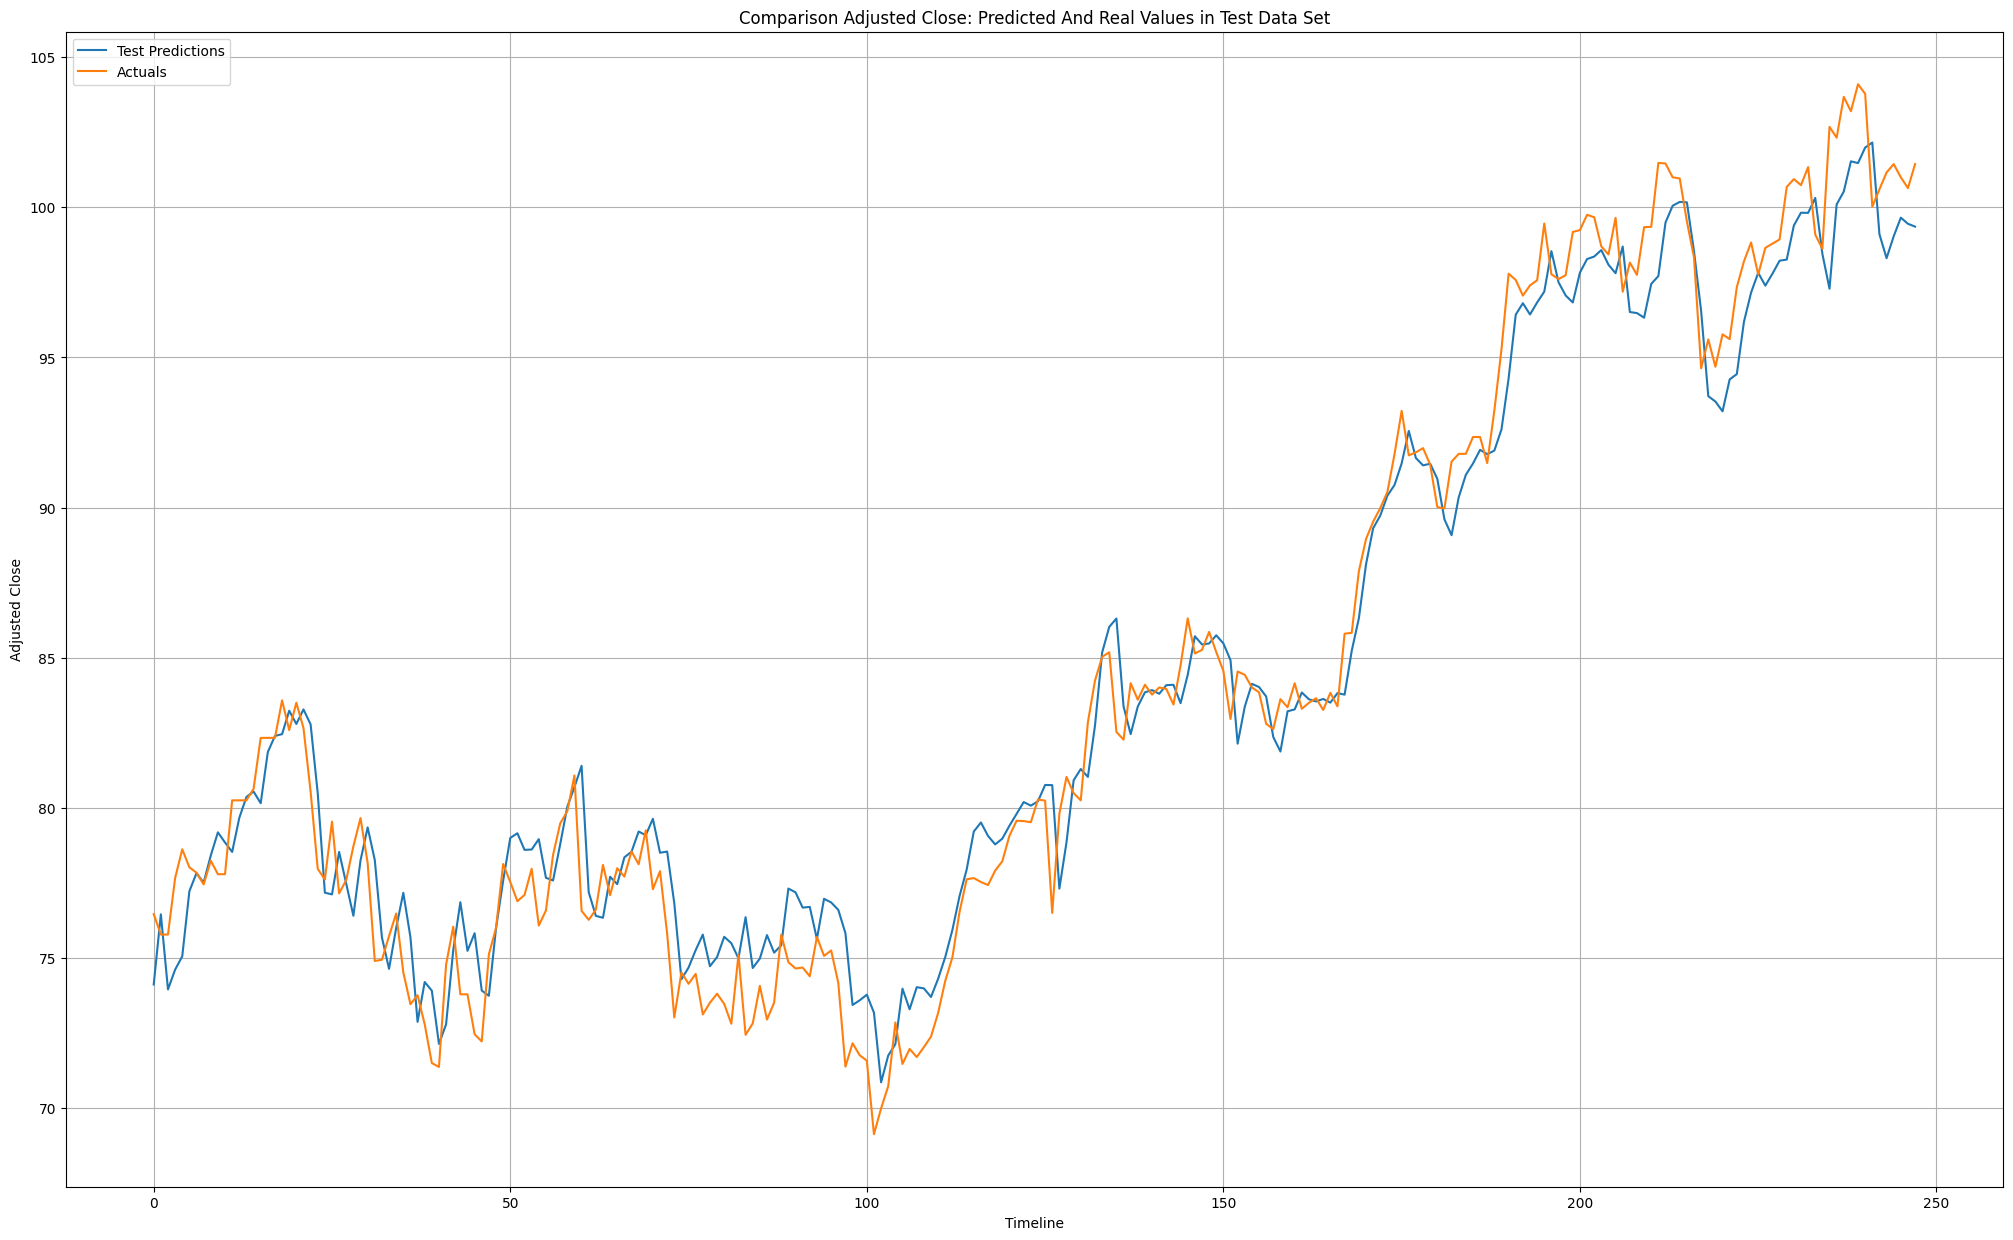

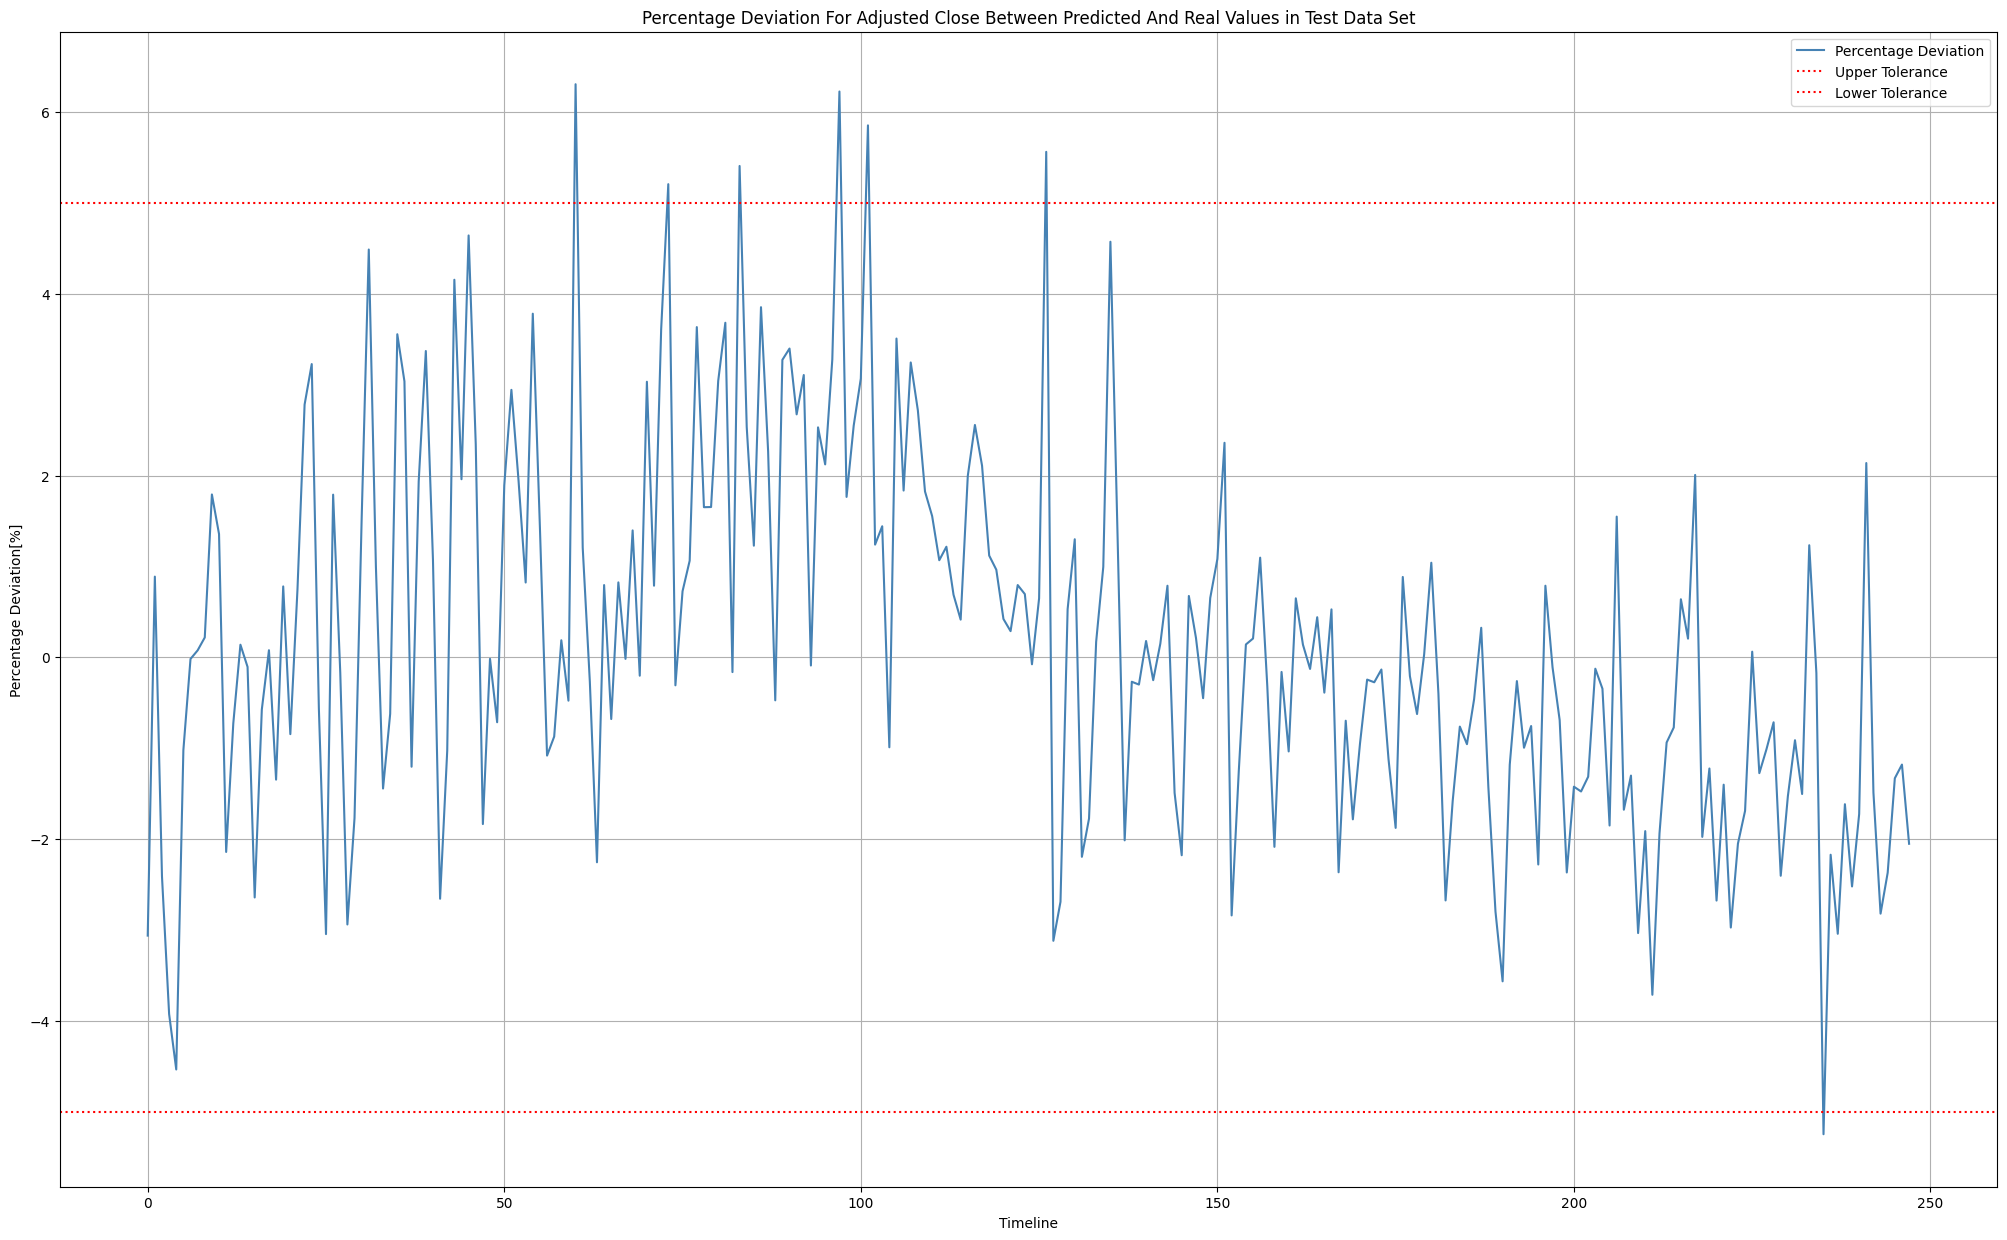

The mean for the percentage deviation in the test data is 0.1614974421052127.
-----------------------------------------


In [564]:
# showing the performance of the best model
model_validation(data, best_model)

The result is not bad. Let´s if it can be better with 11 more features.

***Information***: I´m aware, that with a loop of 10 don´t include all parameter constellations. Due to the training time, I decided this loop number. 

In [565]:
data = feat_eng(data)

In [566]:
# train the model with 17 features
best_model = train_model(data, 10)

Trained Stock: BMW.DE
Parameter run: 1
Parameters: {'window_size': 4, 'lstm_units': 64, 'dense_units': 64, 'learning_rate': 0.0001}


2023-05-05 22:22:14.385561: W tensorflow/c/c_api.cc:300] Operation '{name:'training_448/Adam/dense_479/bias/m/Assign' id:272758 op device:{requested: '', assigned: ''} def:{{{node training_448/Adam/dense_479/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_448/Adam/dense_479/bias/m, training_448/Adam/dense_479/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-05-05 22:22:19.276237: W tensorflow/c/c_api.cc:300] Operation '

Parameter run: 2
Parameters: {'window_size': 20, 'lstm_units': 32, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-05 22:23:35.009854: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_480/kernel/Assign' id:273503 op device:{requested: '', assigned: ''} def:{{{node dense_480/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_480/kernel, dense_480/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:23:39.803054: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_458/mul' id:273576 op device:{requested: '', assigned: ''} def:{{{node loss_458/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_458/mul/x, loss_458/dense_481_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes a

Parameter run: 3
Parameters: {'window_size': 12, 'lstm_units': 16, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-05 22:25:02.873185: W tensorflow/c/c_api.cc:300] Operation '{name:'training_452/Adam/lstm_241/lstm_cell_464/bias/m/Assign' id:275160 op device:{requested: '', assigned: ''} def:{{{node training_452/Adam/lstm_241/lstm_cell_464/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_452/Adam/lstm_241/lstm_cell_464/bias/m, training_452/Adam/lstm_241/lstm_cell_464/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:25:07.715682: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_460/mul' id:274781 op device:{requested: '', assigned: ''} def:{{{node loss_460/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_460/mul/x, loss_460/dense_483_loss/value)}}' was changed by setting attribute after it was run by

Parameter run: 4
Parameters: {'window_size': 4, 'lstm_units': 64, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-05 22:26:18.165295: W tensorflow/c/c_api.cc:300] Operation '{name:'training_454/Adam/dense_484/kernel/m/Assign' id:276388 op device:{requested: '', assigned: ''} def:{{{node training_454/Adam/dense_484/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_454/Adam/dense_484/kernel/m, training_454/Adam/dense_484/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:26:23.028178: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_462/mul' id:276002 op device:{requested: '', assigned: ''} def:{{{node loss_462/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_462/mul/x, loss_462/dense_485_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 5
Parameters: {'window_size': 4, 'lstm_units': 16, 'dense_units': 128, 'learning_rate': 0.1}


2023-05-05 22:27:39.547770: W tensorflow/c/c_api.cc:300] Operation '{name:'count_465/Assign' id:277182 op device:{requested: '', assigned: ''} def:{{{node count_465/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_465, count_465/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:27:44.383455: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_464/mul' id:277215 op device:{requested: '', assigned: ''} def:{{{node loss_464/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_464/mul/x, loss_464/dense_487_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Parameter run: 6
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 64, 'learning_rate': 0.001}


2023-05-05 22:28:51.294914: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_244/lstm_cell_470/recurrent_kernel/Assign' id:278223 op device:{requested: '', assigned: ''} def:{{{node lstm_244/lstm_cell_470/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_244/lstm_cell_470/recurrent_kernel, lstm_244/lstm_cell_470/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:28:56.104470: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_466/mul' id:278436 op device:{requested: '', assigned: ''} def:{{{node loss_466/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_466/mul/x, loss_466/dense_489_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will h

Parameter run: 7
Parameters: {'window_size': 8, 'lstm_units': 128, 'dense_units': 128, 'learning_rate': 0.01}


2023-05-05 22:30:05.692141: W tensorflow/c/c_api.cc:300] Operation '{name:'training_460/Adam/iter/Assign' id:279997 op device:{requested: '', assigned: ''} def:{{{node training_460/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_460/Adam/iter, training_460/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:30:10.547121: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_468/mul' id:279657 op device:{requested: '', assigned: ''} def:{{{node loss_468/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_468/mul/x, loss_468/dense_491_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't

Parameter run: 8
Parameters: {'window_size': 4, 'lstm_units': 128, 'dense_units': 128, 'learning_rate': 0.0001}


2023-05-05 22:31:43.471144: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_246/lstm_cell_474/recurrent_kernel/Assign' id:280665 op device:{requested: '', assigned: ''} def:{{{node lstm_246/lstm_cell_474/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_246/lstm_cell_474/recurrent_kernel, lstm_246/lstm_cell_474/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:31:48.348441: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_470/mul' id:280878 op device:{requested: '', assigned: ''} def:{{{node loss_470/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_470/mul/x, loss_470/dense_493_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will h

Parameter run: 9
Parameters: {'window_size': 12, 'lstm_units': 16, 'dense_units': 64, 'learning_rate': 0.01}


2023-05-05 22:33:18.997624: W tensorflow/c/c_api.cc:300] Operation '{name:'training_464/Adam/beta_2/Assign' id:282449 op device:{requested: '', assigned: ''} def:{{{node training_464/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_464/Adam/beta_2, training_464/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:33:23.777949: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_472/mul' id:282099 op device:{requested: '', assigned: ''} def:{{{node loss_472/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_472/mul/x, loss_472/dense_495_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the futu

Parameter run: 10
Parameters: {'window_size': 12, 'lstm_units': 16, 'dense_units': 64, 'learning_rate': 0.0001}


2023-05-05 22:34:36.781083: W tensorflow/c/c_api.cc:300] Operation '{name:'training_466/Adam/beta_2/Assign' id:283670 op device:{requested: '', assigned: ''} def:{{{node training_466/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_466/Adam/beta_2, training_466/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:34:41.782728: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_474/mul' id:283320 op device:{requested: '', assigned: ''} def:{{{node loss_474/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_474/mul/x, loss_474/dense_497_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the futu

In [567]:
# show the best model components 
best_model

{'BMW.DE': {'model': <keras.engine.sequential.Sequential at 0x3560e3580>,
  'mse': 0.13037334233522416,
  'paramter': {'window_size': 4,
   'lstm_units': 128,
   'dense_units': 128,
   'learning_rate': 0.0001}}}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-05 22:36:00.895822: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_493_1/BiasAdd' id:281606 op device:{requested: '', assigned: ''} def:{{{node dense_493_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_493_1/MatMul, dense_493_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


######################
BMW.DE
######################
       Test Predictions     Actuals        diff       diff%
count        242.000000  242.000000  242.000000  242.000000
mean          84.897725   84.384504    0.513221    0.542161
std           10.659348    9.906238    1.871615    2.218906
min           69.825977   69.129997   -4.067823   -5.101201
25%           75.736022   76.485003   -0.720332   -0.910156
50%           81.576661   82.330002    0.499298    0.563475
75%           94.099558   93.002501    1.777511    2.067645
max          106.978872  104.099998    6.785454    6.784098


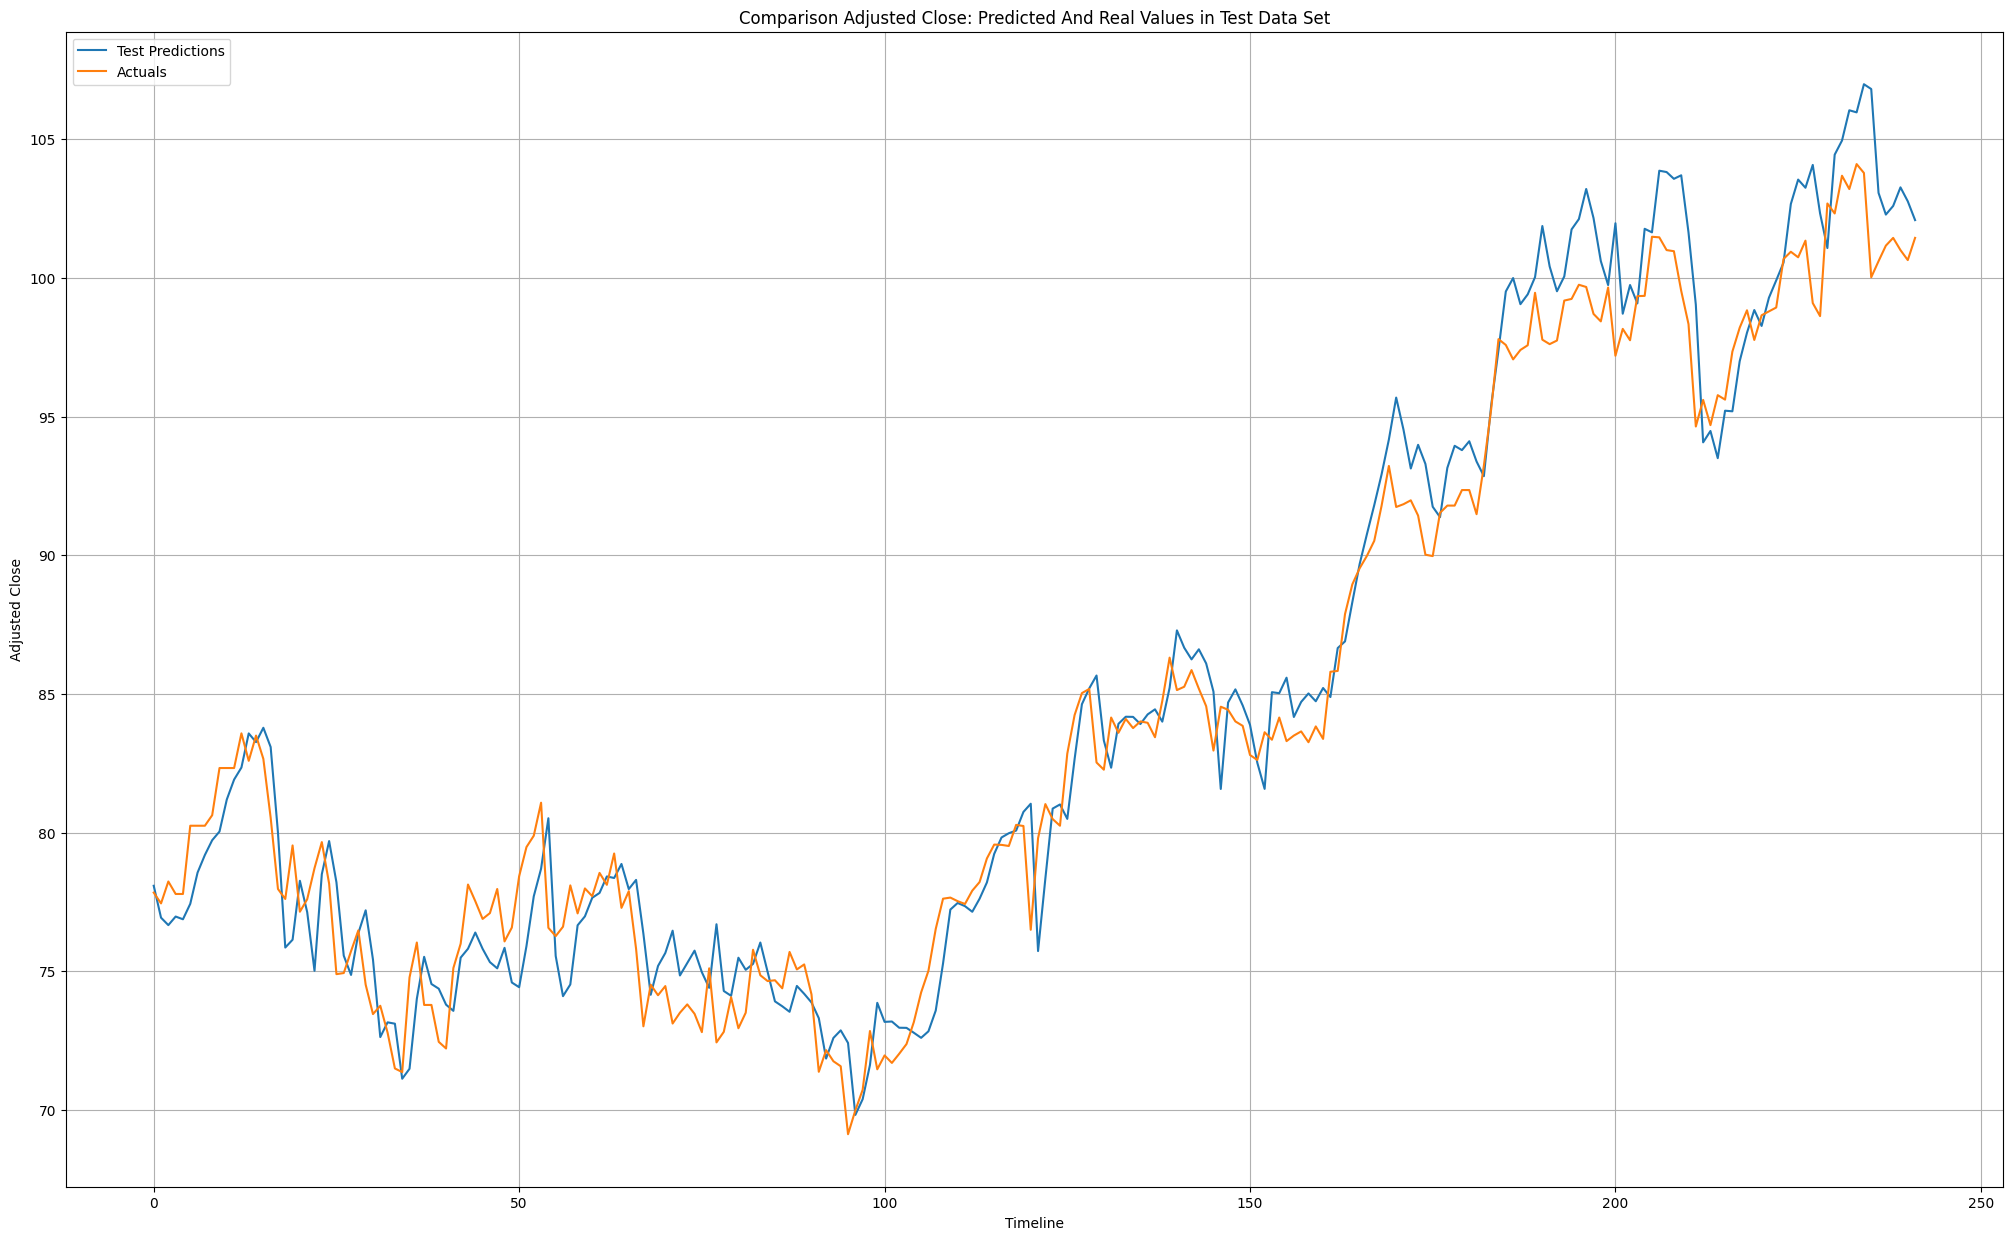

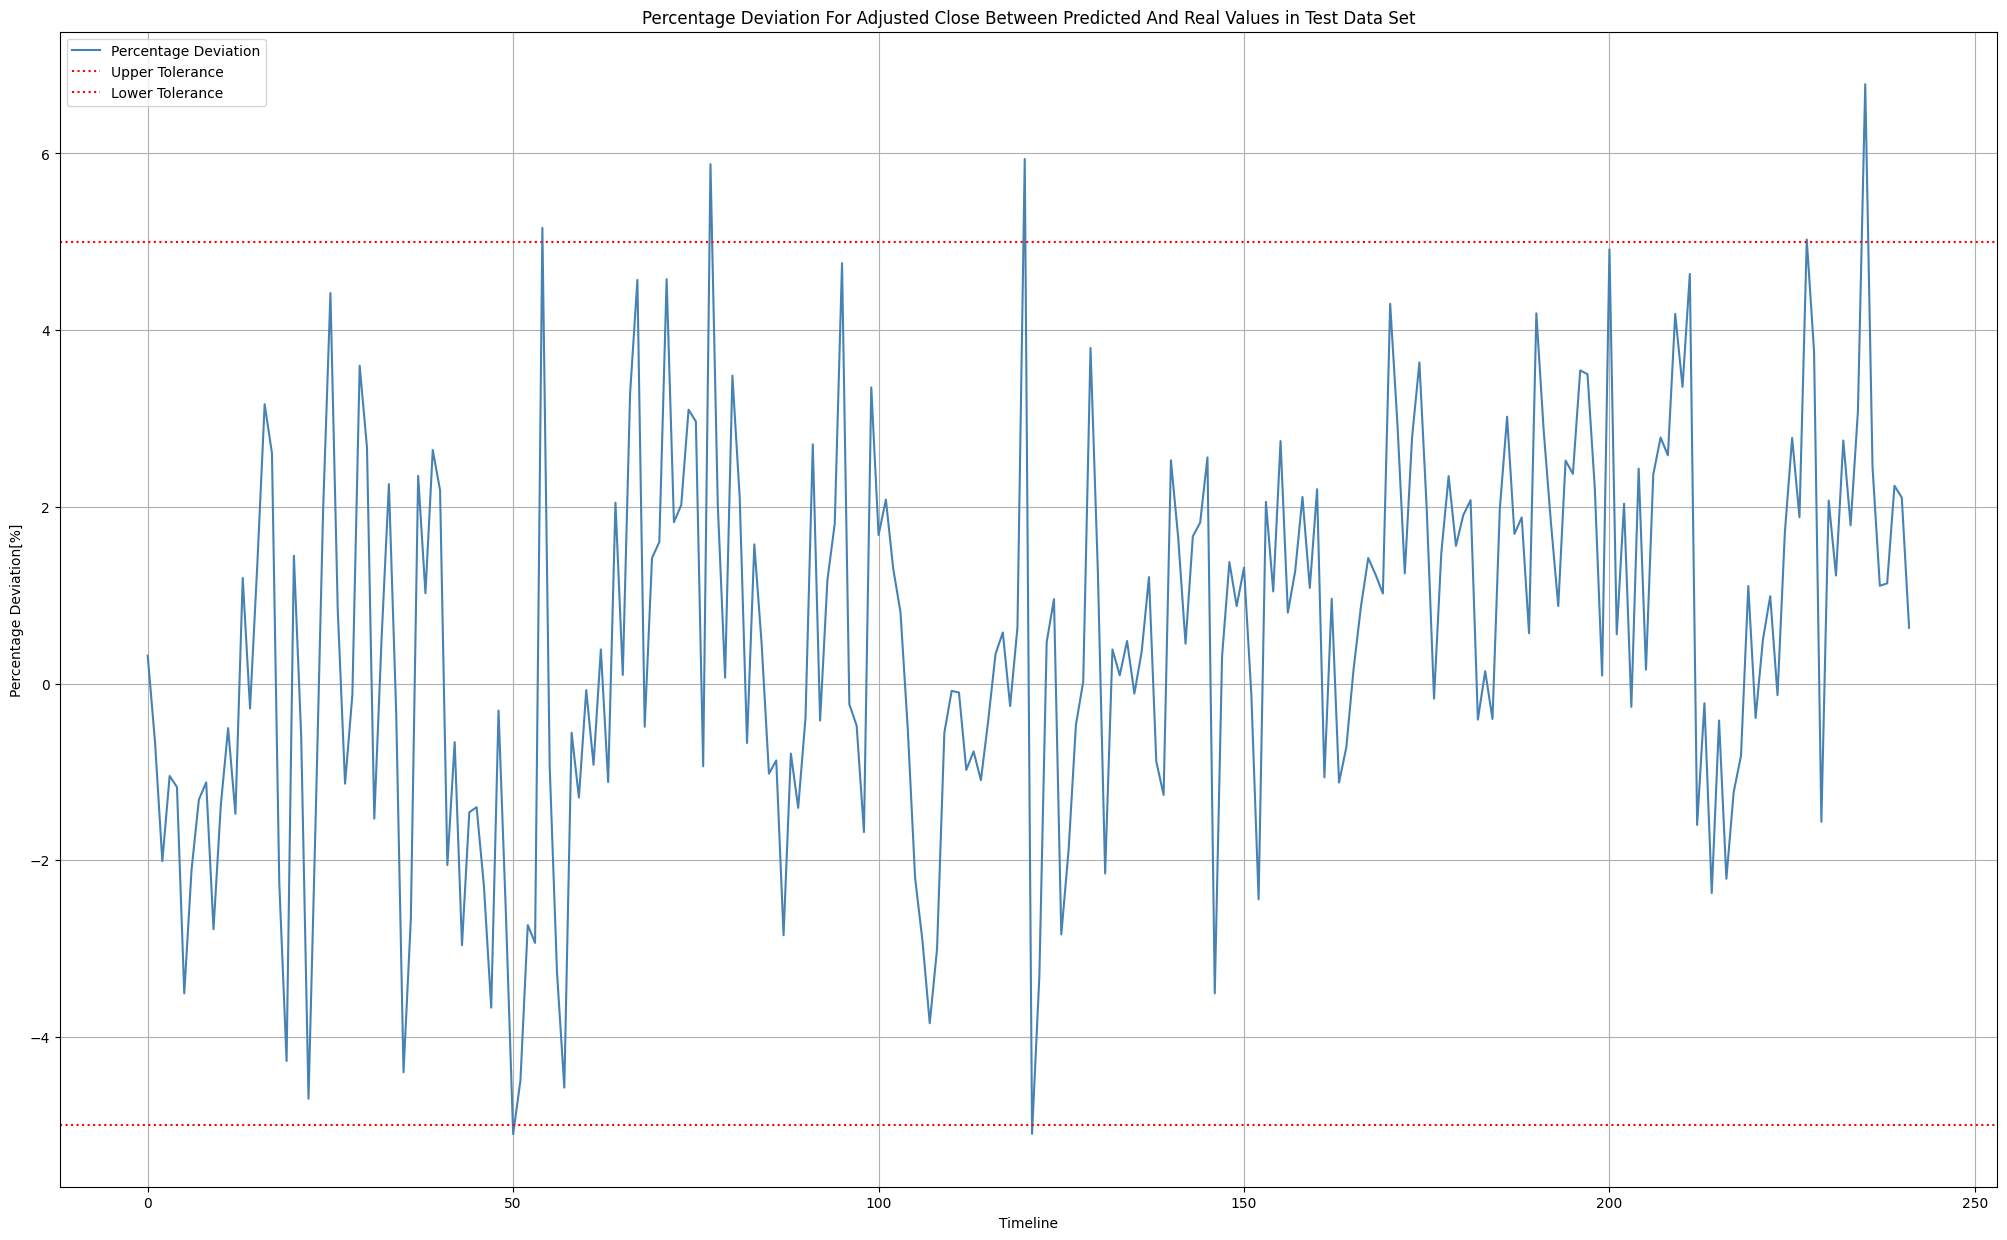

The mean for the percentage deviation in the test data is 0.5421614505352439.
-----------------------------------------


In [568]:
# showing the performance of the best model
model_validation(data, best_model)

The MSE is better in the model if the 17 features. But the model with the 6 features moves more in the tolerance. That's why I decision goes to the model with the 6 features.

## <a class="anchor" id="comparison"> 3. Comparison Stock Types </a>

In this chapter, I will do 20 trainings loops for all stocks and compare the prediction performance on the base of the stock type.

In [571]:
# load the data with 6 features
data = load_data('/Users/maximkiesel/PycharmProjects/Stock_Market_Prediction/data/cleaned_data.db')

In [572]:
def train_model(data, loops):
    '''
    Create new features (11) for the X dfs and clean potential Nan values.
    Adjusted the amount of y values.
    
    INPUT 
    data - (dict) Stock dfs with the new features
    loop - (int) Numbers of loops with randomized model parameter
      
    OUTPUT
    best_model - (dict) Stocks with following items:
    - 'model': Trained model
    - 'mse': Mean Squared Error for the best model
    - 'paramter': List of the parameter of the best model
    '''
    
    # define empty dict
    best_model = {}
    
    # define selection of parameters
    params = {
    'window_size': [4, 8, 12, 20],
    'lstm_units': [16, 32, 64, 128],
    'dense_units': [16, 32, 64, 128],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
    }
    
    # iterate through the stock names
    for name in data:
        
        # info printing
        print('Trained Stock: {}'.format(name))
        
        best_model[name] = {}
        
        # select the arrays
        df = data[name]
        
        # iterate through 
        for i in range(1,loops+1):
            
            # info printing
            print('Parameter run: {}'.format(i))
        
            random_params = {key: random.choice(values) for key, values in params.items()}
    
            # info printing
            print('Parameters: {}'.format(random_params))
    
            X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std = data_split(df, random_params['window_size'])

            # define the model for the stock JNJ
            model = Sequential()
            model.add(InputLayer((random_params['window_size'], X_train.shape[-1]))) # the first parameter is always the window size, the second the number of features
            model.add(LSTM(random_params['lstm_units']))
            model.add(Dense(random_params['dense_units'], 'relu'))
            model.add(Dense(X_train.shape[-1], 'linear')) # output of 17 features
            model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=random_params['learning_rate']), metrics=[RootMeanSquaredError()])
    
            # create a model checkpoint for the best model
            cp = ModelCheckpoint('model', save_best_only=True, verbose=0)
            
            # fitting the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=[cp], verbose=0)
    
            # load the best model
            model = load_model('model')
            
            # get the best mse from the best model
            best_mse = history.history['val_loss'][np.argmin(history.history['val_loss'])]
            
            # if this is the first window size, set the accuracy to the current percent difference
            if i == 1:
                
                best_model[name]['model'] = model
                best_model[name]['mse'] = best_mse
                best_model[name]['paramter'] = random_params
            
            # otherwise, compare the current accuracy to the previous best accuracy and update if necessary
            else:
                
                if best_model[name]['mse'] > best_mse:
                    
                    best_model[name]['model'] = model
                    best_model[name]['mse'] = best_mse
                    best_model[name]['paramter'] = random_params
                
                else:
                    
                    continue
        
    return best_model

In [573]:
# train the model with 17 features
best_model = train_model(data, 20)

Trained Stock: BMW.DE
Parameter run: 1
Parameters: {'window_size': 8, 'lstm_units': 128, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-05 22:43:14.634481: W tensorflow/c/c_api.cc:300] Operation '{name:'training_468/Adam/beta_1/Assign' id:284887 op device:{requested: '', assigned: ''} def:{{{node training_468/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_468/Adam/beta_1, training_468/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-05-05 22:43:19.823381: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_476/mul' id:284542 o

Parameter run: 2
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 32, 'learning_rate': 0.01}


2023-05-05 22:44:59.883806: W tensorflow/c/c_api.cc:300] Operation '{name:'training_470/Adam/beta_2/Assign' id:286105 op device:{requested: '', assigned: ''} def:{{{node training_470/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_470/Adam/beta_2, training_470/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:45:05.049500: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_478/mul' id:285755 op device:{requested: '', assigned: ''} def:{{{node loss_478/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_478/mul/x, loss_478/dense_501_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the futu

Parameter run: 3
Parameters: {'window_size': 12, 'lstm_units': 32, 'dense_units': 32, 'learning_rate': 0.0001}


2023-05-05 22:46:28.593086: W tensorflow/c/c_api.cc:300] Operation '{name:'training_472/Adam/decay/Assign' id:287307 op device:{requested: '', assigned: ''} def:{{{node training_472/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_472/Adam/decay, training_472/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:46:33.712756: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_480/mul' id:286952 op device:{requested: '', assigned: ''} def:{{{node loss_480/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_480/mul/x, loss_480/dense_503_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. 

Parameter run: 4
Parameters: {'window_size': 12, 'lstm_units': 64, 'dense_units': 16, 'learning_rate': 0.001}


2023-05-05 22:48:01.429345: W tensorflow/c/c_api.cc:300] Operation '{name:'training_474/Adam/dense_504/kernel/m/Assign' id:288543 op device:{requested: '', assigned: ''} def:{{{node training_474/Adam/dense_504/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_474/Adam/dense_504/kernel/m, training_474/Adam/dense_504/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:48:06.500037: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_482/mul' id:288157 op device:{requested: '', assigned: ''} def:{{{node loss_482/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_482/mul/x, loss_482/dense_505_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 5
Parameters: {'window_size': 8, 'lstm_units': 64, 'dense_units': 64, 'learning_rate': 0.001}


2023-05-05 22:49:32.659308: W tensorflow/c/c_api.cc:300] Operation '{name:'training_476/Adam/dense_506/bias/v/Assign' id:289802 op device:{requested: '', assigned: ''} def:{{{node training_476/Adam/dense_506/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_476/Adam/dense_506/bias/v, training_476/Adam/dense_506/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:49:37.803583: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_484/mul' id:289370 op device:{requested: '', assigned: ''} def:{{{node loss_484/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_484/mul/x, loss_484/dense_507_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 6
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 64, 'learning_rate': 0.01}


2023-05-05 22:50:59.799953: W tensorflow/c/c_api.cc:300] Operation '{name:'training_478/Adam/dense_508/bias/v/Assign' id:291011 op device:{requested: '', assigned: ''} def:{{{node training_478/Adam/dense_508/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_478/Adam/dense_508/bias/v, training_478/Adam/dense_508/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:51:04.924942: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_486/mul' id:290583 op device:{requested: '', assigned: ''} def:{{{node loss_486/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_486/mul/x, loss_486/dense_509_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 7
Parameters: {'window_size': 4, 'lstm_units': 16, 'dense_units': 64, 'learning_rate': 0.01}


2023-05-05 22:52:20.573417: W tensorflow/c/c_api.cc:300] Operation '{name:'training_480/Adam/lstm_255/lstm_cell_492/kernel/v/Assign' id:292192 op device:{requested: '', assigned: ''} def:{{{node training_480/Adam/lstm_255/lstm_cell_492/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_480/Adam/lstm_255/lstm_cell_492/kernel/v, training_480/Adam/lstm_255/lstm_cell_492/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:52:25.668802: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_488/mul' id:291788 op device:{requested: '', assigned: ''} def:{{{node loss_488/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_488/mul/x, loss_488/dense_511_loss/value)}}' was changed by setting attribute after it wa

Parameter run: 8
Parameters: {'window_size': 20, 'lstm_units': 16, 'dense_units': 16, 'learning_rate': 0.1}


2023-05-05 22:53:40.347000: W tensorflow/c/c_api.cc:300] Operation '{name:'training_482/Adam/dense_513/bias/m/Assign' id:293390 op device:{requested: '', assigned: ''} def:{{{node training_482/Adam/dense_513/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_482/Adam/dense_513/bias/m, training_482/Adam/dense_513/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:53:45.550290: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_490/mul' id:292993 op device:{requested: '', assigned: ''} def:{{{node loss_490/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_490/mul/x, loss_490/dense_513_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 9
Parameters: {'window_size': 12, 'lstm_units': 64, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-05 22:55:08.623835: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_257/lstm_cell_496/recurrent_kernel/Assign' id:293977 op device:{requested: '', assigned: ''} def:{{{node lstm_257/lstm_cell_496/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_257/lstm_cell_496/recurrent_kernel, lstm_257/lstm_cell_496/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:55:13.784416: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_492/mul' id:294190 op device:{requested: '', assigned: ''} def:{{{node loss_492/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_492/mul/x, loss_492/dense_515_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will h

Parameter run: 10
Parameters: {'window_size': 12, 'lstm_units': 16, 'dense_units': 32, 'learning_rate': 0.0001}


2023-05-05 22:56:42.572407: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_517/bias/Assign' id:295356 op device:{requested: '', assigned: ''} def:{{{node dense_517/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_517/bias, dense_517/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:56:47.691440: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_494/mul' id:295403 op device:{requested: '', assigned: ''} def:{{{node loss_494/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_494/mul/x, loss_494/dense_517_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them

Parameter run: 11
Parameters: {'window_size': 20, 'lstm_units': 16, 'dense_units': 128, 'learning_rate': 0.0001}


2023-05-05 22:58:17.339149: W tensorflow/c/c_api.cc:300] Operation '{name:'training_488/Adam/lstm_259/lstm_cell_500/kernel/v/Assign' id:297004 op device:{requested: '', assigned: ''} def:{{{node training_488/Adam/lstm_259/lstm_cell_500/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_488/Adam/lstm_259/lstm_cell_500/kernel/v, training_488/Adam/lstm_259/lstm_cell_500/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:58:22.563474: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_496/mul' id:296600 op device:{requested: '', assigned: ''} def:{{{node loss_496/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_496/mul/x, loss_496/dense_519_loss/value)}}' was changed by setting attribute after it wa

Parameter run: 12
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-05 22:59:53.906514: W tensorflow/c/c_api.cc:300] Operation '{name:'training_490/Adam/lstm_260/lstm_cell_502/recurrent_kernel/m/Assign' id:298177 op device:{requested: '', assigned: ''} def:{{{node training_490/Adam/lstm_260/lstm_cell_502/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_490/Adam/lstm_260/lstm_cell_502/recurrent_kernel/m, training_490/Adam/lstm_260/lstm_cell_502/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:59:59.109113: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_498/mul' id:297805 op device:{requested: '', assigned: ''} def:{{{node loss_498/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_498/mul/x, loss_498/dense_521_loss/value)}}' was 

Parameter run: 13
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 16, 'learning_rate': 0.1}


2023-05-05 23:01:25.949332: W tensorflow/c/c_api.cc:300] Operation '{name:'training_492/Adam/lstm_261/lstm_cell_504/kernel/v/Assign' id:299404 op device:{requested: '', assigned: ''} def:{{{node training_492/Adam/lstm_261/lstm_cell_504/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_492/Adam/lstm_261/lstm_cell_504/kernel/v, training_492/Adam/lstm_261/lstm_cell_504/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:01:31.102907: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_500/mul' id:299002 op device:{requested: '', assigned: ''} def:{{{node loss_500/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_500/mul/x, loss_500/dense_523_loss/value)}}' was changed by setting attribute after it wa

Parameter run: 14
Parameters: {'window_size': 12, 'lstm_units': 16, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-05 23:02:49.771404: W tensorflow/c/c_api.cc:300] Operation '{name:'training_494/Adam/dense_525/kernel/v/Assign' id:300628 op device:{requested: '', assigned: ''} def:{{{node training_494/Adam/dense_525/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_494/Adam/dense_525/kernel/v, training_494/Adam/dense_525/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:02:55.118673: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_502/mul' id:300199 op device:{requested: '', assigned: ''} def:{{{node loss_502/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_502/mul/x, loss_502/dense_525_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 15
Parameters: {'window_size': 8, 'lstm_units': 128, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-05 23:04:26.560673: W tensorflow/c/c_api.cc:300] Operation '{name:'training_496/Adam/lstm_263/lstm_cell_508/recurrent_kernel/v/Assign' id:301811 op device:{requested: '', assigned: ''} def:{{{node training_496/Adam/lstm_263/lstm_cell_508/recurrent_kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_496/Adam/lstm_263/lstm_cell_508/recurrent_kernel/v, training_496/Adam/lstm_263/lstm_cell_508/recurrent_kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:04:31.810791: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_504/mul' id:301396 op device:{requested: '', assigned: ''} def:{{{node loss_504/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_504/mul/x, loss_504/dense_527_loss/value)}}' was 

Parameter run: 16
Parameters: {'window_size': 8, 'lstm_units': 64, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-05 23:06:15.036873: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_264/lstm_cell_510/bias/Assign' id:302405 op device:{requested: '', assigned: ''} def:{{{node lstm_264/lstm_cell_510/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_264/lstm_cell_510/bias, lstm_264/lstm_cell_510/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:06:20.400976: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_506/mul' id:302609 op device:{requested: '', assigned: ''} def:{{{node loss_506/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_506/mul/x, loss_506/dense_529_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the

Parameter run: 17
Parameters: {'window_size': 4, 'lstm_units': 64, 'dense_units': 32, 'learning_rate': 0.1}


2023-05-05 23:07:49.828297: W tensorflow/c/c_api.cc:300] Operation '{name:'training_500/Adam/decay/Assign' id:304177 op device:{requested: '', assigned: ''} def:{{{node training_500/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_500/Adam/decay, training_500/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:07:55.196386: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_508/mul' id:303822 op device:{requested: '', assigned: ''} def:{{{node loss_508/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_508/mul/x, loss_508/dense_531_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. 

Parameter run: 18
Parameters: {'window_size': 8, 'lstm_units': 128, 'dense_units': 16, 'learning_rate': 0.001}


2023-05-05 23:09:18.500357: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_266/lstm_cell_514/recurrent_kernel/Assign' id:304822 op device:{requested: '', assigned: ''} def:{{{node lstm_266/lstm_cell_514/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_266/lstm_cell_514/recurrent_kernel, lstm_266/lstm_cell_514/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:09:23.859441: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_510/mul' id:305035 op device:{requested: '', assigned: ''} def:{{{node loss_510/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_510/mul/x, loss_510/dense_533_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will h

Parameter run: 19
Parameters: {'window_size': 20, 'lstm_units': 16, 'dense_units': 16, 'learning_rate': 0.001}


2023-05-05 23:11:07.431746: W tensorflow/c/c_api.cc:300] Operation '{name:'training_504/Adam/dense_534/bias/v/Assign' id:306672 op device:{requested: '', assigned: ''} def:{{{node training_504/Adam/dense_534/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_504/Adam/dense_534/bias/v, training_504/Adam/dense_534/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:11:12.780921: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_512/mul' id:306248 op device:{requested: '', assigned: ''} def:{{{node loss_512/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_512/mul/x, loss_512/dense_535_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 20
Parameters: {'window_size': 20, 'lstm_units': 128, 'dense_units': 16, 'learning_rate': 0.1}


2023-05-05 23:12:43.205016: W tensorflow/c/c_api.cc:300] Operation '{name:'training_506/Adam/dense_536/kernel/v/Assign' id:307872 op device:{requested: '', assigned: ''} def:{{{node training_506/Adam/dense_536/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_506/Adam/dense_536/kernel/v, training_506/Adam/dense_536/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:12:48.730874: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_514/mul' id:307445 op device:{requested: '', assigned: ''} def:{{{node loss_514/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_514/mul/x, loss_514/dense_537_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Trained Stock: BTC-USD
Parameter run: 1
Parameters: {'window_size': 8, 'lstm_units': 32, 'dense_units': 16, 'learning_rate': 0.1}


2023-05-05 23:14:55.891436: W tensorflow/c/c_api.cc:300] Operation '{name:'training_508/Adam/lstm_269/lstm_cell_520/recurrent_kernel/m/Assign' id:309030 op device:{requested: '', assigned: ''} def:{{{node training_508/Adam/lstm_269/lstm_cell_520/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_508/Adam/lstm_269/lstm_cell_520/recurrent_kernel/m, training_508/Adam/lstm_269/lstm_cell_520/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:15:01.429466: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_516/mul' id:308658 op device:{requested: '', assigned: ''} def:{{{node loss_516/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_516/mul/x, loss_516/dense_539_loss/value)}}' was 

Parameter run: 2
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 128, 'learning_rate': 0.0001}


2023-05-05 23:16:48.662507: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_270/lstm_cell_522/recurrent_kernel/Assign' id:309642 op device:{requested: '', assigned: ''} def:{{{node lstm_270/lstm_cell_522/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_270/lstm_cell_522/recurrent_kernel, lstm_270/lstm_cell_522/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:16:54.144841: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_518/mul' id:309855 op device:{requested: '', assigned: ''} def:{{{node loss_518/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_518/mul/x, loss_518/dense_541_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will h

Parameter run: 3
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 64, 'learning_rate': 0.0001}


2023-05-05 23:18:48.866717: W tensorflow/c/c_api.cc:300] Operation '{name:'training_512/Adam/dense_543/kernel/m/Assign' id:311454 op device:{requested: '', assigned: ''} def:{{{node training_512/Adam/dense_543/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_512/Adam/dense_543/kernel/m, training_512/Adam/dense_543/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:18:54.342988: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_520/mul' id:311060 op device:{requested: '', assigned: ''} def:{{{node loss_520/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_520/mul/x, loss_520/dense_543_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 4
Parameters: {'window_size': 20, 'lstm_units': 128, 'dense_units': 64, 'learning_rate': 0.01}


2023-05-05 23:20:46.072100: W tensorflow/c/c_api.cc:300] Operation '{name:'training_514/Adam/lstm_272/lstm_cell_526/kernel/m/Assign' id:312632 op device:{requested: '', assigned: ''} def:{{{node training_514/Adam/lstm_272/lstm_cell_526/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_514/Adam/lstm_272/lstm_cell_526/kernel/m, training_514/Adam/lstm_272/lstm_cell_526/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:20:51.869119: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_522/mul' id:312265 op device:{requested: '', assigned: ''} def:{{{node loss_522/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_522/mul/x, loss_522/dense_545_loss/value)}}' was changed by setting attribute after it wa

Parameter run: 5
Parameters: {'window_size': 4, 'lstm_units': 16, 'dense_units': 128, 'learning_rate': 0.01}


2023-05-05 23:23:41.299651: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_547/kernel/Assign' id:313426 op device:{requested: '', assigned: ''} def:{{{node dense_547/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_547/kernel, dense_547/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:23:46.837193: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_524/mul' id:313478 op device:{requested: '', assigned: ''} def:{{{node loss_524/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_524/mul/x, loss_524/dense_547_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes a

Parameter run: 6
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-05 23:25:35.544792: W tensorflow/c/c_api.cc:300] Operation '{name:'training_518/Adam/learning_rate/Assign' id:315043 op device:{requested: '', assigned: ''} def:{{{node training_518/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_518/Adam/learning_rate, training_518/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:25:41.166734: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_526/mul' id:314683 op device:{requested: '', assigned: ''} def:{{{node loss_526/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_526/mul/x, loss_526/dense_549_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will 

Parameter run: 7
Parameters: {'window_size': 4, 'lstm_units': 64, 'dense_units': 128, 'learning_rate': 0.1}


2023-05-05 23:27:35.826852: W tensorflow/c/c_api.cc:300] Operation '{name:'count_529/Assign' id:315847 op device:{requested: '', assigned: ''} def:{{{node count_529/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_529, count_529/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:27:41.401106: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_528/mul' id:315880 op device:{requested: '', assigned: ''} def:{{{node loss_528/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_528/mul/x, loss_528/dense_551_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Parameter run: 8
Parameters: {'window_size': 4, 'lstm_units': 16, 'dense_units': 32, 'learning_rate': 0.0001}


2023-05-05 23:29:32.910312: W tensorflow/c/c_api.cc:300] Operation '{name:'training_522/Adam/dense_553/kernel/m/Assign' id:317485 op device:{requested: '', assigned: ''} def:{{{node training_522/Adam/dense_553/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_522/Adam/dense_553/kernel/m, training_522/Adam/dense_553/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:29:38.494573: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_530/mul' id:317093 op device:{requested: '', assigned: ''} def:{{{node loss_530/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_530/mul/x, loss_530/dense_553_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 9
Parameters: {'window_size': 12, 'lstm_units': 128, 'dense_units': 64, 'learning_rate': 0.1}


2023-05-05 23:31:32.566837: W tensorflow/c/c_api.cc:300] Operation '{name:'training_524/Adam/dense_555/kernel/m/Assign' id:318686 op device:{requested: '', assigned: ''} def:{{{node training_524/Adam/dense_555/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_524/Adam/dense_555/kernel/m, training_524/Adam/dense_555/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:31:38.459417: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_532/mul' id:318290 op device:{requested: '', assigned: ''} def:{{{node loss_532/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_532/mul/x, loss_532/dense_555_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 10
Parameters: {'window_size': 4, 'lstm_units': 128, 'dense_units': 64, 'learning_rate': 0.1}


2023-05-05 23:34:08.937094: W tensorflow/c/c_api.cc:300] Operation '{name:'training_526/Adam/dense_557/bias/v/Assign' id:319945 op device:{requested: '', assigned: ''} def:{{{node training_526/Adam/dense_557/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_526/Adam/dense_557/bias/v, training_526/Adam/dense_557/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:34:14.628382: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_534/mul' id:319503 op device:{requested: '', assigned: ''} def:{{{node loss_534/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_534/mul/x, loss_534/dense_557_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 11
Parameters: {'window_size': 4, 'lstm_units': 128, 'dense_units': 16, 'learning_rate': 0.001}


2023-05-05 23:36:23.658923: W tensorflow/c/c_api.cc:300] Operation '{name:'training_528/Adam/lstm_279/lstm_cell_540/kernel/m/Assign' id:321083 op device:{requested: '', assigned: ''} def:{{{node training_528/Adam/lstm_279/lstm_cell_540/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_528/Adam/lstm_279/lstm_cell_540/kernel/m, training_528/Adam/lstm_279/lstm_cell_540/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:36:29.386423: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_536/mul' id:320716 op device:{requested: '', assigned: ''} def:{{{node loss_536/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_536/mul/x, loss_536/dense_559_loss/value)}}' was changed by setting attribute after it wa

Parameter run: 12
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 128, 'learning_rate': 0.1}


2023-05-05 23:38:40.108853: W tensorflow/c/c_api.cc:300] Operation '{name:'training_530/Adam/learning_rate/Assign' id:322289 op device:{requested: '', assigned: ''} def:{{{node training_530/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_530/Adam/learning_rate, training_530/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:38:45.892827: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_538/mul' id:321929 op device:{requested: '', assigned: ''} def:{{{node loss_538/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_538/mul/x, loss_538/dense_561_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will 

Parameter run: 13
Parameters: {'window_size': 20, 'lstm_units': 128, 'dense_units': 128, 'learning_rate': 0.0001}


2023-05-05 23:40:40.268869: W tensorflow/c/c_api.cc:300] Operation '{name:'training_532/Adam/dense_562/bias/m/Assign' id:323525 op device:{requested: '', assigned: ''} def:{{{node training_532/Adam/dense_562/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_532/Adam/dense_562/bias/m, training_532/Adam/dense_562/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:40:46.281912: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_540/mul' id:323134 op device:{requested: '', assigned: ''} def:{{{node loss_540/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_540/mul/x, loss_540/dense_563_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 14
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 32, 'learning_rate': 0.1}


2023-05-05 23:43:42.712718: W tensorflow/c/c_api.cc:300] Operation '{name:'training_534/Adam/dense_564/kernel/m/Assign' id:324731 op device:{requested: '', assigned: ''} def:{{{node training_534/Adam/dense_564/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_534/Adam/dense_564/kernel/m, training_534/Adam/dense_564/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:43:48.669685: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_542/mul' id:324347 op device:{requested: '', assigned: ''} def:{{{node loss_542/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_542/mul/x, loss_542/dense_565_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 15
Parameters: {'window_size': 20, 'lstm_units': 128, 'dense_units': 64, 'learning_rate': 0.0001}


2023-05-05 23:45:44.924772: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_566/bias/Assign' id:325484 op device:{requested: '', assigned: ''} def:{{{node dense_566/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_566/bias, dense_566/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:45:51.011108: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_544/mul' id:325552 op device:{requested: '', assigned: ''} def:{{{node loss_544/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_544/mul/x, loss_544/dense_567_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them

Parameter run: 16
Parameters: {'window_size': 20, 'lstm_units': 32, 'dense_units': 128, 'learning_rate': 0.1}


2023-05-05 23:48:48.721623: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_569/kernel/Assign' id:326713 op device:{requested: '', assigned: ''} def:{{{node dense_569/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_569/kernel, dense_569/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:48:54.622591: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_546/mul' id:326765 op device:{requested: '', assigned: ''} def:{{{node loss_546/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_546/mul/x, loss_546/dense_569_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes a

Parameter run: 17
Parameters: {'window_size': 20, 'lstm_units': 32, 'dense_units': 128, 'learning_rate': 0.0001}


2023-05-05 23:51:06.860032: W tensorflow/c/c_api.cc:300] Operation '{name:'training_540/Adam/lstm_285/lstm_cell_552/kernel/m/Assign' id:328335 op device:{requested: '', assigned: ''} def:{{{node training_540/Adam/lstm_285/lstm_cell_552/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_540/Adam/lstm_285/lstm_cell_552/kernel/m, training_540/Adam/lstm_285/lstm_cell_552/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:51:12.888124: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_548/mul' id:327970 op device:{requested: '', assigned: ''} def:{{{node loss_548/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_548/mul/x, loss_548/dense_571_loss/value)}}' was changed by setting attribute after it wa

Parameter run: 18
Parameters: {'window_size': 20, 'lstm_units': 16, 'dense_units': 64, 'learning_rate': 0.001}


2023-05-05 23:53:29.717136: W tensorflow/c/c_api.cc:300] Operation '{name:'training_542/Adam/lstm_286/lstm_cell_554/recurrent_kernel/m/Assign' id:329547 op device:{requested: '', assigned: ''} def:{{{node training_542/Adam/lstm_286/lstm_cell_554/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_542/Adam/lstm_286/lstm_cell_554/recurrent_kernel/m, training_542/Adam/lstm_286/lstm_cell_554/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:53:35.612514: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_550/mul' id:329175 op device:{requested: '', assigned: ''} def:{{{node loss_550/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_550/mul/x, loss_550/dense_573_loss/value)}}' was 

Parameter run: 19
Parameters: {'window_size': 12, 'lstm_units': 64, 'dense_units': 64, 'learning_rate': 0.01}


2023-05-05 23:55:44.814350: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_574/kernel/Assign' id:330307 op device:{requested: '', assigned: ''} def:{{{node dense_574/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_574/kernel, dense_574/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:55:50.962754: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_552/mul' id:330380 op device:{requested: '', assigned: ''} def:{{{node loss_552/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_552/mul/x, loss_552/dense_575_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes a

Parameter run: 20
Parameters: {'window_size': 20, 'lstm_units': 32, 'dense_units': 16, 'learning_rate': 0.1}


2023-05-05 23:57:59.815674: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_577/kernel/Assign' id:331541 op device:{requested: '', assigned: ''} def:{{{node dense_577/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_577/kernel, dense_577/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 23:58:05.741267: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_554/mul' id:331593 op device:{requested: '', assigned: ''} def:{{{node loss_554/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_554/mul/x, loss_554/dense_577_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes a

Trained Stock: ETSY
Parameter run: 1
Parameters: {'window_size': 4, 'lstm_units': 16, 'dense_units': 16, 'learning_rate': 0.01}


2023-05-06 00:00:15.010341: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_289/lstm_cell_560/recurrent_kernel/Assign' id:332577 op device:{requested: '', assigned: ''} def:{{{node lstm_289/lstm_cell_560/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_289/lstm_cell_560/recurrent_kernel, lstm_289/lstm_cell_560/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:00:20.918372: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_556/mul' id:332790 op device:{requested: '', assigned: ''} def:{{{node loss_556/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_556/mul/x, loss_556/dense_579_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will h

Parameter run: 2
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 128, 'learning_rate': 0.01}


2023-05-06 00:01:52.280362: W tensorflow/c/c_api.cc:300] Operation '{name:'training_550/Adam/lstm_290/lstm_cell_562/kernel/v/Assign' id:334391 op device:{requested: '', assigned: ''} def:{{{node training_550/Adam/lstm_290/lstm_cell_562/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_550/Adam/lstm_290/lstm_cell_562/kernel/v, training_550/Adam/lstm_290/lstm_cell_562/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:01:58.233587: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_558/mul' id:333987 op device:{requested: '', assigned: ''} def:{{{node loss_558/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_558/mul/x, loss_558/dense_581_loss/value)}}' was changed by setting attribute after it wa

Parameter run: 3
Parameters: {'window_size': 20, 'lstm_units': 128, 'dense_units': 32, 'learning_rate': 0.1}


2023-05-06 00:03:31.962128: W tensorflow/c/c_api.cc:300] Operation '{name:'training_552/Adam/dense_582/kernel/m/Assign' id:335578 op device:{requested: '', assigned: ''} def:{{{node training_552/Adam/dense_582/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_552/Adam/dense_582/kernel/m, training_552/Adam/dense_582/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:03:38.094827: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_560/mul' id:335192 op device:{requested: '', assigned: ''} def:{{{node loss_560/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_560/mul/x, loss_560/dense_583_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 4
Parameters: {'window_size': 12, 'lstm_units': 128, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-06 00:05:50.505296: W tensorflow/c/c_api.cc:300] Operation '{name:'training_554/Adam/lstm_292/lstm_cell_566/kernel/v/Assign' id:336813 op device:{requested: '', assigned: ''} def:{{{node training_554/Adam/lstm_292/lstm_cell_566/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_554/Adam/lstm_292/lstm_cell_566/kernel/v, training_554/Adam/lstm_292/lstm_cell_566/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:05:56.640057: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_562/mul' id:336405 op device:{requested: '', assigned: ''} def:{{{node loss_562/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_562/mul/x, loss_562/dense_585_loss/value)}}' was changed by setting attribute after it wa

Parameter run: 5
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 128, 'learning_rate': 0.0001}


2023-05-06 00:07:56.810754: W tensorflow/c/c_api.cc:300] Operation '{name:'training_556/Adam/dense_587/kernel/v/Assign' id:338051 op device:{requested: '', assigned: ''} def:{{{node training_556/Adam/dense_587/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_556/Adam/dense_587/kernel/v, training_556/Adam/dense_587/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:08:02.799804: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_564/mul' id:337618 op device:{requested: '', assigned: ''} def:{{{node loss_564/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_564/mul/x, loss_564/dense_587_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 6
Parameters: {'window_size': 4, 'lstm_units': 128, 'dense_units': 128, 'learning_rate': 0.1}


2023-05-06 00:09:47.289628: W tensorflow/c/c_api.cc:300] Operation '{name:'training_558/Adam/lstm_294/lstm_cell_570/kernel/m/Assign' id:339190 op device:{requested: '', assigned: ''} def:{{{node training_558/Adam/lstm_294/lstm_cell_570/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_558/Adam/lstm_294/lstm_cell_570/kernel/m, training_558/Adam/lstm_294/lstm_cell_570/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:09:53.381927: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_566/mul' id:338823 op device:{requested: '', assigned: ''} def:{{{node loss_566/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_566/mul/x, loss_566/dense_589_loss/value)}}' was changed by setting attribute after it wa

Parameter run: 7
Parameters: {'window_size': 4, 'lstm_units': 64, 'dense_units': 128, 'learning_rate': 0.0001}


2023-05-06 00:11:41.825298: W tensorflow/c/c_api.cc:300] Operation '{name:'total_569/Assign' id:339998 op device:{requested: '', assigned: ''} def:{{{node total_569/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_569, total_569/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:11:47.903199: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_568/mul' id:340036 op device:{requested: '', assigned: ''} def:{{{node loss_568/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_568/mul/x, loss_568/dense_591_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Parameter run: 8
Parameters: {'window_size': 8, 'lstm_units': 64, 'dense_units': 128, 'learning_rate': 0.1}


2023-05-06 00:13:32.037745: W tensorflow/c/c_api.cc:300] Operation '{name:'training_562/Adam/dense_593/kernel/v/Assign' id:341686 op device:{requested: '', assigned: ''} def:{{{node training_562/Adam/dense_593/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_562/Adam/dense_593/kernel/v, training_562/Adam/dense_593/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:13:38.101636: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_570/mul' id:341249 op device:{requested: '', assigned: ''} def:{{{node loss_570/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_570/mul/x, loss_570/dense_593_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 9
Parameters: {'window_size': 8, 'lstm_units': 32, 'dense_units': 32, 'learning_rate': 0.01}


2023-05-06 00:15:22.228174: W tensorflow/c/c_api.cc:300] Operation '{name:'training_564/Adam/dense_595/kernel/m/Assign' id:342856 op device:{requested: '', assigned: ''} def:{{{node training_564/Adam/dense_595/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_564/Adam/dense_595/kernel/m, training_564/Adam/dense_595/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:15:28.373063: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_572/mul' id:342462 op device:{requested: '', assigned: ''} def:{{{node loss_572/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_572/mul/x, loss_572/dense_595_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 10
Parameters: {'window_size': 20, 'lstm_units': 64, 'dense_units': 32, 'learning_rate': 0.01}


2023-05-06 00:17:07.798817: W tensorflow/c/c_api.cc:300] Operation '{name:'count_575/Assign' id:343634 op device:{requested: '', assigned: ''} def:{{{node count_575/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_575, count_575/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:17:13.928181: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_574/mul' id:343667 op device:{requested: '', assigned: ''} def:{{{node loss_574/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_574/mul/x, loss_574/dense_597_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Parameter run: 11
Parameters: {'window_size': 4, 'lstm_units': 64, 'dense_units': 32, 'learning_rate': 0.1}


2023-05-06 00:19:05.700589: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_598/bias/Assign' id:344812 op device:{requested: '', assigned: ''} def:{{{node dense_598/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_598/bias, dense_598/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:19:11.785551: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_576/mul' id:344880 op device:{requested: '', assigned: ''} def:{{{node loss_576/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_576/mul/x, loss_576/dense_599_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them

Parameter run: 12
Parameters: {'window_size': 20, 'lstm_units': 128, 'dense_units': 128, 'learning_rate': 0.01}


2023-05-06 00:20:52.331029: W tensorflow/c/c_api.cc:300] Operation '{name:'training_570/Adam/dense_600/kernel/v/Assign' id:346520 op device:{requested: '', assigned: ''} def:{{{node training_570/Adam/dense_600/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_570/Adam/dense_600/kernel/v, training_570/Adam/dense_600/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:20:58.724142: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_578/mul' id:346093 op device:{requested: '', assigned: ''} def:{{{node loss_578/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_578/mul/x, loss_578/dense_601_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 13
Parameters: {'window_size': 20, 'lstm_units': 32, 'dense_units': 32, 'learning_rate': 0.01}


2023-05-06 00:23:15.755763: W tensorflow/c/c_api.cc:300] Operation '{name:'training_572/Adam/iter/Assign' id:347646 op device:{requested: '', assigned: ''} def:{{{node training_572/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_572/Adam/iter, training_572/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:23:21.960359: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_580/mul' id:347306 op device:{requested: '', assigned: ''} def:{{{node loss_580/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_580/mul/x, loss_580/dense_603_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't

Parameter run: 14
Parameters: {'window_size': 20, 'lstm_units': 64, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-06 00:25:09.331260: W tensorflow/c/c_api.cc:300] Operation '{name:'training_574/Adam/learning_rate/Assign' id:348871 op device:{requested: '', assigned: ''} def:{{{node training_574/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_574/Adam/learning_rate, training_574/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:25:15.676200: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_582/mul' id:348511 op device:{requested: '', assigned: ''} def:{{{node loss_582/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_582/mul/x, loss_582/dense_605_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will 

Parameter run: 15
Parameters: {'window_size': 4, 'lstm_units': 128, 'dense_units': 16, 'learning_rate': 0.001}


2023-05-06 00:27:09.823298: W tensorflow/c/c_api.cc:300] Operation '{name:'training_576/Adam/dense_607/bias/m/Assign' id:350125 op device:{requested: '', assigned: ''} def:{{{node training_576/Adam/dense_607/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_576/Adam/dense_607/bias/m, training_576/Adam/dense_607/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:27:16.092061: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_584/mul' id:349724 op device:{requested: '', assigned: ''} def:{{{node loss_584/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_584/mul/x, loss_584/dense_607_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 16
Parameters: {'window_size': 4, 'lstm_units': 128, 'dense_units': 32, 'learning_rate': 0.01}


2023-05-06 00:29:08.400117: W tensorflow/c/c_api.cc:300] Operation '{name:'count_587/Assign' id:350904 op device:{requested: '', assigned: ''} def:{{{node count_587/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_587, count_587/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:29:14.678769: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_586/mul' id:350937 op device:{requested: '', assigned: ''} def:{{{node loss_586/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_586/mul/x, loss_586/dense_609_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Parameter run: 17
Parameters: {'window_size': 20, 'lstm_units': 16, 'dense_units': 32, 'learning_rate': 0.01}


2023-05-06 00:31:06.270744: W tensorflow/c/c_api.cc:300] Operation '{name:'training_580/Adam/decay/Assign' id:352505 op device:{requested: '', assigned: ''} def:{{{node training_580/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_580/Adam/decay, training_580/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:31:12.606792: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_588/mul' id:352150 op device:{requested: '', assigned: ''} def:{{{node loss_588/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_588/mul/x, loss_588/dense_611_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. 

Parameter run: 18
Parameters: {'window_size': 8, 'lstm_units': 128, 'dense_units': 128, 'learning_rate': 0.01}


2023-05-06 00:32:59.627763: W tensorflow/c/c_api.cc:300] Operation '{name:'training_582/Adam/beta_1/Assign' id:353692 op device:{requested: '', assigned: ''} def:{{{node training_582/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_582/Adam/beta_1, training_582/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:33:05.942457: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_590/mul' id:353347 op device:{requested: '', assigned: ''} def:{{{node loss_590/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_590/mul/x, loss_590/dense_613_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the futu

Parameter run: 19
Parameters: {'window_size': 4, 'lstm_units': 16, 'dense_units': 128, 'learning_rate': 0.0001}


2023-05-06 00:35:06.753643: W tensorflow/c/c_api.cc:300] Operation '{name:'training_584/Adam/dense_615/bias/m/Assign' id:354959 op device:{requested: '', assigned: ''} def:{{{node training_584/Adam/dense_615/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_584/Adam/dense_615/bias/m, training_584/Adam/dense_615/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:35:13.166361: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_592/mul' id:354560 op device:{requested: '', assigned: ''} def:{{{node loss_592/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_592/mul/x, loss_592/dense_615_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 20
Parameters: {'window_size': 4, 'lstm_units': 16, 'dense_units': 64, 'learning_rate': 0.01}


2023-05-06 00:37:05.406410: W tensorflow/c/c_api.cc:300] Operation '{name:'training_586/Adam/decay/Assign' id:356120 op device:{requested: '', assigned: ''} def:{{{node training_586/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_586/Adam/decay, training_586/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:37:11.966686: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_594/mul' id:355765 op device:{requested: '', assigned: ''} def:{{{node loss_594/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_594/mul/x, loss_594/dense_617_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. 

Trained Stock: JNJ
Parameter run: 1
Parameters: {'window_size': 4, 'lstm_units': 64, 'dense_units': 64, 'learning_rate': 0.01}


2023-05-06 00:38:54.982129: W tensorflow/c/c_api.cc:300] Operation '{name:'total_597/Assign' id:356932 op device:{requested: '', assigned: ''} def:{{{node total_597/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_597, total_597/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:39:01.486873: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_596/mul' id:356970 op device:{requested: '', assigned: ''} def:{{{node loss_596/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_596/mul/x, loss_596/dense_619_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Parameter run: 2
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 128, 'learning_rate': 0.1}


2023-05-06 00:40:45.862399: W tensorflow/c/c_api.cc:300] Operation '{name:'training_590/Adam/learning_rate/Assign' id:358543 op device:{requested: '', assigned: ''} def:{{{node training_590/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_590/Adam/learning_rate, training_590/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:40:52.293839: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_598/mul' id:358183 op device:{requested: '', assigned: ''} def:{{{node loss_598/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_598/mul/x, loss_598/dense_621_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will 

Parameter run: 3
Parameters: {'window_size': 8, 'lstm_units': 64, 'dense_units': 32, 'learning_rate': 0.01}


2023-05-06 00:42:35.453131: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_622/kernel/Assign' id:359315 op device:{requested: '', assigned: ''} def:{{{node dense_622/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_622/kernel, dense_622/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:42:41.872827: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_600/mul' id:359388 op device:{requested: '', assigned: ''} def:{{{node loss_600/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_600/mul/x, loss_600/dense_623_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes a

Parameter run: 4
Parameters: {'window_size': 12, 'lstm_units': 32, 'dense_units': 64, 'learning_rate': 0.001}


2023-05-06 00:44:30.239296: W tensorflow/c/c_api.cc:300] Operation '{name:'training_594/Adam/lstm_312/lstm_cell_606/bias/m/Assign' id:360978 op device:{requested: '', assigned: ''} def:{{{node training_594/Adam/lstm_312/lstm_cell_606/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_594/Adam/lstm_312/lstm_cell_606/bias/m, training_594/Adam/lstm_312/lstm_cell_606/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:44:36.734577: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_602/mul' id:360601 op device:{requested: '', assigned: ''} def:{{{node loss_602/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_602/mul/x, loss_602/dense_625_loss/value)}}' was changed by setting attribute after it was run by

Parameter run: 5
Parameters: {'window_size': 12, 'lstm_units': 128, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-06 00:46:26.196999: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_313/lstm_cell_608/kernel/Assign' id:361573 op device:{requested: '', assigned: ''} def:{{{node lstm_313/lstm_cell_608/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_313/lstm_cell_608/kernel, lstm_313/lstm_cell_608/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:46:32.701479: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_604/mul' id:361806 op device:{requested: '', assigned: ''} def:{{{node loss_604/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_604/mul/x, loss_604/dense_627_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger

Parameter run: 6
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-06 00:48:46.497701: W tensorflow/c/c_api.cc:300] Operation '{name:'training_598/Adam/dense_628/bias/v/Assign' id:363447 op device:{requested: '', assigned: ''} def:{{{node training_598/Adam/dense_628/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_598/Adam/dense_628/bias/v, training_598/Adam/dense_628/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:48:52.965977: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_606/mul' id:363019 op device:{requested: '', assigned: ''} def:{{{node loss_606/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_606/mul/x, loss_606/dense_629_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 7
Parameters: {'window_size': 12, 'lstm_units': 64, 'dense_units': 128, 'learning_rate': 0.0001}


2023-05-06 00:50:38.606768: W tensorflow/c/c_api.cc:300] Operation '{name:'training_600/Adam/dense_631/bias/m/Assign' id:364625 op device:{requested: '', assigned: ''} def:{{{node training_600/Adam/dense_631/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_600/Adam/dense_631/bias/m, training_600/Adam/dense_631/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:50:45.155834: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_608/mul' id:364224 op device:{requested: '', assigned: ''} def:{{{node loss_608/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_608/mul/x, loss_608/dense_631_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 8
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 32, 'learning_rate': 0.001}


2023-05-06 00:52:44.162695: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_316/lstm_cell_614/kernel/Assign' id:365204 op device:{requested: '', assigned: ''} def:{{{node lstm_316/lstm_cell_614/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_316/lstm_cell_614/kernel, lstm_316/lstm_cell_614/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:52:50.705443: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_610/mul' id:365437 op device:{requested: '', assigned: ''} def:{{{node loss_610/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_610/mul/x, loss_610/dense_633_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger

Parameter run: 9
Parameters: {'window_size': 12, 'lstm_units': 32, 'dense_units': 64, 'learning_rate': 0.1}


2023-05-06 00:54:39.576790: W tensorflow/c/c_api.cc:300] Operation '{name:'training_604/Adam/lstm_317/lstm_cell_616/kernel/m/Assign' id:366999 op device:{requested: '', assigned: ''} def:{{{node training_604/Adam/lstm_317/lstm_cell_616/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_604/Adam/lstm_317/lstm_cell_616/kernel/m, training_604/Adam/lstm_317/lstm_cell_616/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:54:46.174981: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_612/mul' id:366634 op device:{requested: '', assigned: ''} def:{{{node loss_612/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_612/mul/x, loss_612/dense_635_loss/value)}}' was changed by setting attribute after it wa

Parameter run: 10
Parameters: {'window_size': 4, 'lstm_units': 128, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-06 00:56:35.475177: W tensorflow/c/c_api.cc:300] Operation '{name:'training_606/Adam/dense_637/bias/v/Assign' id:368281 op device:{requested: '', assigned: ''} def:{{{node training_606/Adam/dense_637/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_606/Adam/dense_637/bias/v, training_606/Adam/dense_637/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:56:42.040796: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_614/mul' id:367839 op device:{requested: '', assigned: ''} def:{{{node loss_614/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_614/mul/x, loss_614/dense_637_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 11
Parameters: {'window_size': 12, 'lstm_units': 16, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-06 00:58:45.955404: W tensorflow/c/c_api.cc:300] Operation '{name:'training_608/Adam/decay/Assign' id:369407 op device:{requested: '', assigned: ''} def:{{{node training_608/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_608/Adam/decay, training_608/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 00:58:52.611866: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_616/mul' id:369052 op device:{requested: '', assigned: ''} def:{{{node loss_616/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_616/mul/x, loss_616/dense_639_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. 

Parameter run: 12
Parameters: {'window_size': 4, 'lstm_units': 64, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-06 01:00:43.450480: W tensorflow/c/c_api.cc:300] Operation '{name:'training_610/Adam/dense_641/kernel/v/Assign' id:370694 op device:{requested: '', assigned: ''} def:{{{node training_610/Adam/dense_641/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_610/Adam/dense_641/kernel/v, training_610/Adam/dense_641/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:00:50.128508: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_618/mul' id:370257 op device:{requested: '', assigned: ''} def:{{{node loss_618/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_618/mul/x, loss_618/dense_641_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 13
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 64, 'learning_rate': 0.001}


2023-05-06 01:02:39.679646: W tensorflow/c/c_api.cc:300] Operation '{name:'training_612/Adam/lstm_321/lstm_cell_624/bias/v/Assign' id:371886 op device:{requested: '', assigned: ''} def:{{{node training_612/Adam/lstm_321/lstm_cell_624/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_612/Adam/lstm_321/lstm_cell_624/bias/v, training_612/Adam/lstm_321/lstm_cell_624/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:02:46.262400: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_620/mul' id:371470 op device:{requested: '', assigned: ''} def:{{{node loss_620/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_620/mul/x, loss_620/dense_643_loss/value)}}' was changed by setting attribute after it was run by

Parameter run: 14
Parameters: {'window_size': 20, 'lstm_units': 32, 'dense_units': 32, 'learning_rate': 0.0001}


2023-05-06 01:04:36.799759: W tensorflow/c/c_api.cc:300] Operation '{name:'training_614/Adam/dense_644/kernel/m/Assign' id:373059 op device:{requested: '', assigned: ''} def:{{{node training_614/Adam/dense_644/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_614/Adam/dense_644/kernel/m, training_614/Adam/dense_644/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:04:43.625374: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_622/mul' id:372675 op device:{requested: '', assigned: ''} def:{{{node loss_622/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_622/mul/x, loss_622/dense_645_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 15
Parameters: {'window_size': 20, 'lstm_units': 16, 'dense_units': 64, 'learning_rate': 0.0001}


2023-05-06 01:06:50.139549: W tensorflow/c/c_api.cc:300] Operation '{name:'training_616/Adam/decay/Assign' id:374235 op device:{requested: '', assigned: ''} def:{{{node training_616/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_616/Adam/decay, training_616/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:06:56.786395: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_624/mul' id:373880 op device:{requested: '', assigned: ''} def:{{{node loss_624/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_624/mul/x, loss_624/dense_647_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. 

Parameter run: 16
Parameters: {'window_size': 20, 'lstm_units': 32, 'dense_units': 16, 'learning_rate': 0.01}


2023-05-06 01:08:59.241216: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_324/lstm_cell_630/kernel/Assign' id:374852 op device:{requested: '', assigned: ''} def:{{{node lstm_324/lstm_cell_630/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_324/lstm_cell_630/kernel, lstm_324/lstm_cell_630/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:09:06.055008: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_626/mul' id:375085 op device:{requested: '', assigned: ''} def:{{{node loss_626/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_626/mul/x, loss_626/dense_649_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger

Parameter run: 17
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 32, 'learning_rate': 0.01}


2023-05-06 01:11:03.758188: W tensorflow/c/c_api.cc:300] Operation '{name:'training_620/Adam/dense_650/bias/v/Assign' id:376710 op device:{requested: '', assigned: ''} def:{{{node training_620/Adam/dense_650/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_620/Adam/dense_650/bias/v, training_620/Adam/dense_650/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:11:10.370625: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_628/mul' id:376282 op device:{requested: '', assigned: ''} def:{{{node loss_628/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_628/mul/x, loss_628/dense_651_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 18
Parameters: {'window_size': 12, 'lstm_units': 32, 'dense_units': 32, 'learning_rate': 0.1}


2023-05-06 01:12:58.499167: W tensorflow/c/c_api.cc:300] Operation '{name:'training_622/Adam/lstm_326/lstm_cell_634/recurrent_kernel/m/Assign' id:377859 op device:{requested: '', assigned: ''} def:{{{node training_622/Adam/lstm_326/lstm_cell_634/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_622/Adam/lstm_326/lstm_cell_634/recurrent_kernel/m, training_622/Adam/lstm_326/lstm_cell_634/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:13:05.247651: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_630/mul' id:377487 op device:{requested: '', assigned: ''} def:{{{node loss_630/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_630/mul/x, loss_630/dense_653_loss/value)}}' was 

Parameter run: 19
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 64, 'learning_rate': 0.01}


2023-05-06 01:14:58.762156: W tensorflow/c/c_api.cc:300] Operation '{name:'training_624/Adam/lstm_327/lstm_cell_636/recurrent_kernel/m/Assign' id:379064 op device:{requested: '', assigned: ''} def:{{{node training_624/Adam/lstm_327/lstm_cell_636/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_624/Adam/lstm_327/lstm_cell_636/recurrent_kernel/m, training_624/Adam/lstm_327/lstm_cell_636/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:15:05.537706: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_632/mul' id:378692 op device:{requested: '', assigned: ''} def:{{{node loss_632/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_632/mul/x, loss_632/dense_655_loss/value)}}' was 

Parameter run: 20
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 32, 'learning_rate': 0.1}


2023-05-06 01:16:56.242900: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_328/lstm_cell_638/recurrent_kernel/Assign' id:379684 op device:{requested: '', assigned: ''} def:{{{node lstm_328/lstm_cell_638/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_328/lstm_cell_638/recurrent_kernel, lstm_328/lstm_cell_638/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:17:03.027575: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_634/mul' id:379897 op device:{requested: '', assigned: ''} def:{{{node loss_634/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_634/mul/x, loss_634/dense_657_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will h

Trained Stock: TSLA
Parameter run: 1
Parameters: {'window_size': 12, 'lstm_units': 128, 'dense_units': 64, 'learning_rate': 0.01}


2023-05-06 01:18:54.279341: W tensorflow/c/c_api.cc:300] Operation '{name:'training_628/Adam/iter/Assign' id:381434 op device:{requested: '', assigned: ''} def:{{{node training_628/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_628/Adam/iter, training_628/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:19:01.133298: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_636/mul' id:381094 op device:{requested: '', assigned: ''} def:{{{node loss_636/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_636/mul/x, loss_636/dense_659_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't

Parameter run: 2
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 16, 'learning_rate': 0.001}


2023-05-06 01:21:15.295491: W tensorflow/c/c_api.cc:300] Operation '{name:'training_630/Adam/lstm_330/lstm_cell_642/recurrent_kernel/m/Assign' id:382679 op device:{requested: '', assigned: ''} def:{{{node training_630/Adam/lstm_330/lstm_cell_642/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_630/Adam/lstm_330/lstm_cell_642/recurrent_kernel/m, training_630/Adam/lstm_330/lstm_cell_642/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:21:22.165315: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_638/mul' id:382307 op device:{requested: '', assigned: ''} def:{{{node loss_638/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_638/mul/x, loss_638/dense_661_loss/value)}}' was 

Parameter run: 3
Parameters: {'window_size': 8, 'lstm_units': 32, 'dense_units': 16, 'learning_rate': 0.1}


2023-05-06 01:23:22.337577: W tensorflow/c/c_api.cc:300] Operation '{name:'training_632/Adam/dense_662/bias/m/Assign' id:383891 op device:{requested: '', assigned: ''} def:{{{node training_632/Adam/dense_662/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_632/Adam/dense_662/bias/m, training_632/Adam/dense_662/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:23:29.513466: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_640/mul' id:383504 op device:{requested: '', assigned: ''} def:{{{node loss_640/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_640/mul/x, loss_640/dense_663_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 4
Parameters: {'window_size': 4, 'lstm_units': 128, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-06 01:25:24.172842: W tensorflow/c/c_api.cc:300] Operation '{name:'training_634/Adam/dense_664/bias/m/Assign' id:385092 op device:{requested: '', assigned: ''} def:{{{node training_634/Adam/dense_664/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_634/Adam/dense_664/bias/m, training_634/Adam/dense_664/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:25:31.396891: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_642/mul' id:384701 op device:{requested: '', assigned: ''} def:{{{node loss_642/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_642/mul/x, loss_642/dense_665_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 5
Parameters: {'window_size': 12, 'lstm_units': 64, 'dense_units': 32, 'learning_rate': 0.01}


2023-05-06 01:27:42.411025: W tensorflow/c/c_api.cc:300] Operation '{name:'training_636/Adam/lstm_333/lstm_cell_648/recurrent_kernel/m/Assign' id:386288 op device:{requested: '', assigned: ''} def:{{{node training_636/Adam/lstm_333/lstm_cell_648/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_636/Adam/lstm_333/lstm_cell_648/recurrent_kernel/m, training_636/Adam/lstm_333/lstm_cell_648/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:27:49.547207: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_644/mul' id:385914 op device:{requested: '', assigned: ''} def:{{{node loss_644/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_644/mul/x, loss_644/dense_667_loss/value)}}' was 

Parameter run: 6
Parameters: {'window_size': 4, 'lstm_units': 128, 'dense_units': 64, 'learning_rate': 0.0001}


2023-05-06 01:29:51.287311: W tensorflow/c/c_api.cc:300] Operation '{name:'count_647/Assign' id:387094 op device:{requested: '', assigned: ''} def:{{{node count_647/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_647, count_647/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:29:58.137562: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_646/mul' id:387127 op device:{requested: '', assigned: ''} def:{{{node loss_646/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_646/mul/x, loss_646/dense_669_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Parameter run: 7
Parameters: {'window_size': 20, 'lstm_units': 128, 'dense_units': 128, 'learning_rate': 0.01}


2023-05-06 01:32:07.468722: W tensorflow/c/c_api.cc:300] Operation '{name:'training_640/Adam/lstm_335/lstm_cell_652/bias/v/Assign' id:388760 op device:{requested: '', assigned: ''} def:{{{node training_640/Adam/lstm_335/lstm_cell_652/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_640/Adam/lstm_335/lstm_cell_652/bias/v, training_640/Adam/lstm_335/lstm_cell_652/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:32:14.666075: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_648/mul' id:388340 op device:{requested: '', assigned: ''} def:{{{node loss_648/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_648/mul/x, loss_648/dense_671_loss/value)}}' was changed by setting attribute after it was run by

Parameter run: 8
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 16, 'learning_rate': 0.01}


2023-05-06 01:34:46.120514: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_673/kernel/Assign' id:389501 op device:{requested: '', assigned: ''} def:{{{node dense_673/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_673/kernel, dense_673/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:34:53.210099: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_650/mul' id:389553 op device:{requested: '', assigned: ''} def:{{{node loss_650/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_650/mul/x, loss_650/dense_673_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes a

Parameter run: 9
Parameters: {'window_size': 12, 'lstm_units': 128, 'dense_units': 64, 'learning_rate': 0.001}


2023-05-06 01:36:48.667711: W tensorflow/c/c_api.cc:300] Operation '{name:'training_644/Adam/dense_675/bias/m/Assign' id:391151 op device:{requested: '', assigned: ''} def:{{{node training_644/Adam/dense_675/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_644/Adam/dense_675/bias/m, training_644/Adam/dense_675/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:36:55.770893: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_652/mul' id:390750 op device:{requested: '', assigned: ''} def:{{{node loss_652/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_652/mul/x, loss_652/dense_675_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 10
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 32, 'learning_rate': 0.0001}


2023-05-06 01:39:13.608686: W tensorflow/c/c_api.cc:300] Operation '{name:'total_655/Assign' id:391925 op device:{requested: '', assigned: ''} def:{{{node total_655/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_655, total_655/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:39:20.910568: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_654/mul' id:391963 op device:{requested: '', assigned: ''} def:{{{node loss_654/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_654/mul/x, loss_654/dense_677_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Parameter run: 11
Parameters: {'window_size': 4, 'lstm_units': 64, 'dense_units': 64, 'learning_rate': 0.1}


2023-05-06 01:41:30.728483: W tensorflow/c/c_api.cc:300] Operation '{name:'training_648/Adam/dense_679/kernel/v/Assign' id:393605 op device:{requested: '', assigned: ''} def:{{{node training_648/Adam/dense_679/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_648/Adam/dense_679/kernel/v, training_648/Adam/dense_679/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:41:37.814084: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_656/mul' id:393168 op device:{requested: '', assigned: ''} def:{{{node loss_656/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_656/mul/x, loss_656/dense_679_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 12
Parameters: {'window_size': 8, 'lstm_units': 64, 'dense_units': 64, 'learning_rate': 0.001}


2023-05-06 01:43:36.913196: W tensorflow/c/c_api.cc:300] Operation '{name:'training_650/Adam/lstm_340/lstm_cell_662/kernel/v/Assign' id:394789 op device:{requested: '', assigned: ''} def:{{{node training_650/Adam/lstm_340/lstm_cell_662/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_650/Adam/lstm_340/lstm_cell_662/kernel/v, training_650/Adam/lstm_340/lstm_cell_662/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:43:43.952872: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_658/mul' id:394381 op device:{requested: '', assigned: ''} def:{{{node loss_658/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_658/mul/x, loss_658/dense_681_loss/value)}}' was changed by setting attribute after it wa

Parameter run: 13
Parameters: {'window_size': 12, 'lstm_units': 128, 'dense_units': 64, 'learning_rate': 0.001}


2023-05-06 01:45:46.423608: W tensorflow/c/c_api.cc:300] Operation '{name:'training_652/Adam/lstm_341/lstm_cell_664/bias/m/Assign' id:395973 op device:{requested: '', assigned: ''} def:{{{node training_652/Adam/lstm_341/lstm_cell_664/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_652/Adam/lstm_341/lstm_cell_664/bias/m, training_652/Adam/lstm_341/lstm_cell_664/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:45:53.613783: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_660/mul' id:395594 op device:{requested: '', assigned: ''} def:{{{node loss_660/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_660/mul/x, loss_660/dense_683_loss/value)}}' was changed by setting attribute after it was run by

Parameter run: 14
Parameters: {'window_size': 12, 'lstm_units': 16, 'dense_units': 128, 'learning_rate': 0.0001}


2023-05-06 01:48:13.252797: W tensorflow/c/c_api.cc:300] Operation '{name:'training_654/Adam/dense_684/bias/m/Assign' id:397196 op device:{requested: '', assigned: ''} def:{{{node training_654/Adam/dense_684/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_654/Adam/dense_684/bias/m, training_654/Adam/dense_684/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:48:20.316120: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_662/mul' id:396807 op device:{requested: '', assigned: ''} def:{{{node loss_662/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_662/mul/x, loss_662/dense_685_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 15
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-06 01:50:32.281202: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_687/bias/Assign' id:397965 op device:{requested: '', assigned: ''} def:{{{node dense_687/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_687/bias, dense_687/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:50:39.405228: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_664/mul' id:398012 op device:{requested: '', assigned: ''} def:{{{node loss_664/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_664/mul/x, loss_664/dense_687_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them

Parameter run: 16
Parameters: {'window_size': 4, 'lstm_units': 32, 'dense_units': 64, 'learning_rate': 0.001}


2023-05-06 01:52:50.836622: W tensorflow/c/c_api.cc:300] Operation '{name:'training_658/Adam/dense_689/kernel/v/Assign' id:399642 op device:{requested: '', assigned: ''} def:{{{node training_658/Adam/dense_689/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_658/Adam/dense_689/kernel/v, training_658/Adam/dense_689/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:52:57.993986: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_666/mul' id:399209 op device:{requested: '', assigned: ''} def:{{{node loss_666/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_666/mul/x, loss_666/dense_689_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

Parameter run: 17
Parameters: {'window_size': 20, 'lstm_units': 64, 'dense_units': 64, 'learning_rate': 0.1}


2023-05-06 01:55:00.769373: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_691/bias/Assign' id:400367 op device:{requested: '', assigned: ''} def:{{{node dense_691/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_691/bias, dense_691/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:55:07.949715: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_668/mul' id:400414 op device:{requested: '', assigned: ''} def:{{{node loss_668/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_668/mul/x, loss_668/dense_691_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them

Parameter run: 18
Parameters: {'window_size': 20, 'lstm_units': 16, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-06 01:57:19.657531: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_346/lstm_cell_674/kernel/Assign' id:401394 op device:{requested: '', assigned: ''} def:{{{node lstm_346/lstm_cell_674/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_346/lstm_cell_674/kernel, lstm_346/lstm_cell_674/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:57:26.974024: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_670/mul' id:401627 op device:{requested: '', assigned: ''} def:{{{node loss_670/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_670/mul/x, loss_670/dense_693_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger

Parameter run: 19
Parameters: {'window_size': 20, 'lstm_units': 16, 'dense_units': 64, 'learning_rate': 0.1}


2023-05-06 01:59:43.932933: W tensorflow/c/c_api.cc:300] Operation '{name:'training_664/Adam/dense_694/bias/v/Assign' id:403252 op device:{requested: '', assigned: ''} def:{{{node training_664/Adam/dense_694/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_664/Adam/dense_694/bias/v, training_664/Adam/dense_694/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 01:59:51.235110: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_672/mul' id:402824 op device:{requested: '', assigned: ''} def:{{{node loss_672/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_672/mul/x, loss_672/dense_695_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 20
Parameters: {'window_size': 20, 'lstm_units': 32, 'dense_units': 64, 'learning_rate': 0.0001}


2023-05-06 02:01:57.519332: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_348/lstm_cell_678/kernel/Assign' id:403796 op device:{requested: '', assigned: ''} def:{{{node lstm_348/lstm_cell_678/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_348/lstm_cell_678/kernel, lstm_348/lstm_cell_678/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 02:02:05.087969: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_674/mul' id:404029 op device:{requested: '', assigned: ''} def:{{{node loss_674/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_674/mul/x, loss_674/dense_697_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger

In [574]:
# show the best model components 
best_model

{'BMW.DE': {'model': <keras.engine.sequential.Sequential at 0x357344a90>,
  'mse': 0.14654854410573057,
  'paramter': {'window_size': 4,
   'lstm_units': 16,
   'dense_units': 64,
   'learning_rate': 0.01}},
 'BTC-USD': {'model': <keras.engine.sequential.Sequential at 0x367c285e0>,
  'mse': 0.1201834103242182,
  'paramter': {'window_size': 4,
   'lstm_units': 128,
   'dense_units': 16,
   'learning_rate': 0.001}},
 'ETSY': {'model': <keras.engine.sequential.Sequential at 0x378461a20>,
  'mse': 0.12754830215202928,
  'paramter': {'window_size': 20,
   'lstm_units': 128,
   'dense_units': 128,
   'learning_rate': 0.01}},
 'JNJ': {'model': <keras.engine.sequential.Sequential at 0x38a6d8af0>,
  'mse': 0.1740390020461122,
  'paramter': {'window_size': 20,
   'lstm_units': 32,
   'dense_units': 16,
   'learning_rate': 0.01}},
 'TSLA': {'model': <keras.engine.sequential.Sequential at 0x38f387fa0>,
  'mse': 0.1457868427282474,
  'paramter': {'window_size': 12,
   'lstm_units': 128,
   'dense_u

######################
BMW.DE
######################
       Test Predictions     Actuals        diff       diff%
count        248.000000  248.000000  248.000000  248.000000
mean          83.796654   84.207137   -0.410483   -0.485011
std            9.908976    9.851573    1.459304    1.792850
min           67.958259   69.129997   -4.510921   -5.573587
25%           76.429626   76.412504   -1.307019   -1.527418
50%           80.649949   81.674999   -0.498008   -0.581127
75%           91.849788   92.349998    0.450095    0.541612
max          103.224938  104.099998    4.014437    5.540211


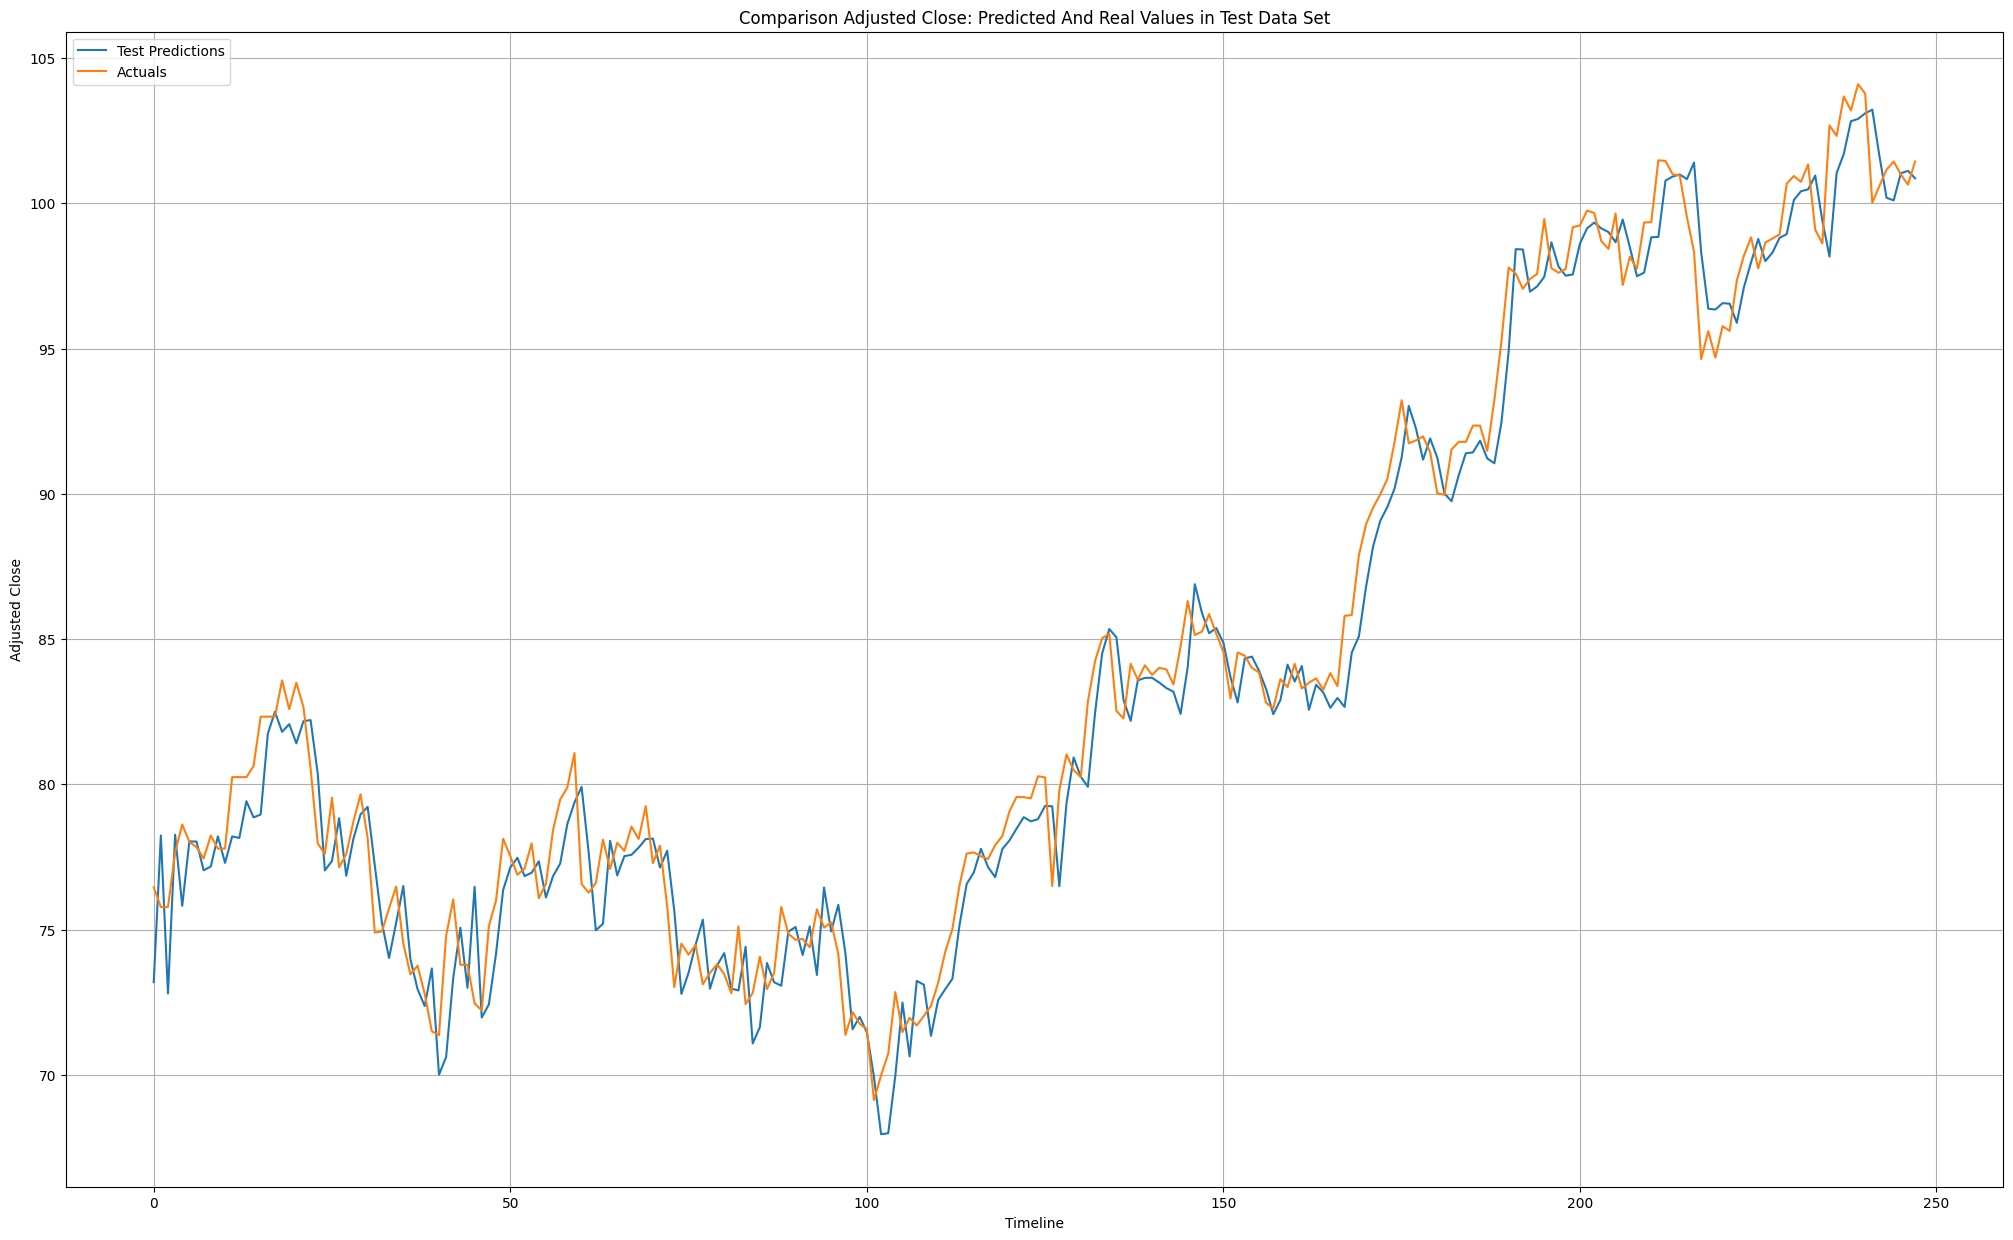

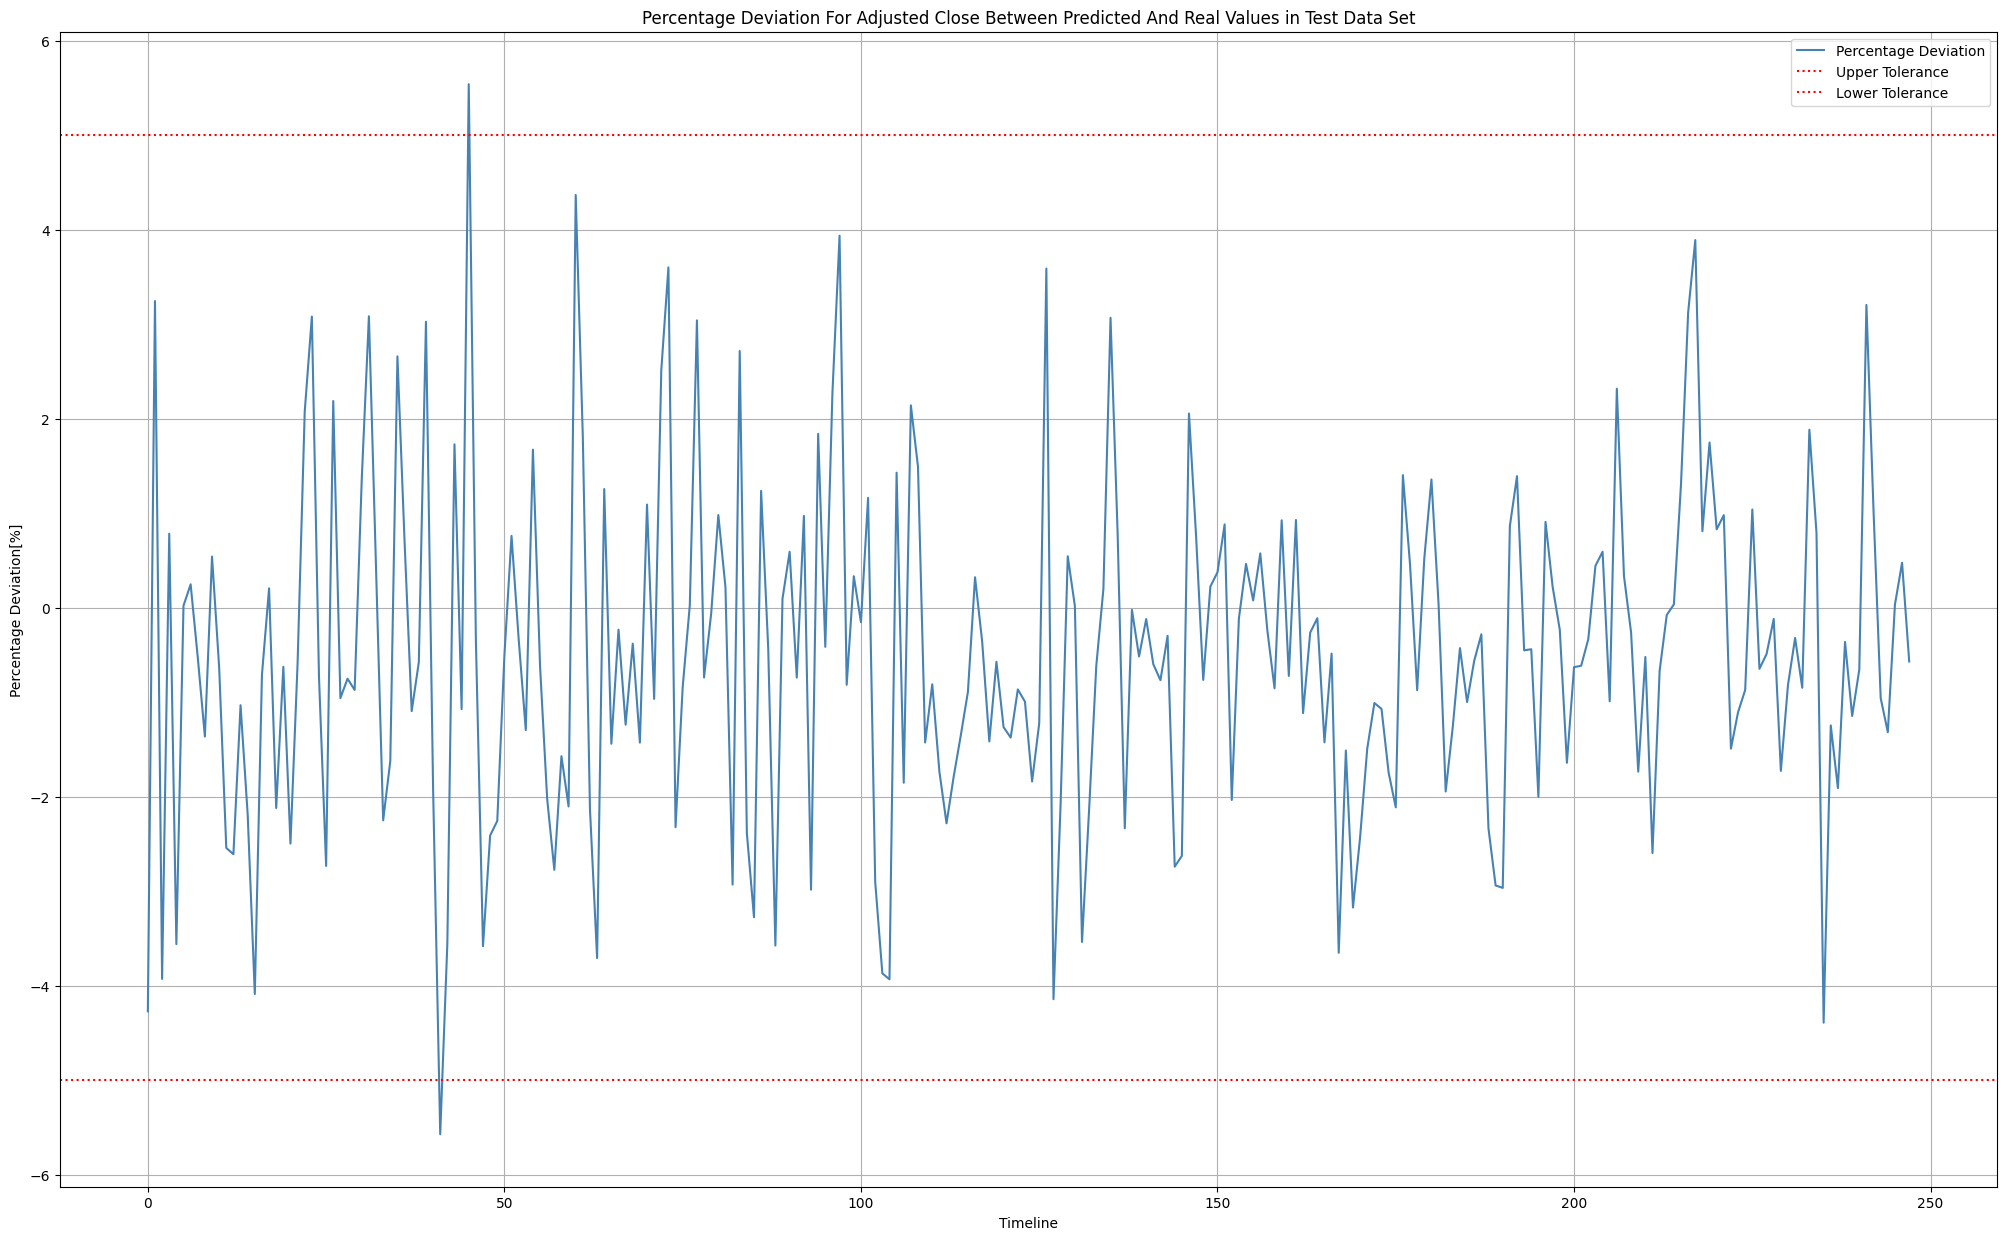

The mean for the percentage deviation in the test data is 1.4543947516388769.
-----------------------------------------
######################
BTC-USD
######################
       Test Predictions       Actuals         diff       diff%
count        361.000000    361.000000   361.000000  361.000000
mean       22583.765416  22536.881084    46.884332    0.378608
std         4480.937625   4554.389225   843.592042    3.607417
min        16462.878796  15787.284180 -3434.743215  -11.061916
25%        19445.103235  19329.833984  -365.489040   -1.524676
50%        21388.848791  21528.087891    94.106544    0.436079
75%        24490.670433  24565.601562   465.595598    2.384952
max        38924.665304  39698.371094  4703.288537   17.358905


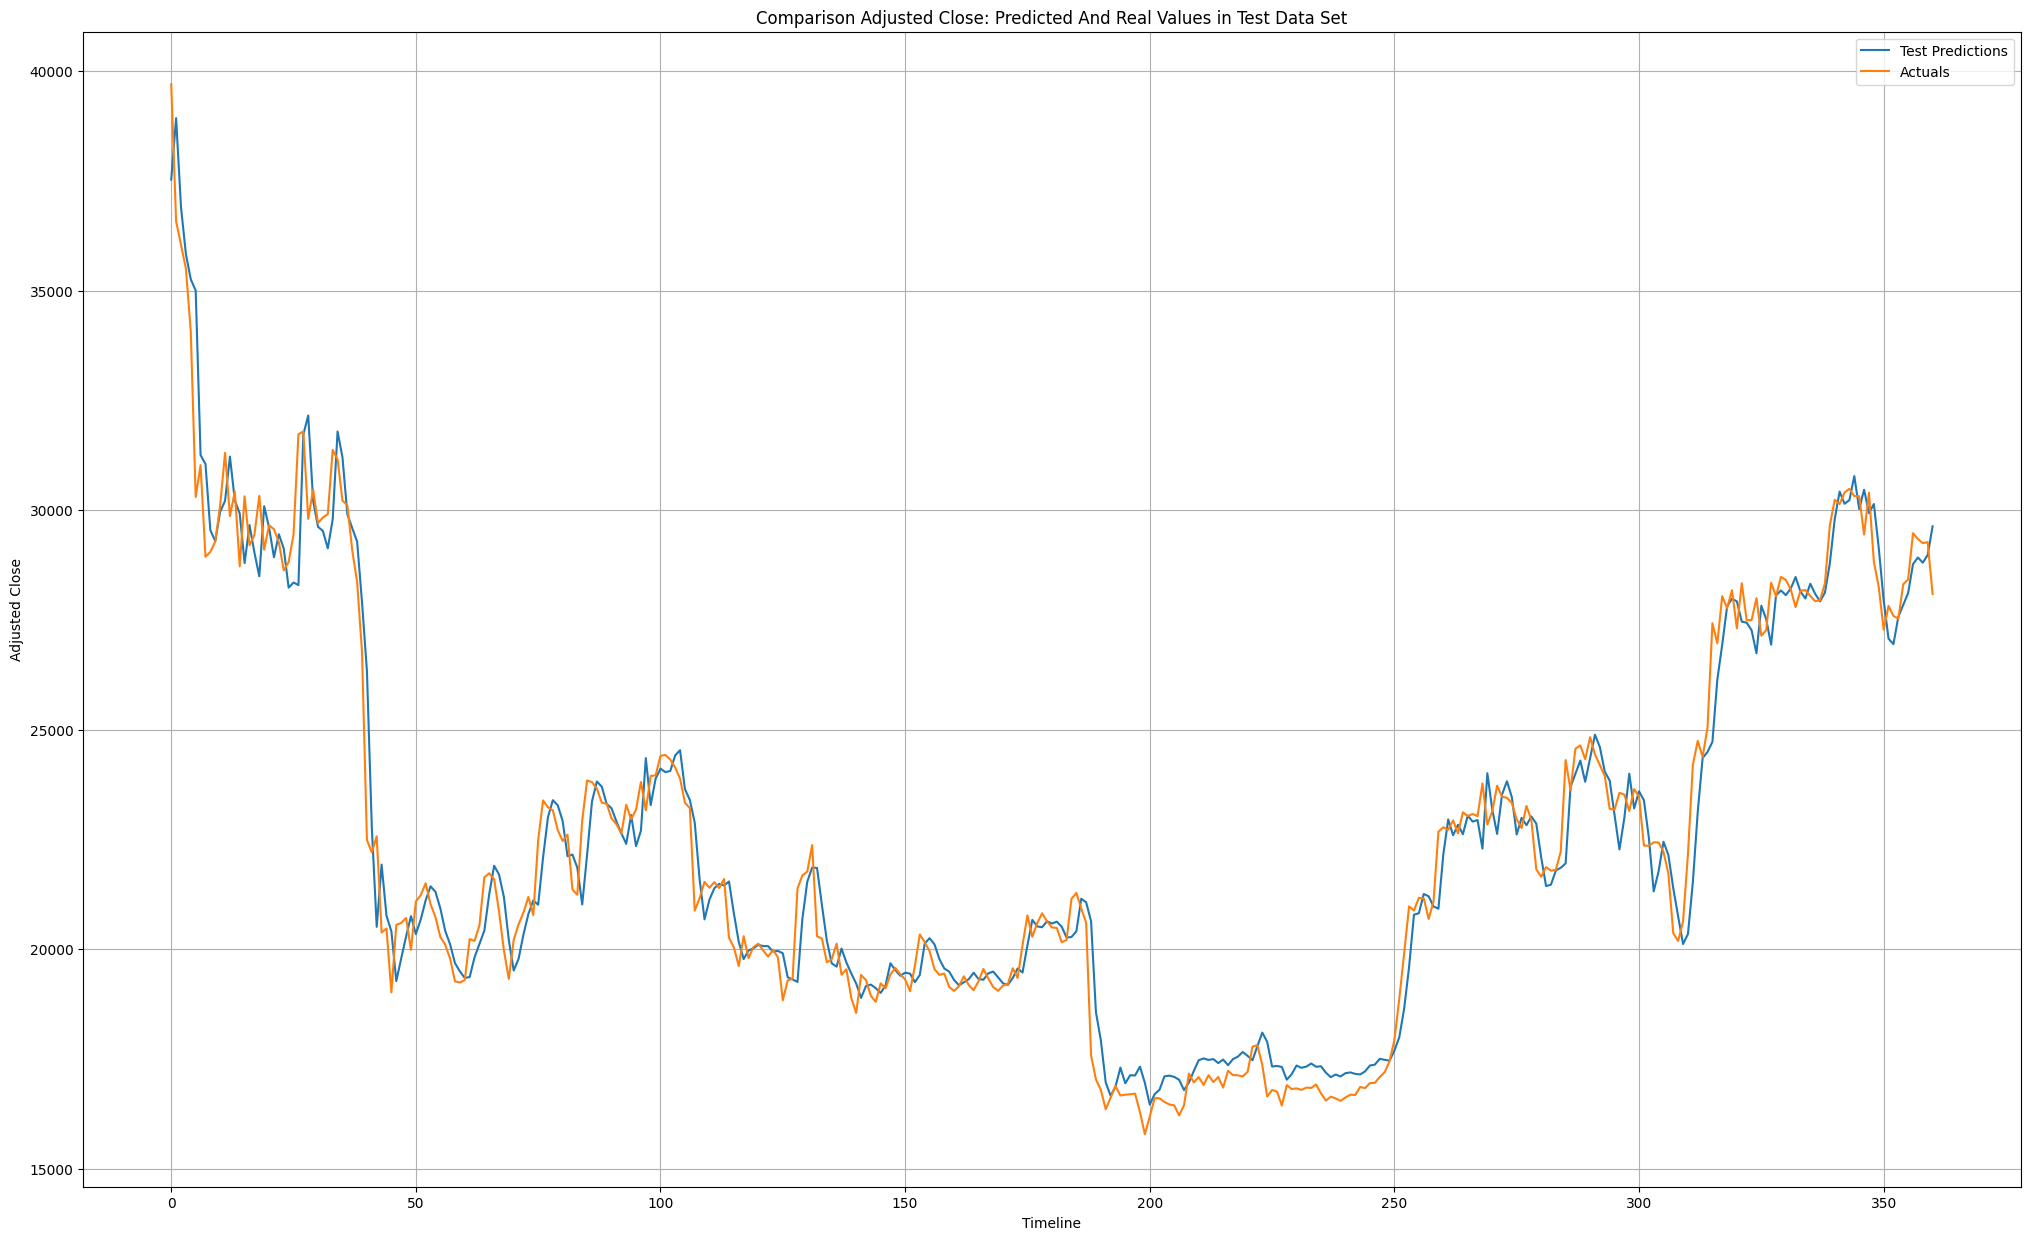

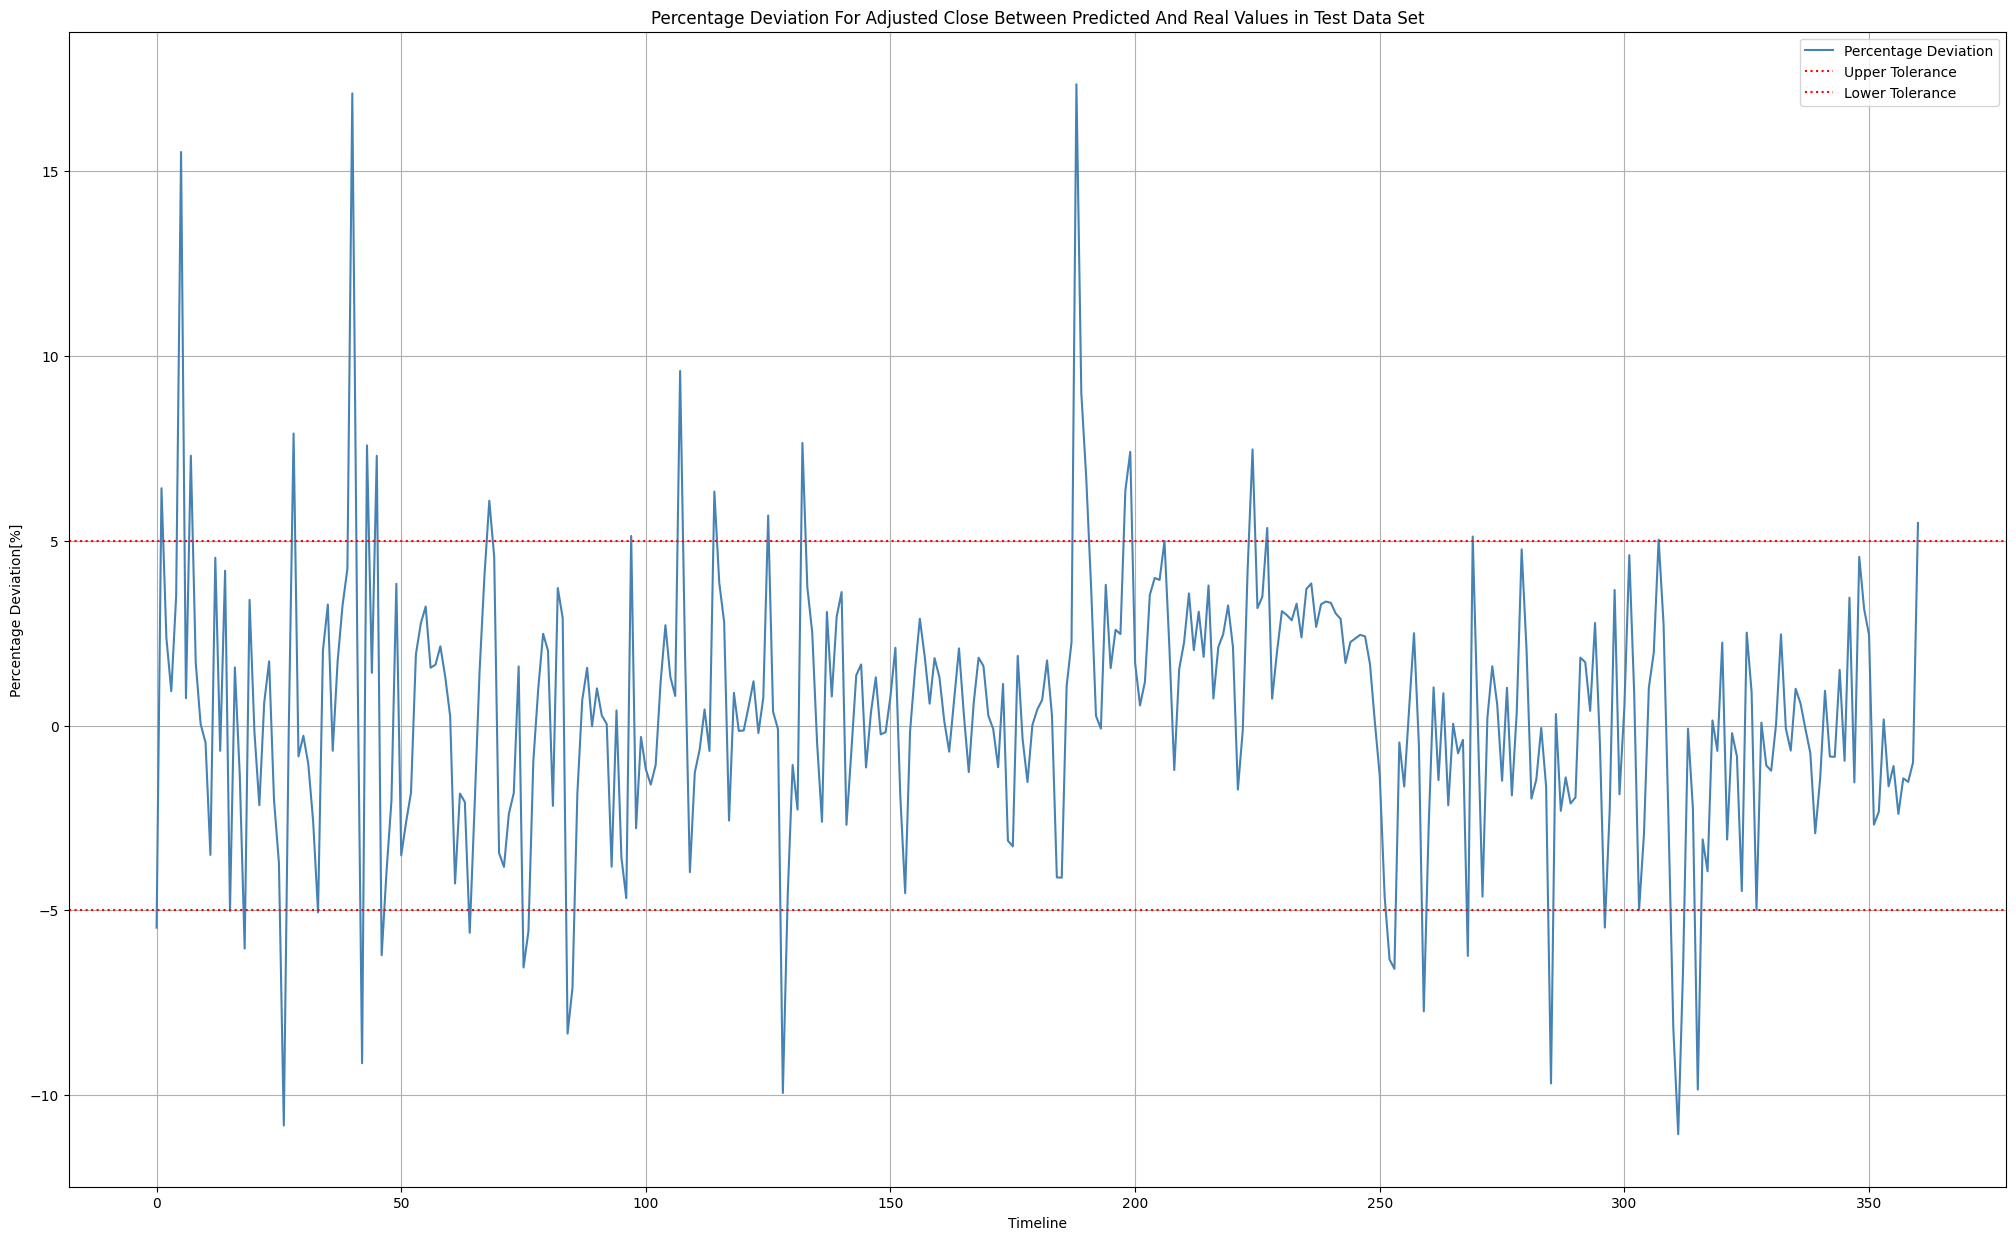

The mean for the percentage deviation in the test data is 2.625027787335174.
-----------------------------------------
######################
ETSY
######################
       Test Predictions     Actuals        diff       diff%
count        244.000000  244.000000  244.000000  244.000000
mean         107.526925  107.436967    0.089958    0.354007
std           17.578750   18.462348    4.510901    4.489525
min           74.507435   69.000000  -13.476720  -12.844758
25%           94.918491   96.470001   -2.661631   -2.436615
50%          106.010637  105.940002    0.061514    0.052948
75%          119.609708  120.332499    3.085793    3.361409
max          145.825434  148.199997   10.197904   14.779571


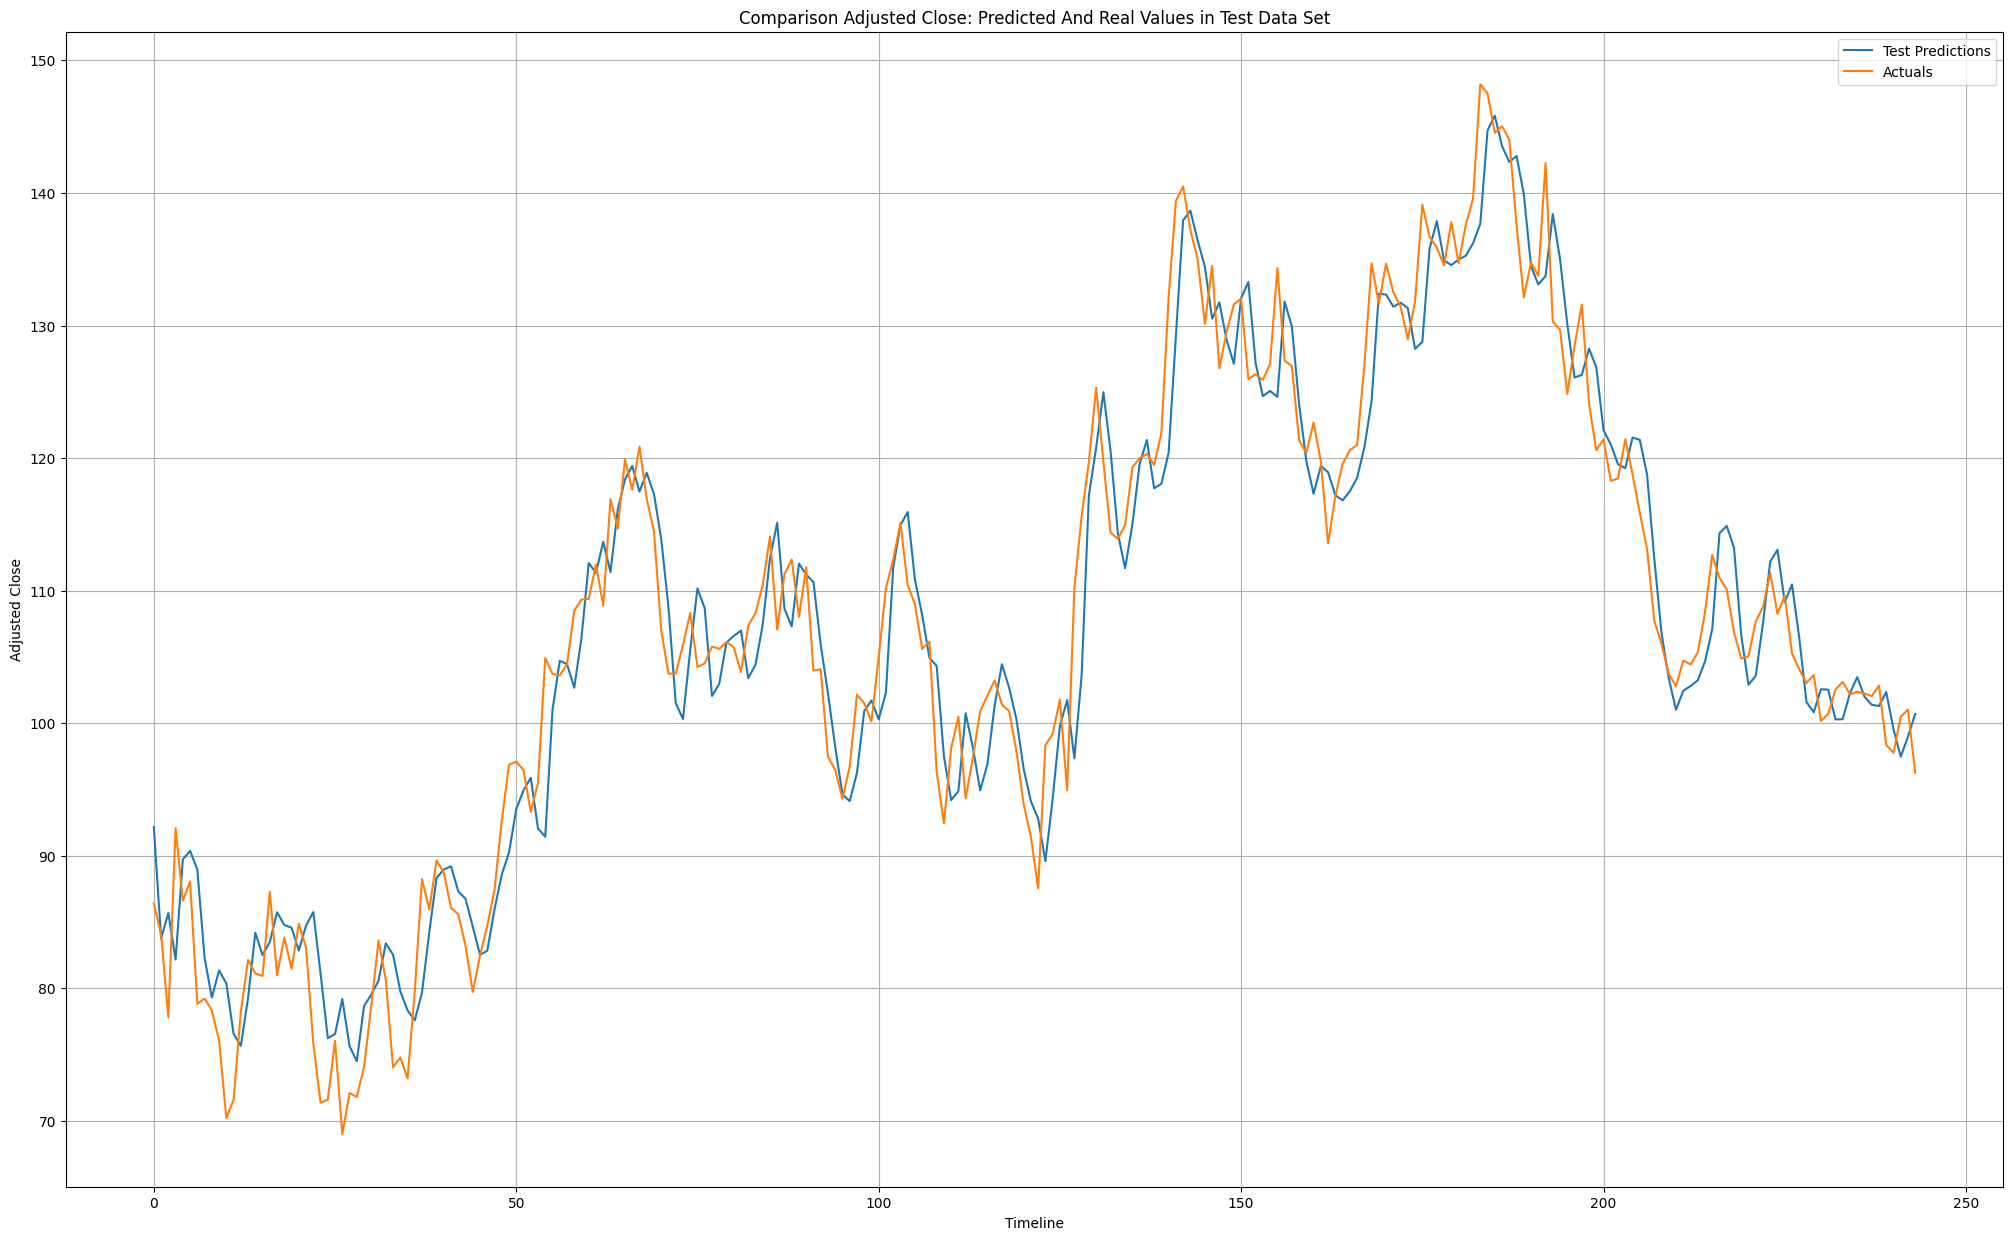

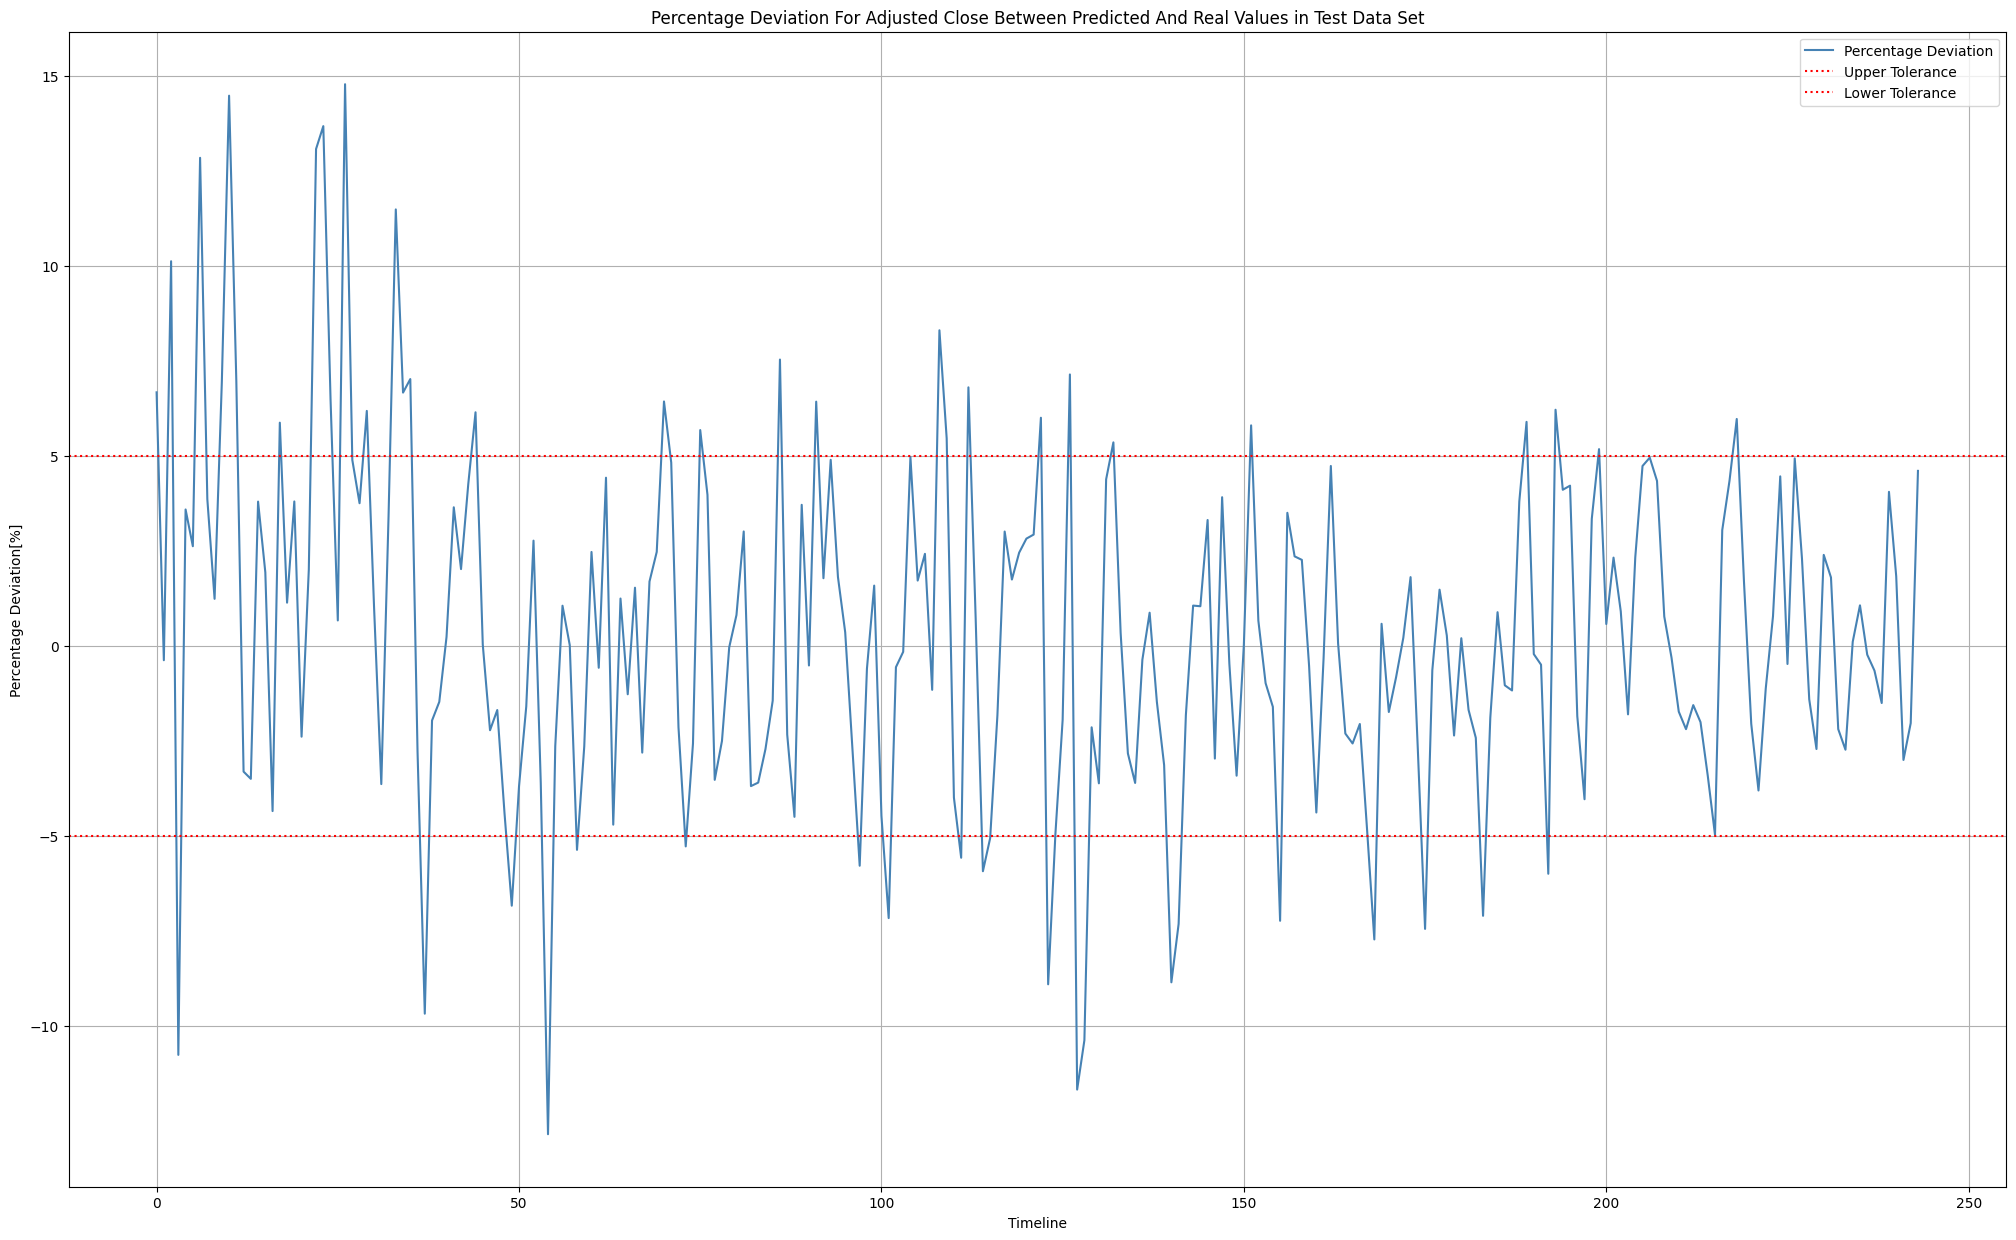

The mean for the percentage deviation in the test data is 3.4725963236214548.
-----------------------------------------
######################
JNJ
######################
       Test Predictions     Actuals        diff       diff%
count        243.000000  243.000000  243.000000  243.000000
mean         166.737039  166.893177   -0.156139   -0.072257
std            6.621545    7.178631    2.040296    1.224242
min          153.314168  151.050003   -7.978622   -4.817717
25%          161.953586  162.438683   -1.540946   -0.932858
50%          167.923179  167.108093   -0.051013   -0.031690
75%          172.968381  173.029297    1.212698    0.732583
max          177.114797  178.962830    5.282033    3.255430


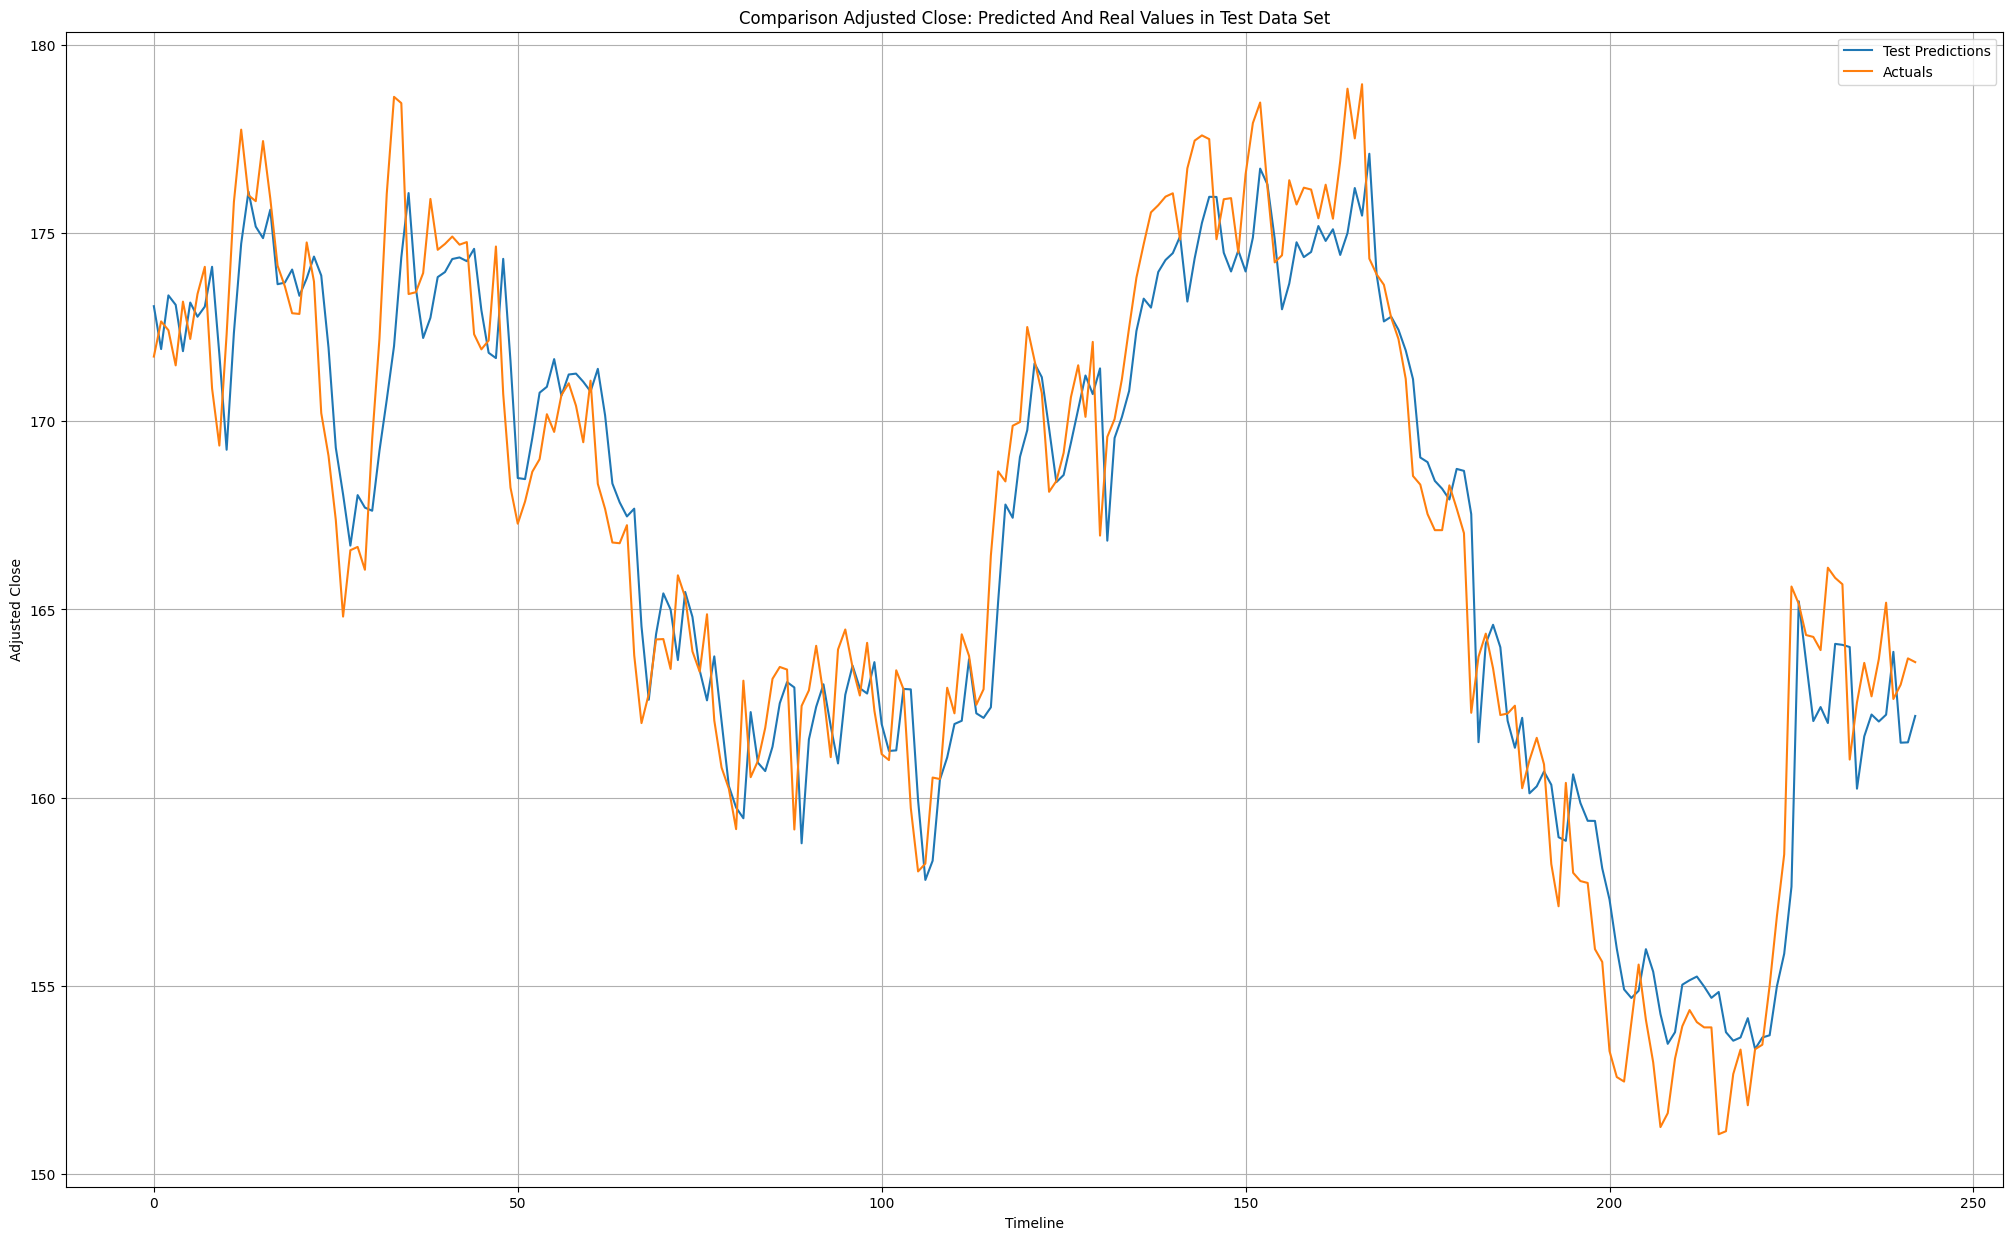

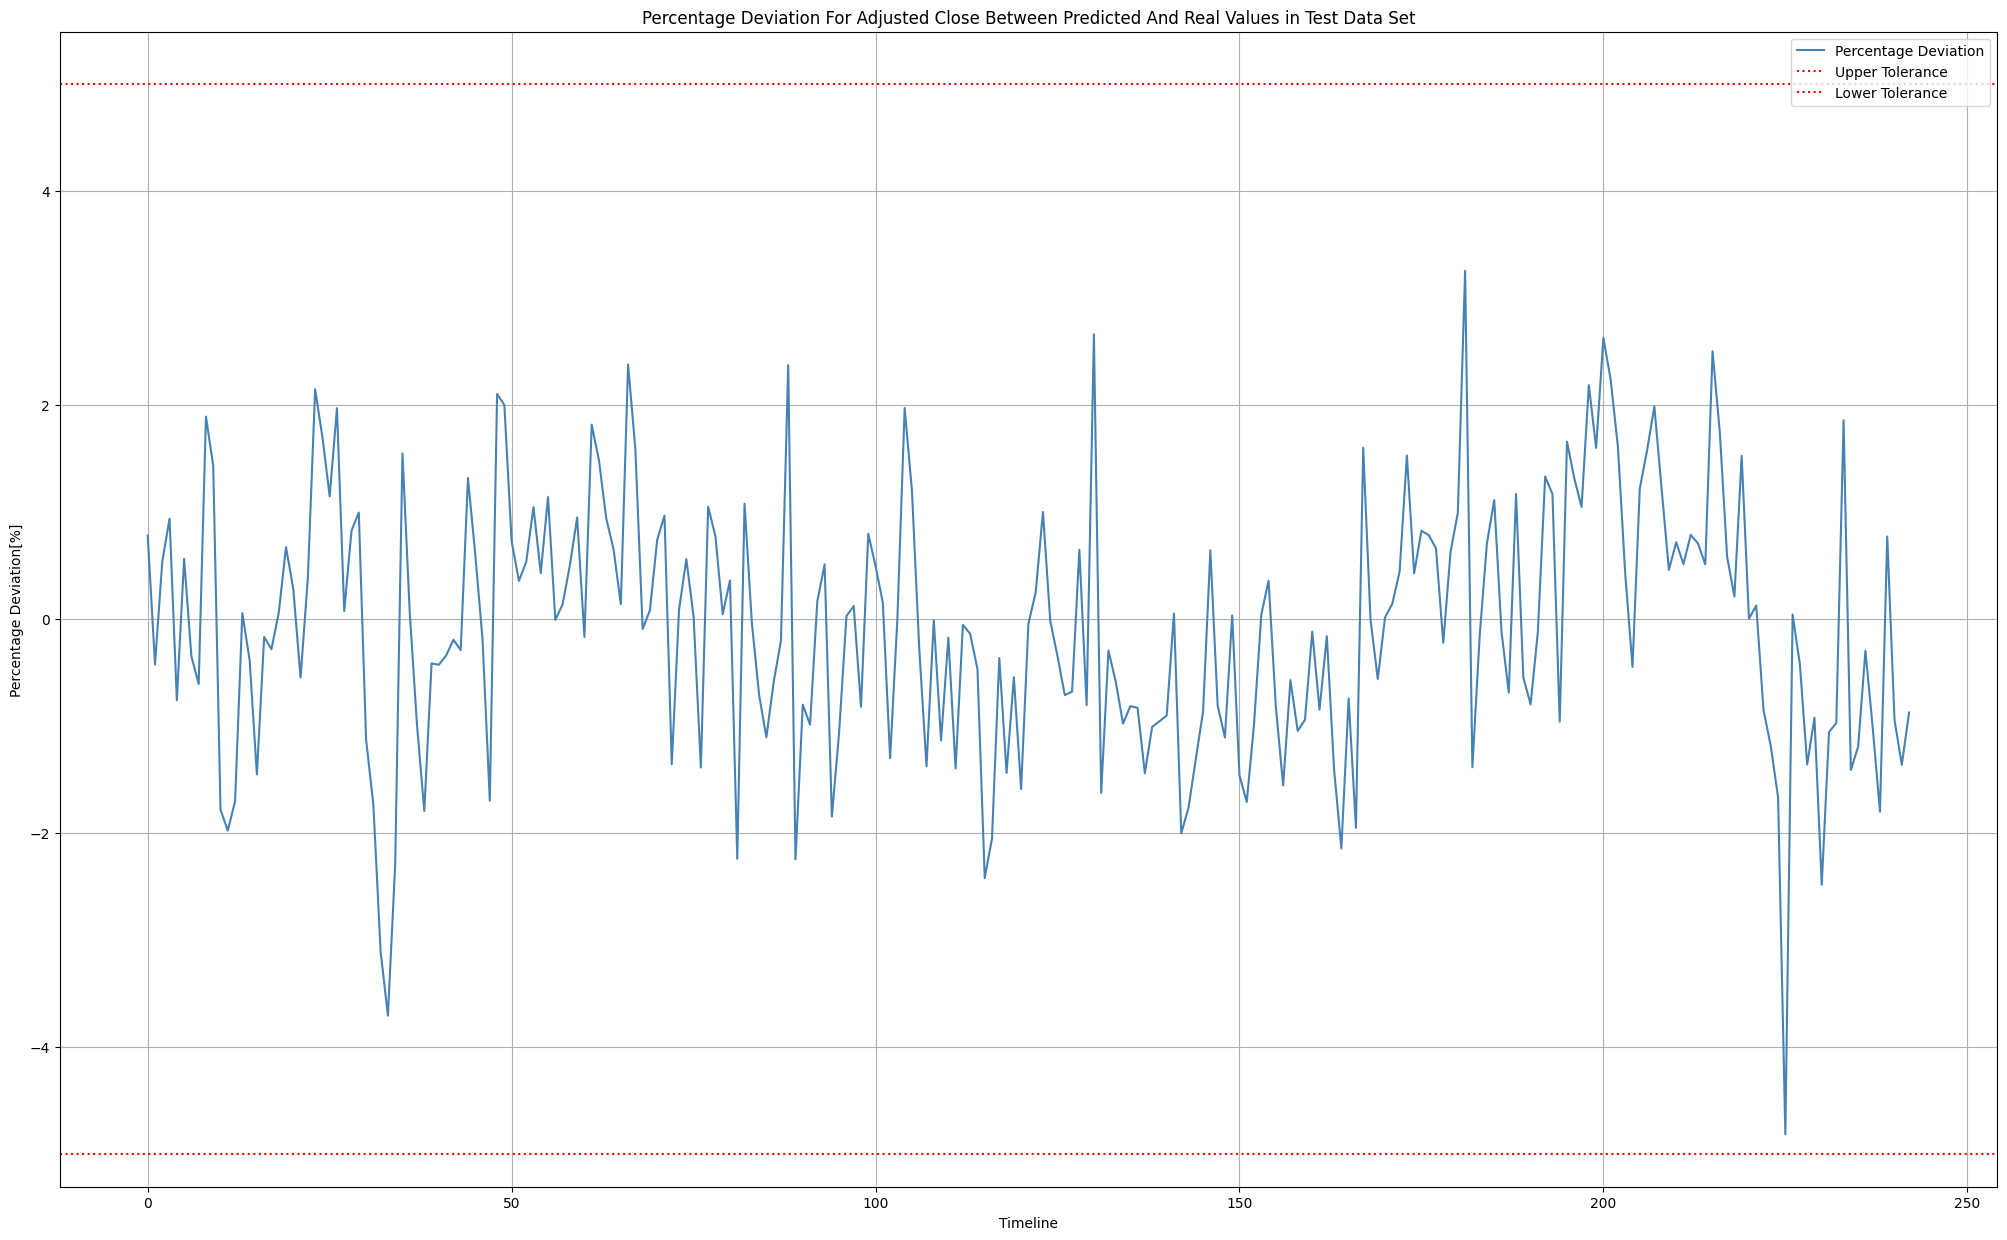

The mean for the percentage deviation in the test data is 0.9668322263575881.
-----------------------------------------
######################
TSLA
######################
       Test Predictions     Actuals        diff       diff%
count        246.000000  246.000000  246.000000  246.000000
mean         216.999504  215.099783    1.899721    1.990342
std           45.727407   51.013176   12.326412    8.132489
min          143.475047  108.099998  -25.169053   -9.373375
25%          181.883464  182.875000   -6.172190   -2.808042
50%          207.642426  210.318336    0.698284    0.370902
75%          247.576753  246.519161    8.579350    4.067398
max          308.607103  309.320007   42.100682   37.047415


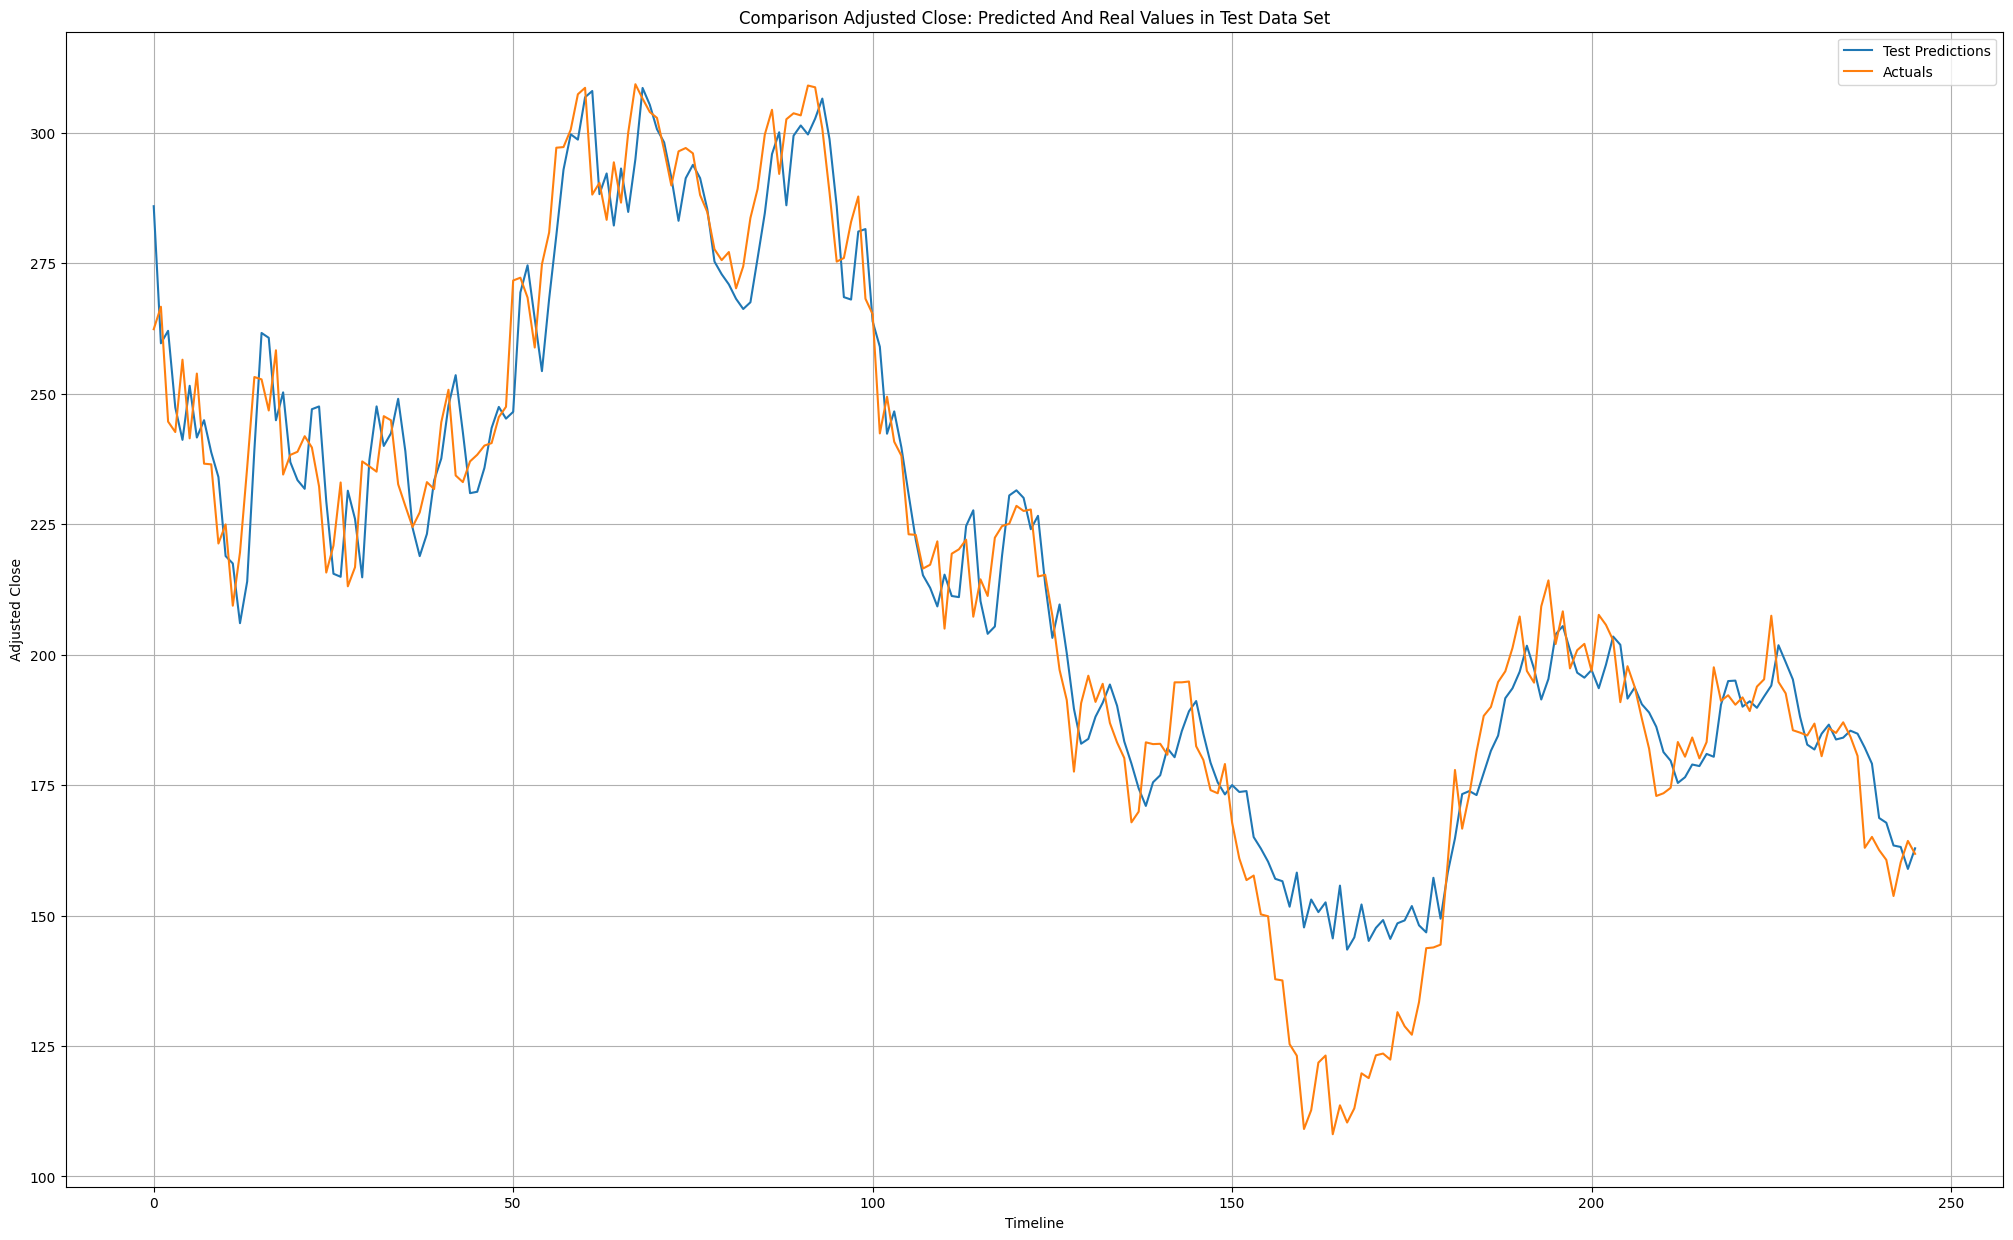

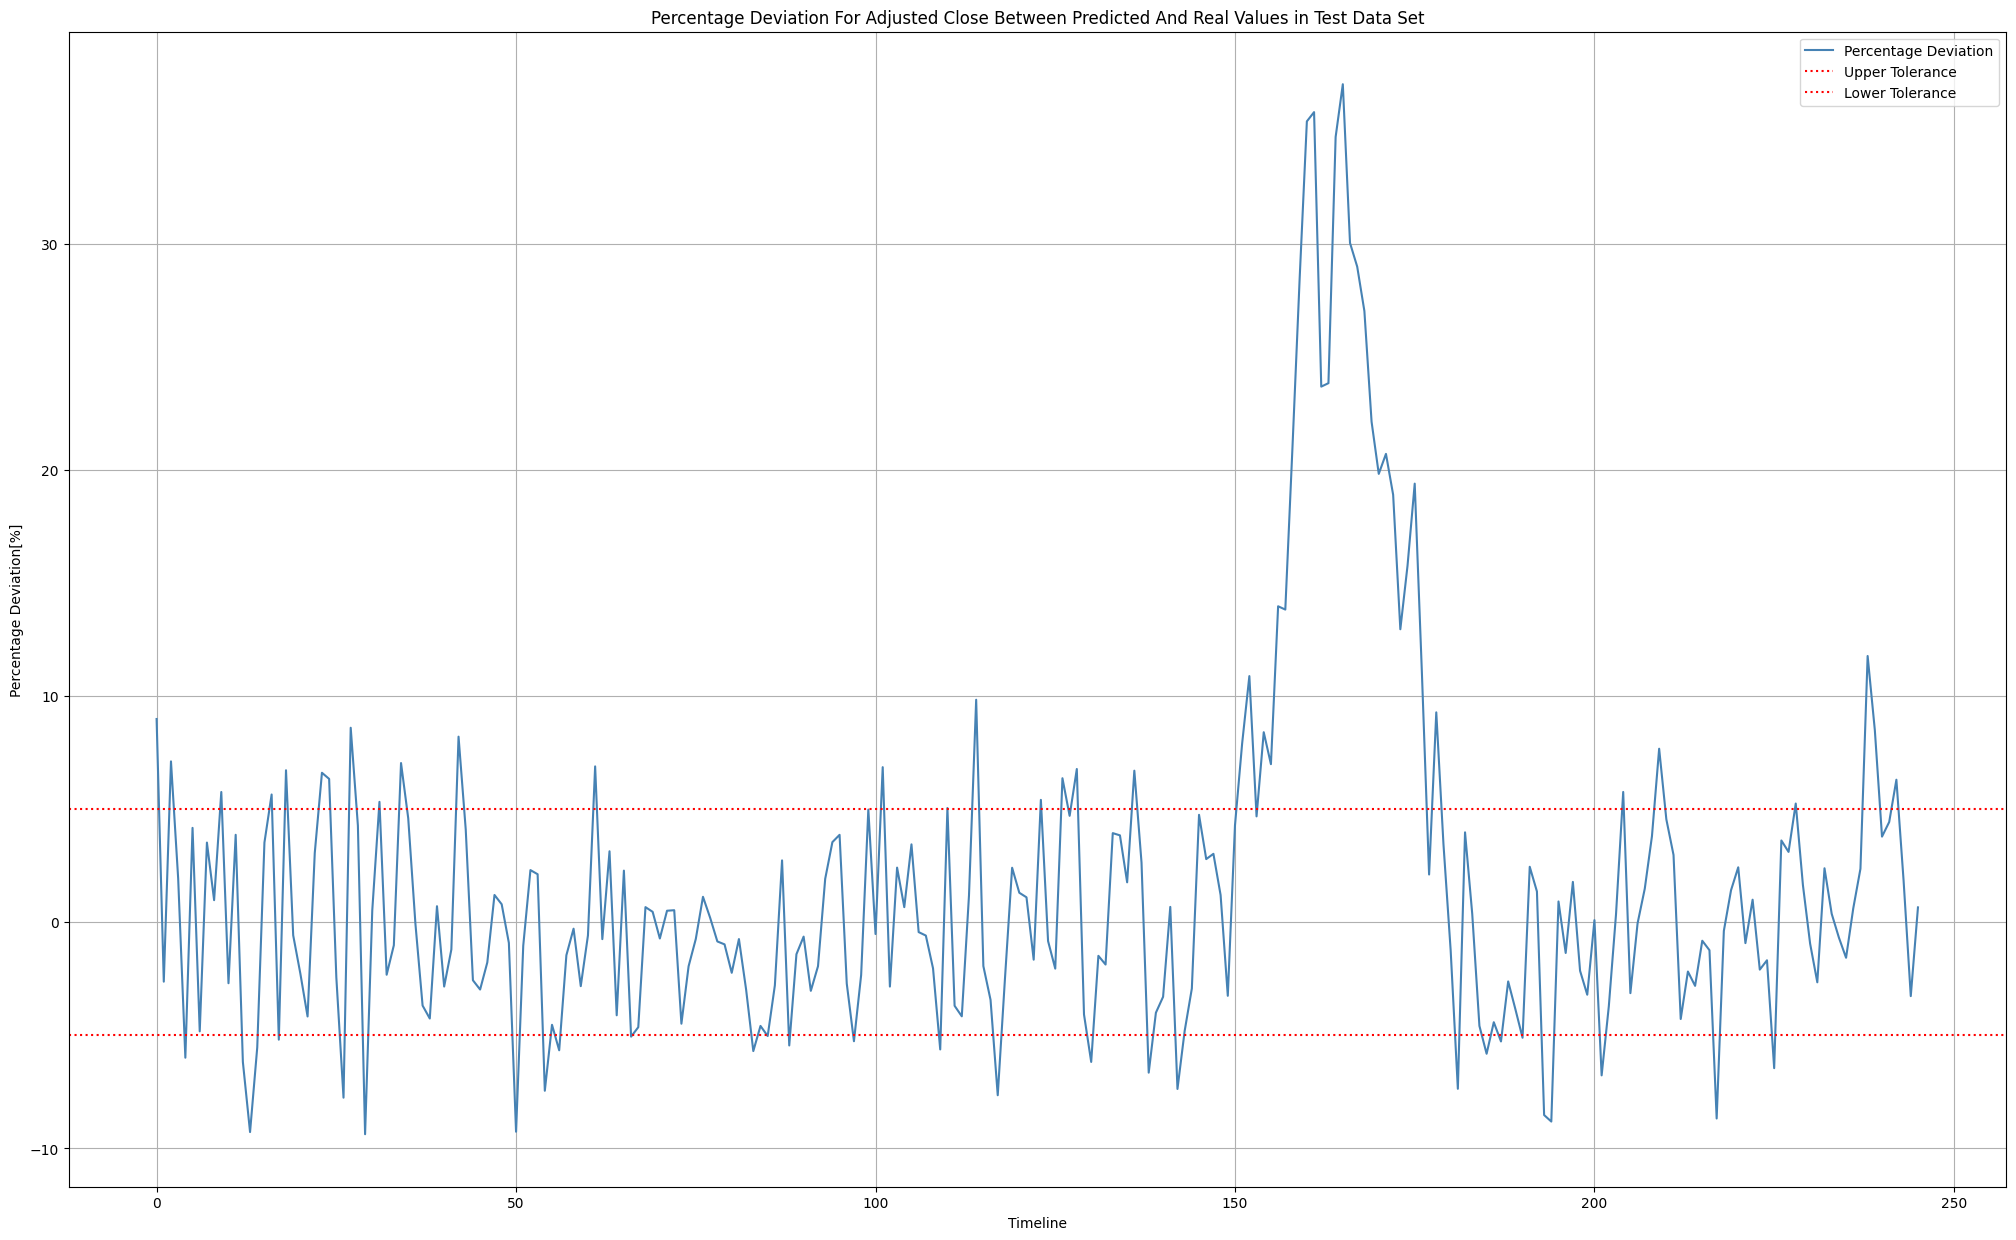

The mean for the percentage deviation in the test data is 5.254020246861314.
-----------------------------------------


In [577]:
# showing the performance of the best model
model_validation(data, best_model)

It can be seen, that the growth stocks and the small-cap stocks are worse than blue-chip and dividend stocks.

## <a class="anchor" id="plstm"> 4. Prediction: LSTM </a>

In this part, I will program a prediction of the Adjusted Close for the next 7, 14 and 28 days and do a trading recommendation.

In [776]:
def prediction_lstm(best_model, days):
    
    prediction = {}
    
    for name in best_model:

        prediction[name] = {}
        
        prediction[name]['prediction'] = []
    
        for i in range(1, days+2):
        
            if i == 1:
                
                X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std  = data_split(data[name], best_model[name]['paramter']['window_size'])
            
                array = np.vstack((X_test[-1][1:], y_test[-1]))
                
                prediction[name]['old_data'] = array[:, -1].tolist()
            
            else:
            
                array_re = np.reshape(array, (1, best_model[name]['paramter']['window_size'], 6))
            
                pre = best_model[name]['model'].predict(array_re)

                prediction[name]['prediction'].append(pre[-1][-1])
                
                array = np.vstack((array[1:], pre))
        
    
    return prediction 

In [777]:
prediction= prediction_lstm(best_model, 28)

In [784]:
def visualization_prediction(prediction):

    for name in prediction:
        
        x = range(1,len(prediction[name]['old_data'])+len(prediction[name]['prediction'])+1)

        x1 = x[:len(prediction[name]['old_data'])+1]

        y1 = prediction[name]['old_data']

        x2 = x[len(prediction[name]['old_data']):]

        y2 = prediction[name]['prediction']

        y1.append(y2[0])

        
        # plotting
        print('######################')
        print(name)
        print('######################')

        plt.figure(figsize=(25, 15))

        # Plot the two parts of the data separately, with different colors
        plt.plot(x1, y1, color='blue', label='Old Stock Data')
        plt.plot(x2, y2, color='red', linestyle='-.', label='Predicted Stock Price')

        # Add labels and legend
        plt.xlabel('Days: Window Size And Prediction Horizon')
        plt.ylabel('Adjusted Close')
        plt.title('Prediction: Adjusted Close')
        plt.legend(['Line'], loc='upper right')
        plt.grid()
        plt.legend()

        # Show the plot
        plt.show()
        
        if y1[-1]>y2[-1]:
        
            print('Trading Recommendation after {} days: Sell!'.format(len(x2)))
        
        else: 
            
            print('Trading Recommendation after {} days: Hold!'.format(len(x2)))
        
        print('-----------------------------------------')


######################
BMW.DE
######################


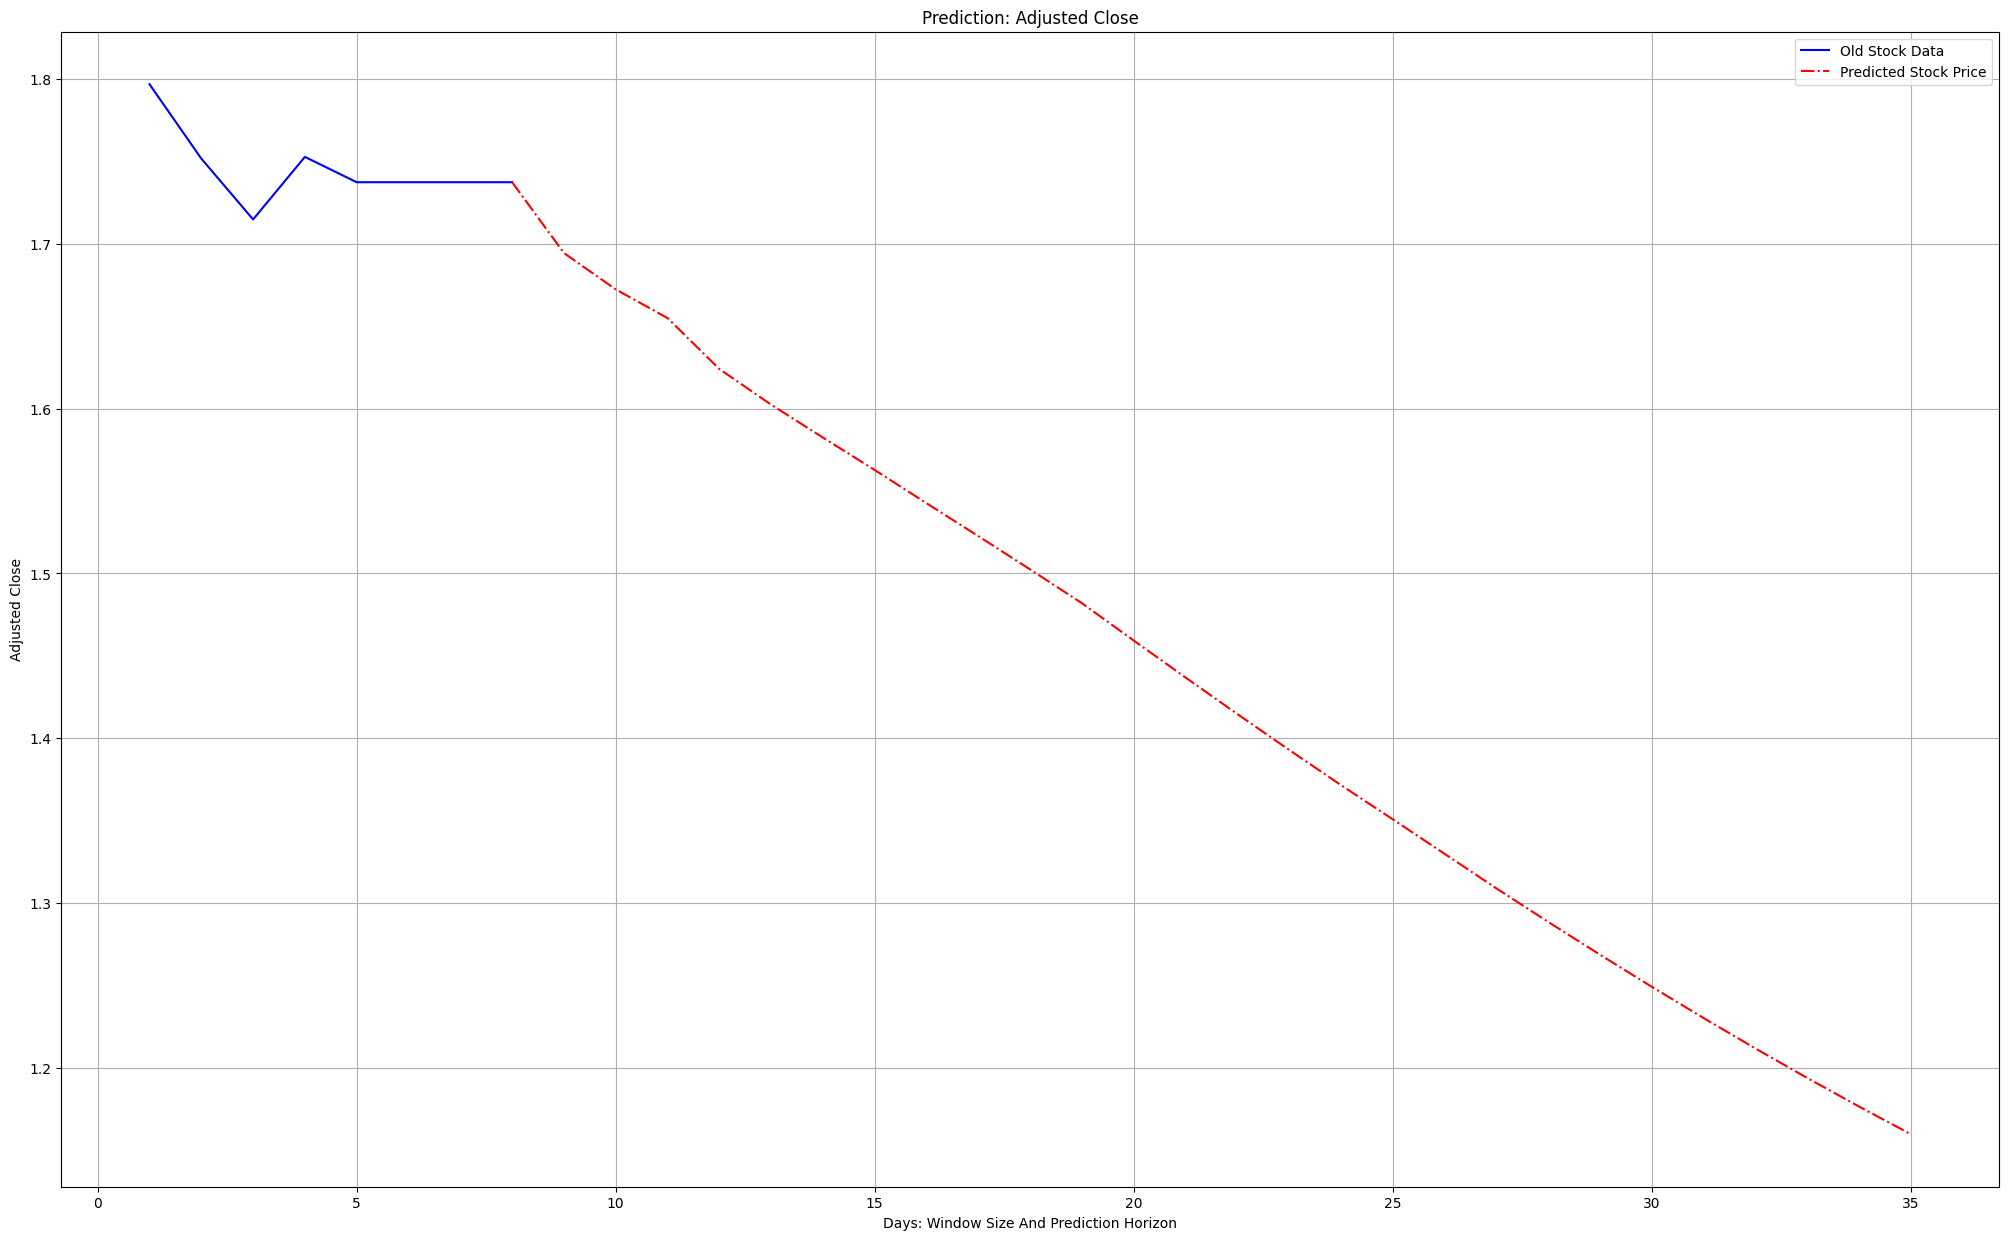

Trading Recommendation after 28 days: Sell!
-----------------------------------------
######################
BTC-USD
######################


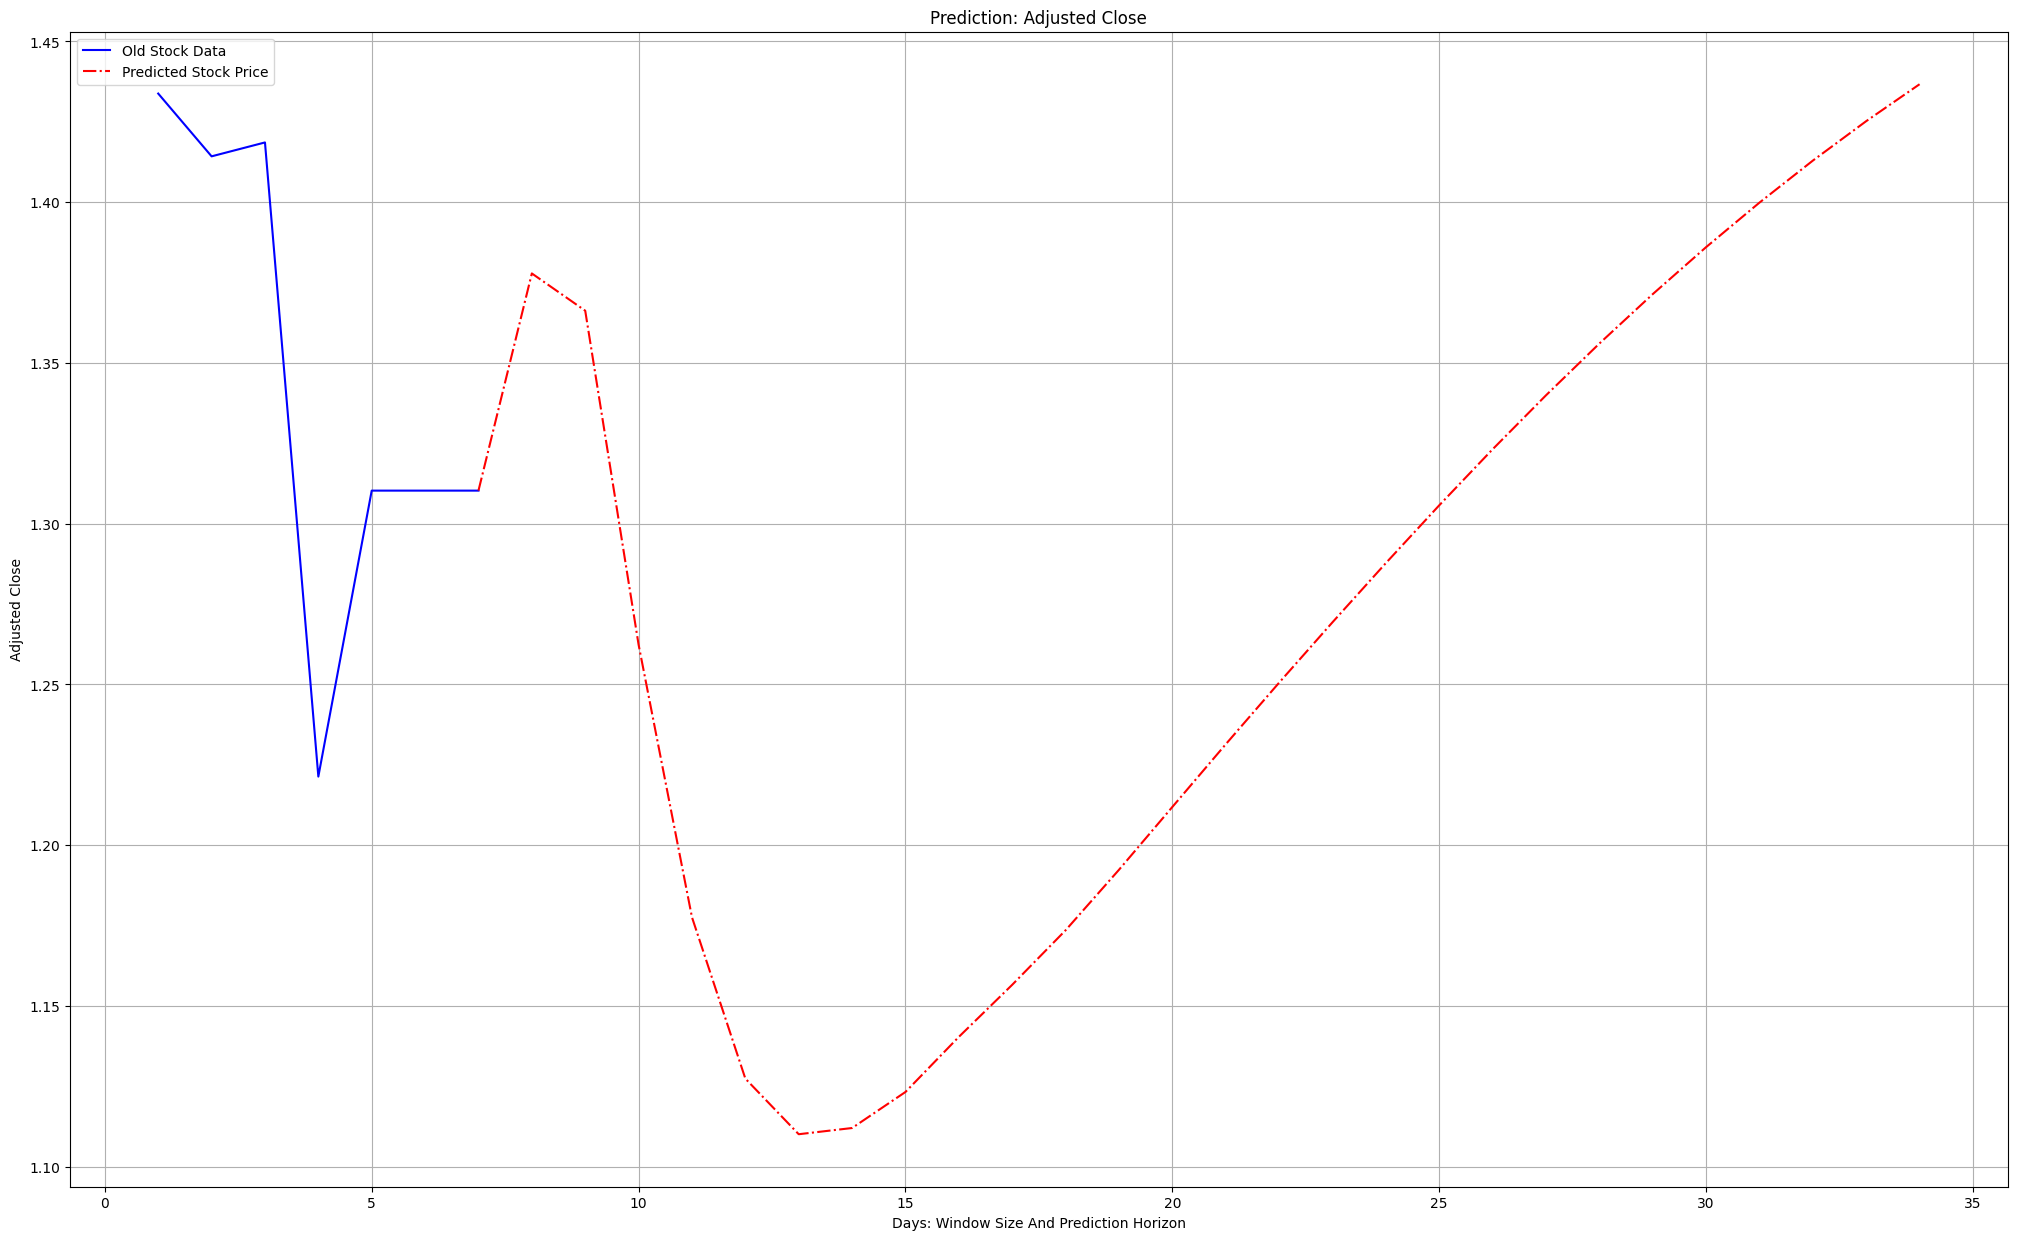

Trading Recommendation after 28 days: Hold!
-----------------------------------------
######################
ETSY
######################


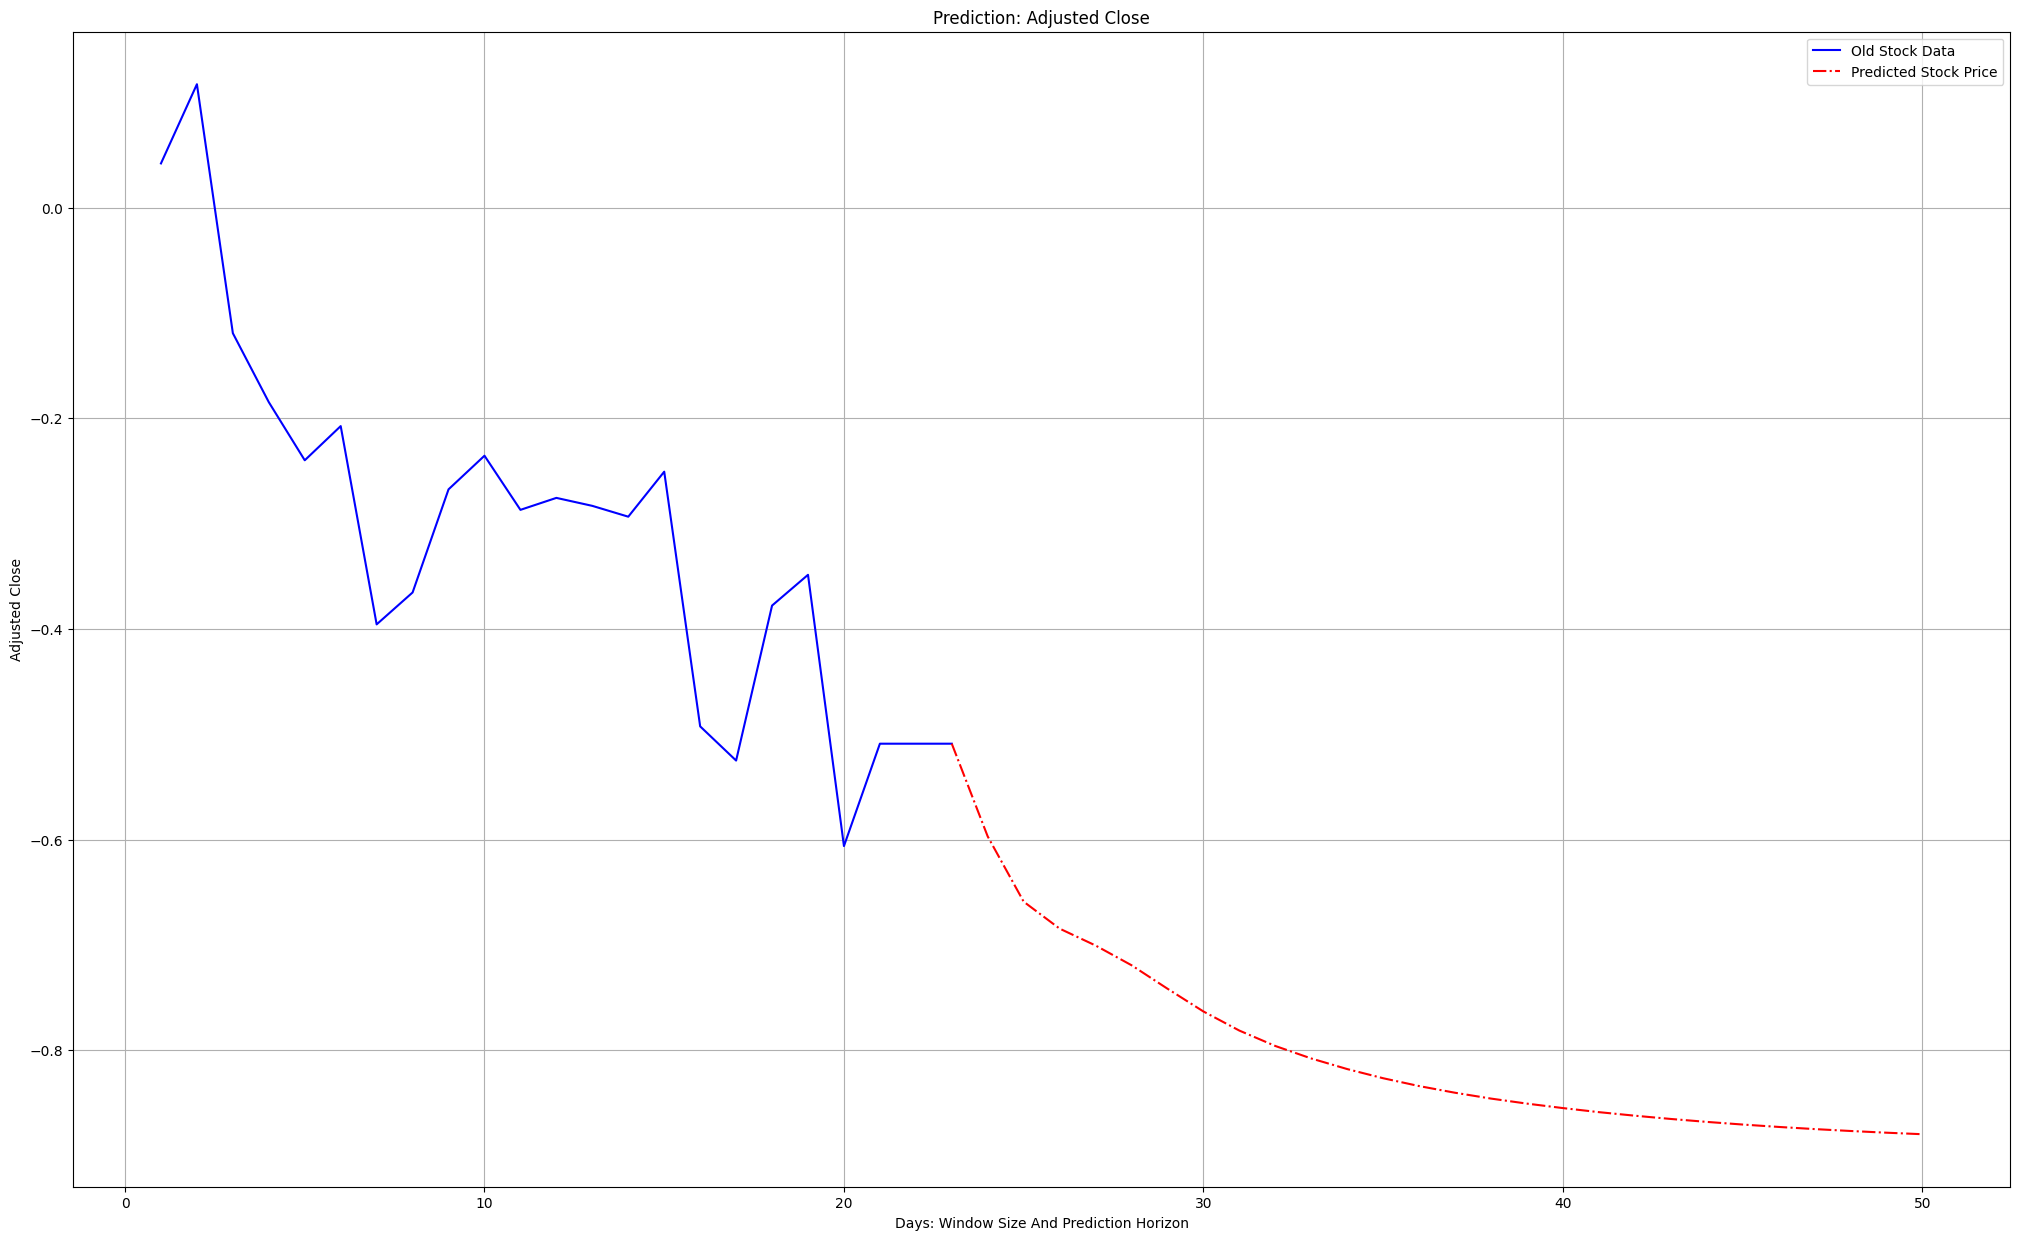

Trading Recommendation after 28 days: Sell!
-----------------------------------------
######################
JNJ
######################


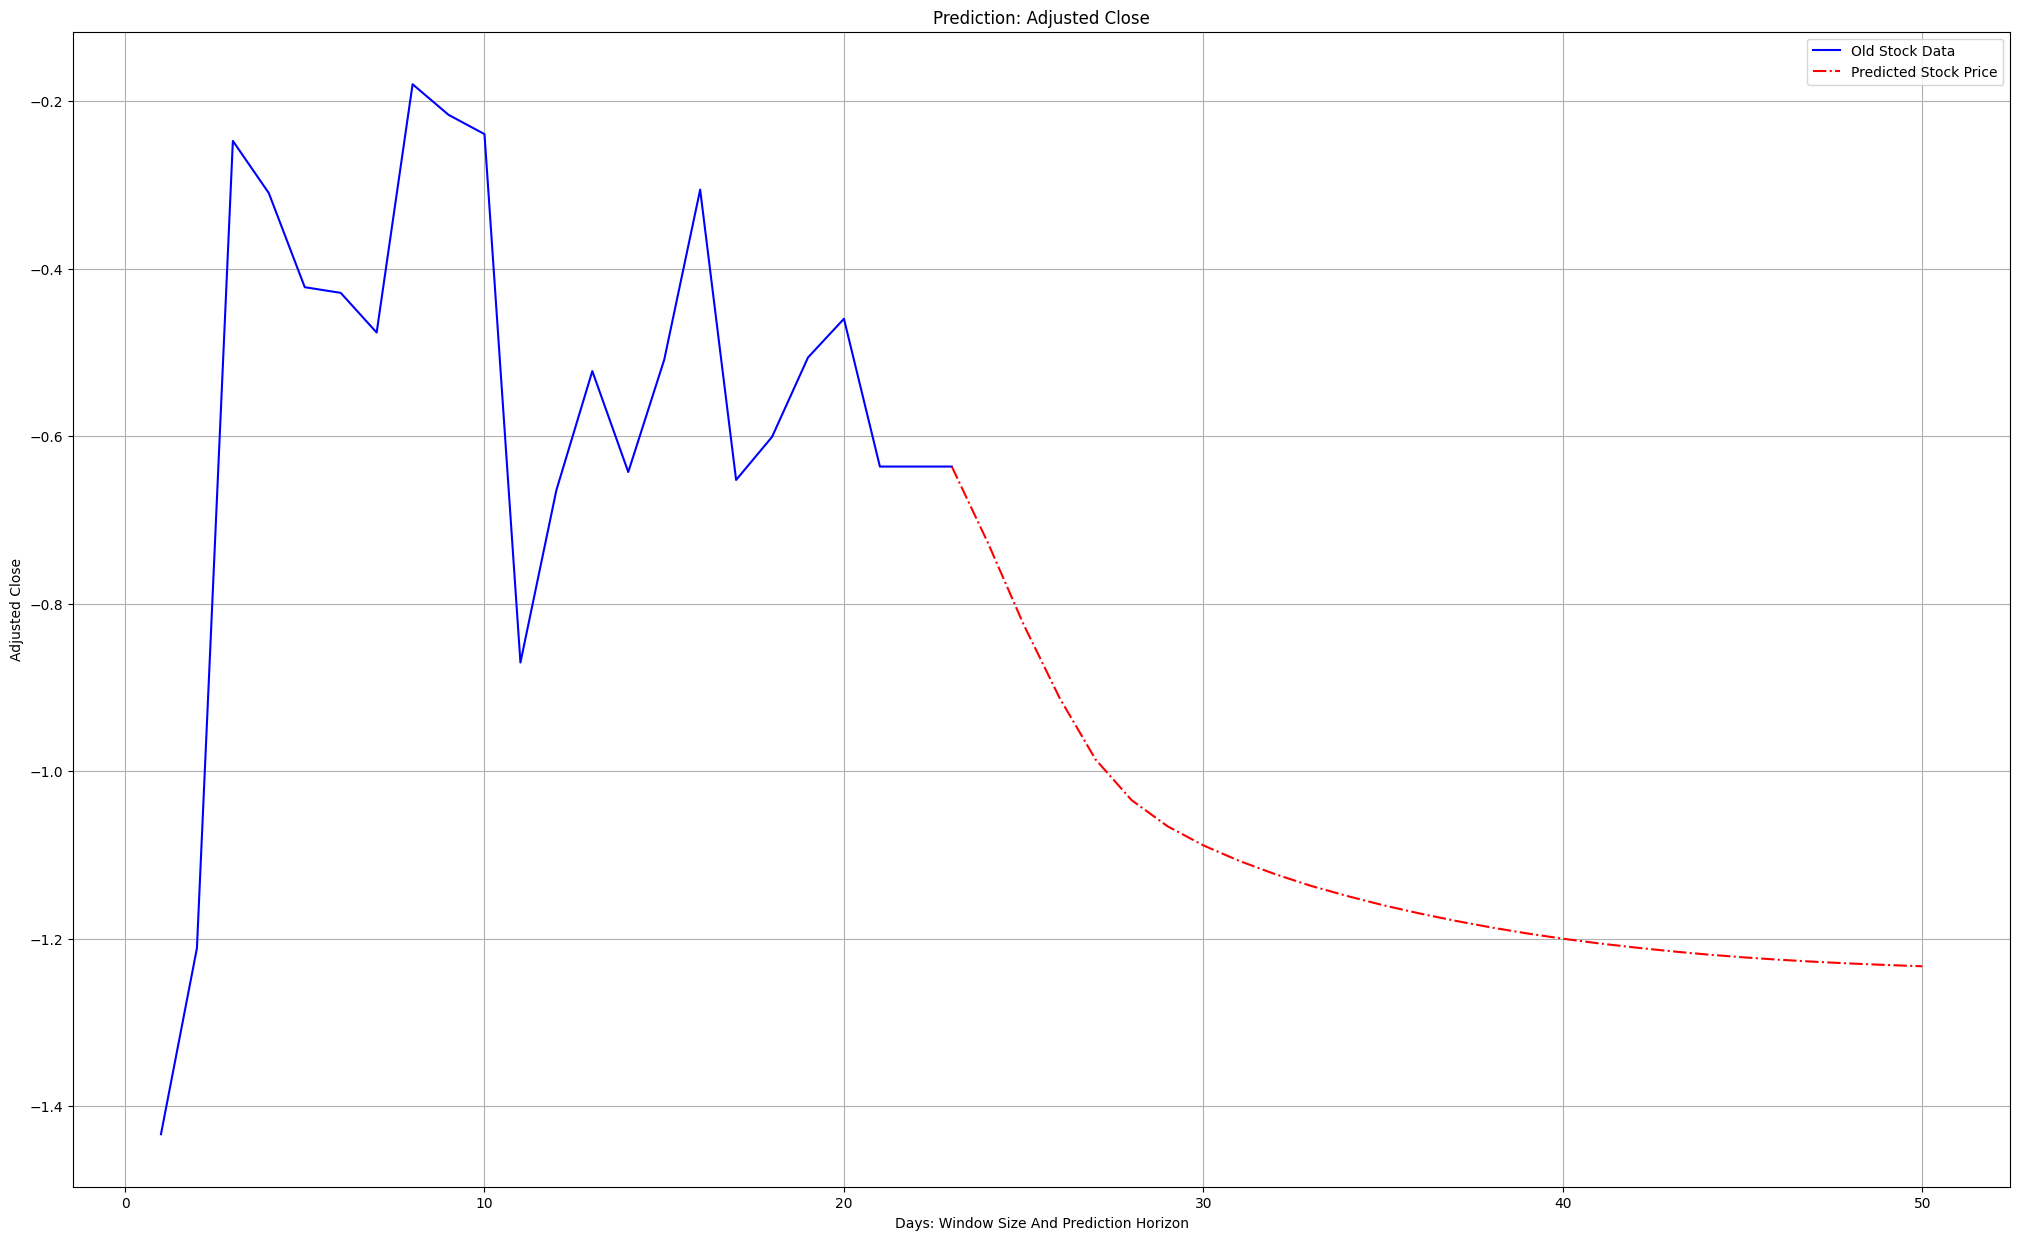

Trading Recommendation after 28 days: Sell!
-----------------------------------------
######################
TSLA
######################


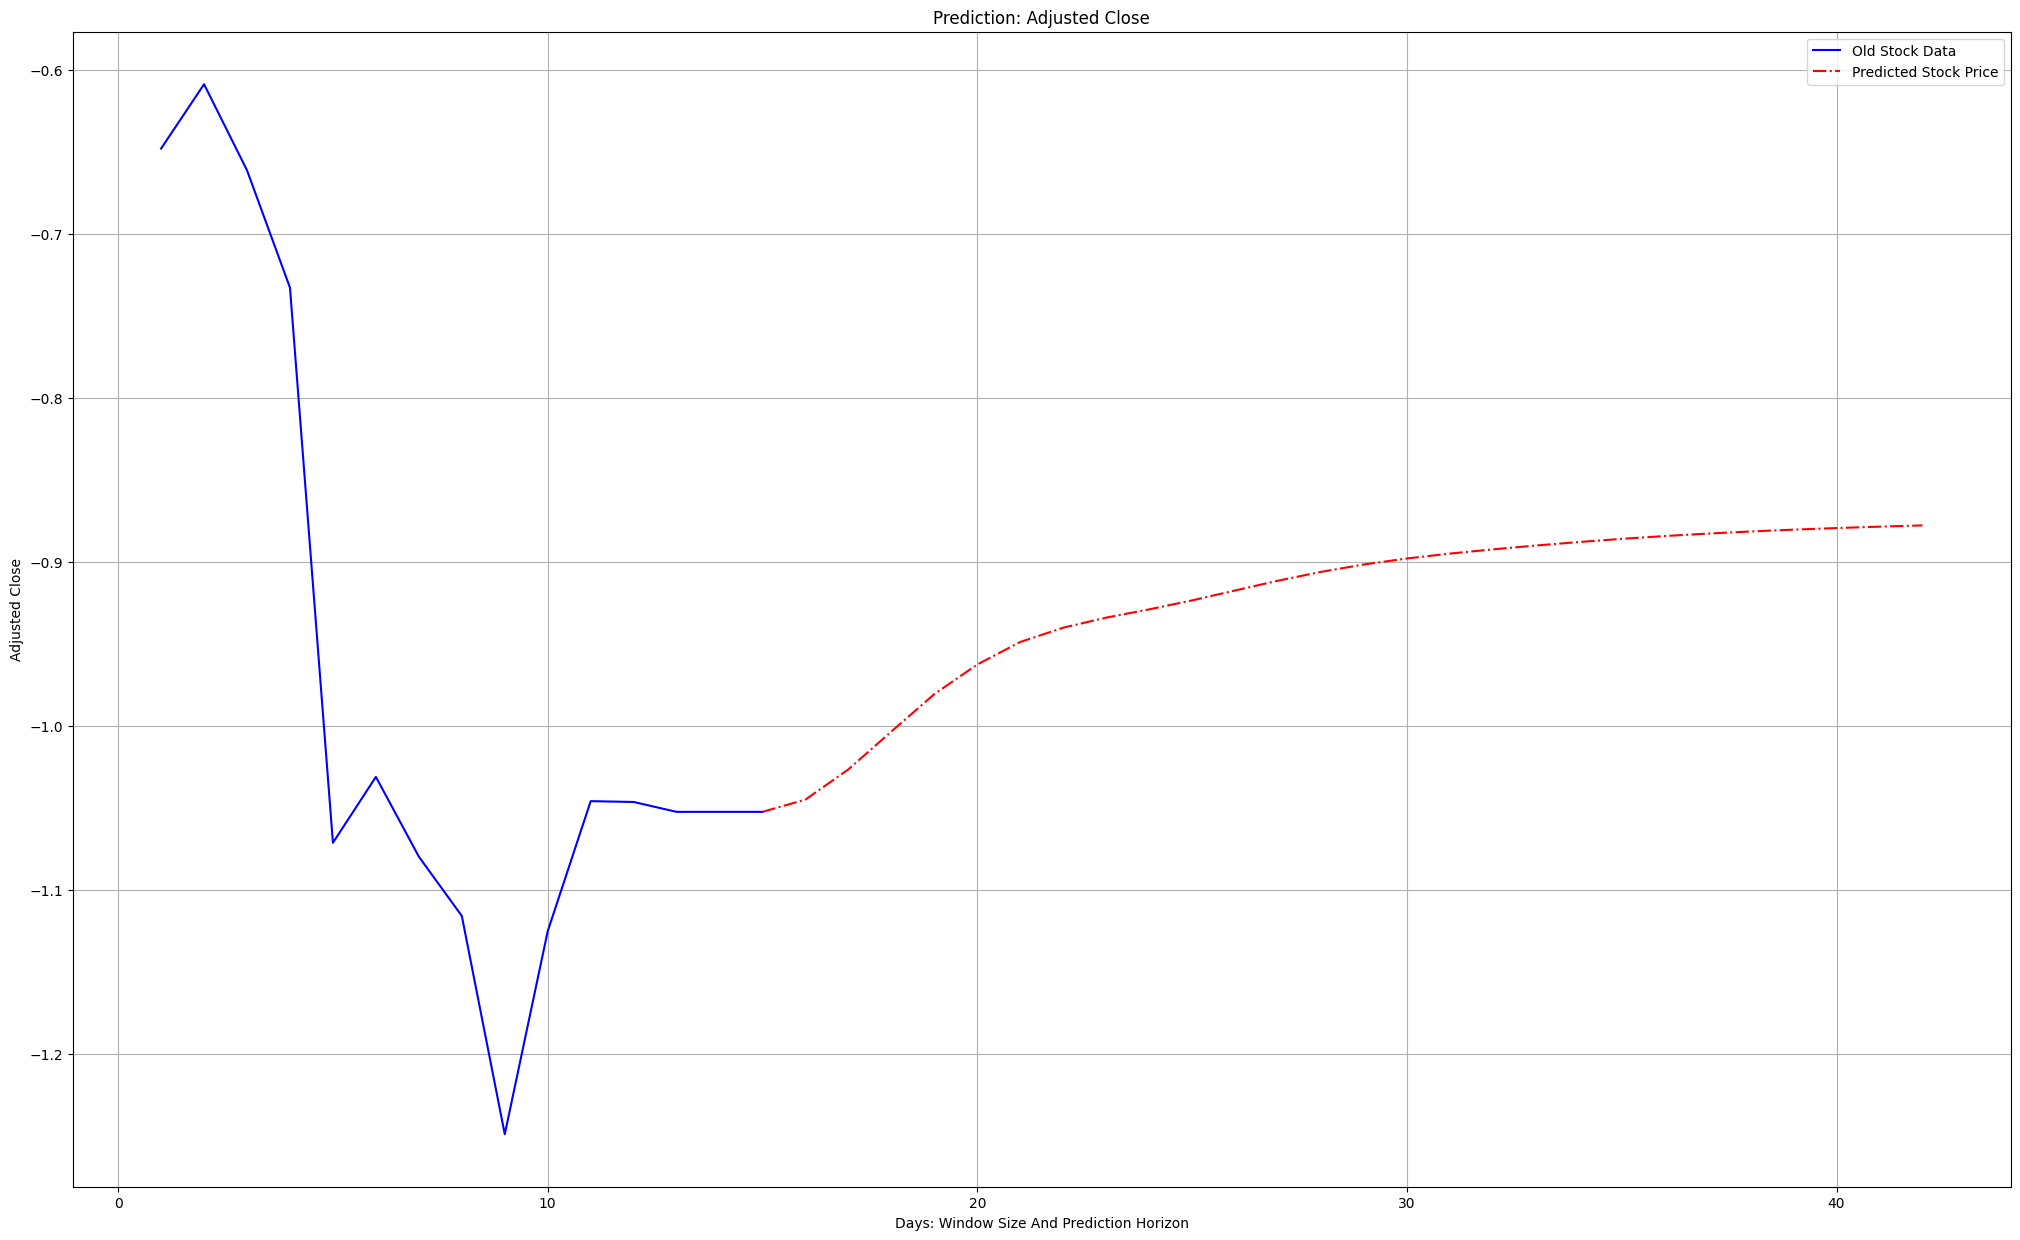

Trading Recommendation after 28 days: Hold!
-----------------------------------------


In [785]:
visualization_prediction(prediction)